## Introduction to Business Analytics Project Assignment 

### Group Members
- Stanisław Howard, s231719
- Alexis Van den Heede, s231860
- Matthias Van Mechelen, s231739
- Sven Palac, s231799
- Salar Ravangouy Mytouei, s232038

### Introduction & Data Analysis and Visualization
This report presents an analysis of data and predictions for Citi Bike, a bike-sharing company based in New York, USA. The objective is to assist Citi Bike in optimizing its operations by examining current user trends and habits, utilizing this information to forecast demand for clusters of bike stations.

The first section of the report, following this brief introduction, focuses on data analysis and preparation for subsequent sections through data cleaning and preprocessing. The second section presents the demand predictions derived from the initial data. Additionally, the third section outlines the exploratory component of the report, achieved by incorporating weather data into the initial dataset. Finally, the last section summarizes the conclusions drawn from this report.

Additional explanation for the decisions made has been moved to Appendix A. Whenever a sentence is followed by (Appendix Ai), where i is a number, additional explanation to the sentence or previous sentences are provided in appendix A under the bullet point with tag Appendix Ai.

The data analysis starts by importing Python libraries and looking at the data.

In [1]:
import pandas as pd
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import datetime as dt

In [2]:
df = pd.read_csv('data/Trips_2018.csv')

In [3]:
# Delete this later !!!!!!!!!!!!!!!!!!!!!!!
df_copy = df.copy()
df.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


In [4]:
# rerun this to save time if you make a typo and need original df again, REMOVE LATER
df = df_copy.copy()

Once we import our data we need to inspect the content. As we can see a couple of things need to be handled immediately. For instance checking datatypes, missing values, duplicates and making sure the data is in the right format. We also need to handle the categorical values correctly. A brief comment in each code cell explains what was done in the specific cell.

In [5]:
### Let's check the datatypes first
df.dtypes

Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object

In [6]:
# column 0 is unnamed, change name to trip_id and convert column to index
df.rename(columns={'Unnamed: 0':'trip_id'}, inplace=True)
df.set_index('trip_id', inplace=True)

In [7]:
#  convert start time and stop time to datetime objects
df['starttime'] = pd.to_datetime(df['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
df['stoptime'] = pd.to_datetime(df['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")

In [8]:
# get rid of categorical datatype which is the user subscriber type
df = pd.get_dummies(df, columns=['usertype'], dtype=int, drop_first=True)

Now that all the datatypes have been handled, it is time to inspect actual values in the dataframe. We will look at the distribution of particular columns and check for outliers. Additionally, we will also check for duplicates and missing values. 

Let's first look at the locations of the start stations by plotting them to the map of New York City.

In [9]:
# plotting coordinates
def plot_map(coords):
    plt.scatter(coords[:,0], coords[:,1], s=0.75)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.show()

def plot_map_with_background(coords):
    folder_path = 'data/nyc_folder'
    shapefiles = [file for file in os.listdir(folder_path) if file.endswith('.shp')]
    gdf = gpd.read_file(os.path.join(folder_path, shapefiles[0]))
    ax = gdf.plot(figsize=(10, 10), alpha=0.1, edgecolor='k')
    plt.title(f"Visualization of Stations in NYC")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    ### plot the coordinates on the map
    plt.scatter(coords[:,0], coords[:,1], s=0.75, c='blue')
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.show()

In [10]:
coords = df[['start_station_longitude','start_station_latitude']].values
coords = np.unique(coords, axis=0)

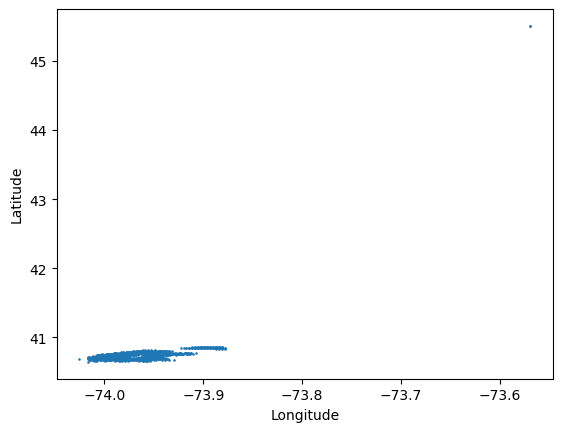

In [11]:
#plot initial coordinates
plot_map(coords)

Notice the outlier in Montréal, Canada, remove it from plot (and later df) to see other data.

In [12]:
# get rid of outlier longitude > -73.6
coords = coords[coords[:,0] < -73.6]
print(coords.shape) #shape is 917 here as it still includes the grid anomalies

(917, 2)


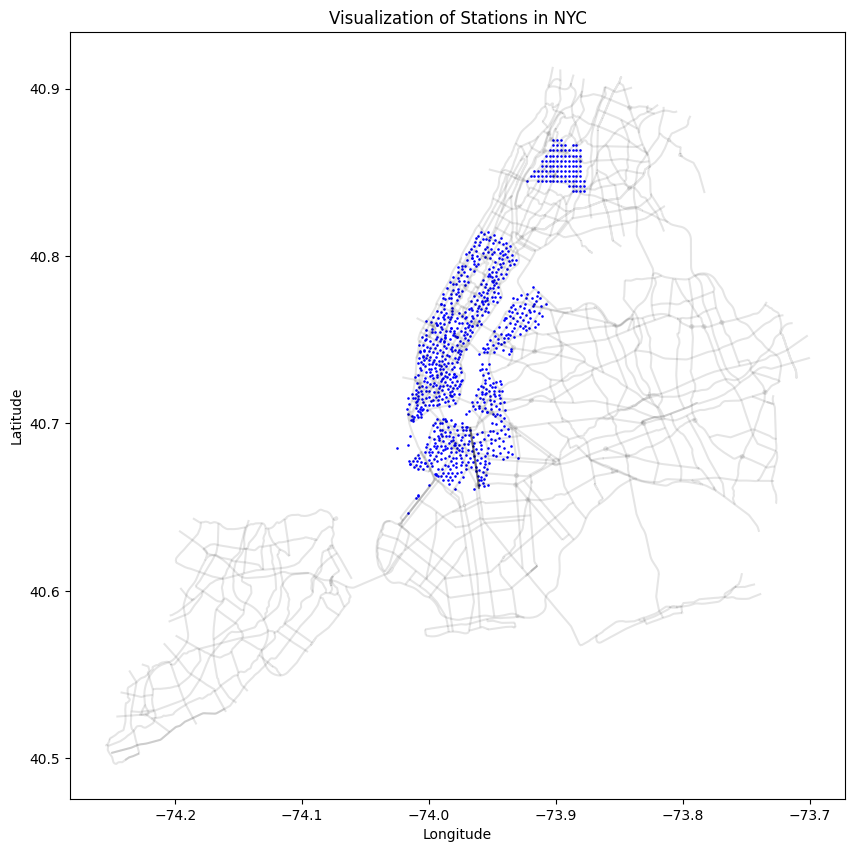

In [13]:
plot_map_with_background(coords)

Stations are located in NYC. The regular grid in the top right are identified as NANs so that data is removed from df.

In [14]:
# print where NaN is in data frame df, get rid of NaN (= get rid of gridded outliers), create copy of data frame df and start station coordinates
print(df.isnull().sum())
df = df[~np.isnan(df['start_station_id'])]
df = df[~np.isnan(df['end_station_id'])]
# get rid of Canada outlier
df = df[df['start_station_longitude'] < -73.6]
df = df[df['end_station_longitude'] < -73.6]
# get latitude and longitude
coords_start = df[['start_station_longitude','start_station_latitude']].values
coords_start = np.unique(coords_start, axis=0)
coords_start_copy = coords_start.copy()
print(coords.shape)

tripduration                  0
starttime                     0
stoptime                      0
start_station_id           2497
start_station_latitude        0
start_station_longitude       0
end_station_id             2497
end_station_latitude          0
end_station_longitude         0
bikeid                        0
birth_year                    0
gender                        0
usertype_Subscriber           0
dtype: int64
(917, 2)


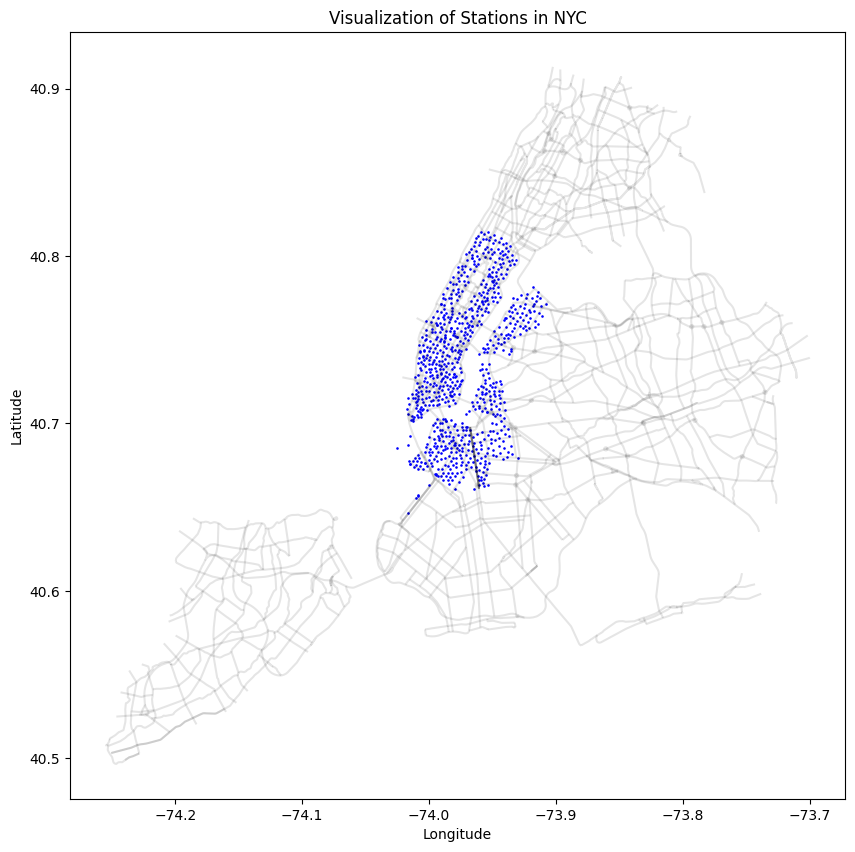

In [15]:
plot_map_with_background(coords_start)

In [16]:
# amount of distinct end stations does not match amount of start stations as seen from comparing shapes, create copy of end station coordinates.
coords_end = df[['end_station_longitude','end_station_latitude']].values
coords_end = np.unique(coords_end, axis=0)
print(f' end stations: {coords_end.shape}')
print(f' start stations: {coords_start.shape}')
coords_end_copy = coords_end.copy()


 end stations: (849, 2)
 start stations: (817, 2)


Notice more stations in end than start, same is seen in plots.

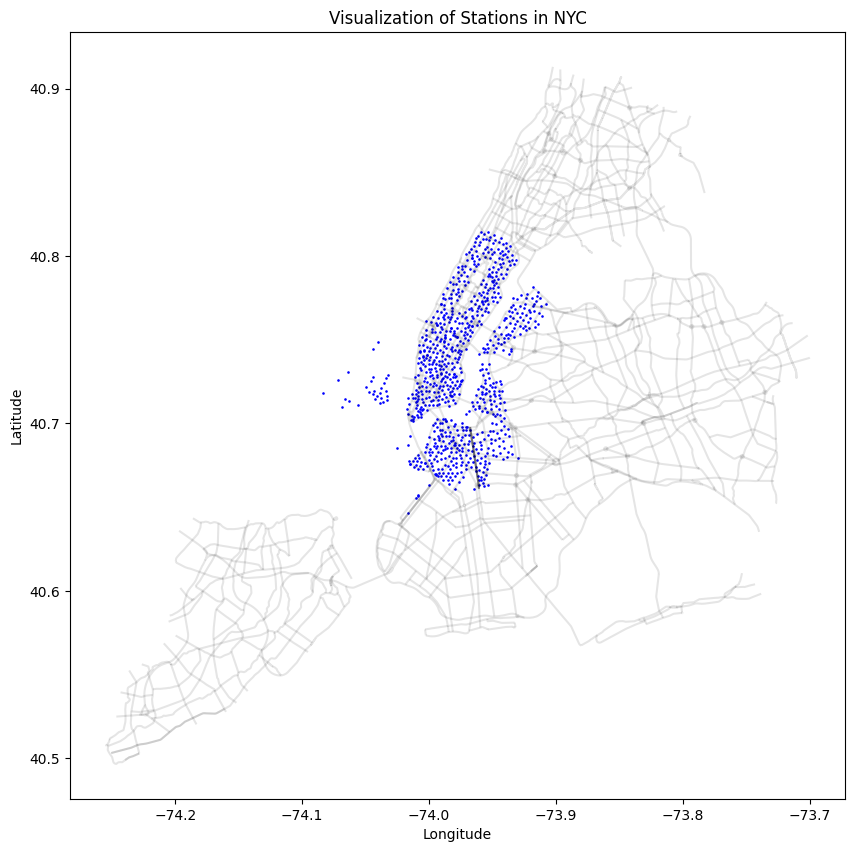

In [17]:
plot_map_with_background(coords_end)

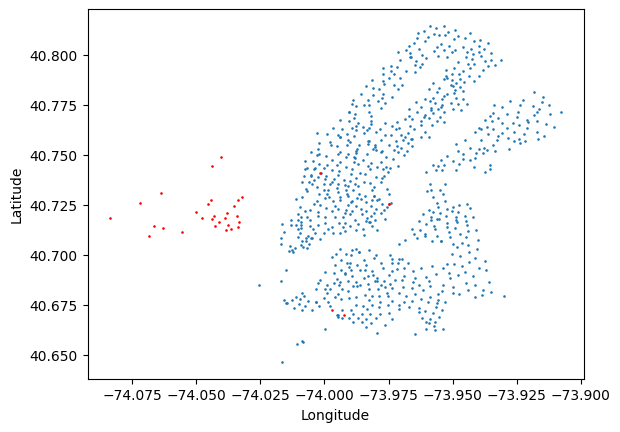

In [18]:
# highlight the end stations that are not in the start stations on the map of all end stations
coords_end_not_in_start = []
for i in range(len(coords_end)):
    if coords_end[i] not in coords_start:
        coords_end_not_in_start.append(coords_end[i])
coords_end_not_in_start = np.array(coords_end_not_in_start)
plt.scatter(coords_start[:,0], coords_start[:,1], s=0.75)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.scatter(coords_end_not_in_start[:,0], coords_end_not_in_start[:,1], s=0.75, c='r')
plt.show()

Red points show end stations not included in start stations. Since there are more end stations than start stations and all start stations are also an end station, the clustering should be done using the end stations in order to cluster every station considered in the data. 

Looking at the distribution of ages.

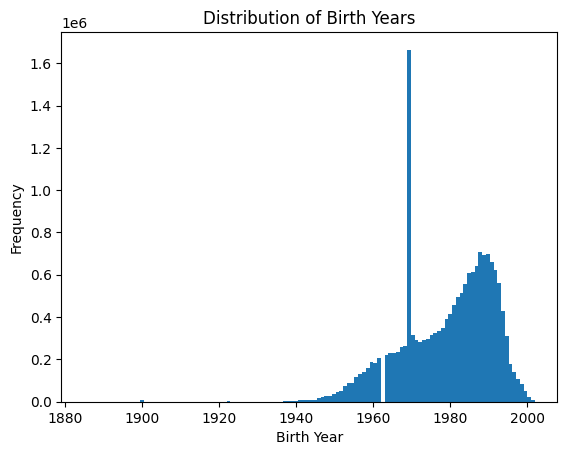

In [19]:
# plot the distribution of the ages of the users
plt.hist(df['birth_year'], bins=120)
plt.xlabel('Birth Year')
plt.ylabel('Frequency')
plt.title('Distribution of Birth Years')
plt.show()

As we can see the distribution of ages dominated by the year 1969. This could be caused by automatically assigning the birth year 1969 to the users who are not logged in. Because of that, we will not use the birth year in prediction as we have no means of incorporating this data in a meaningful way.

## Prediction Challenge Part 1
The prediction challengestarts with station clustering using sklearn library K-means algorithm with 20 clusters.

In [20]:
# import kmeans
from sklearn.cluster import KMeans

In [21]:
n_clusters = 20
random_state = 0

In [22]:
# make kmeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(coords_end) # using coords here instead of df to increase speed

C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The model is trained on coordinates instead of DataFrame to increase speed, then it is predicted to save labels on df, the model is trained on the same data as you predict the cluster for, so the cluster they belong to will be the same one as they belonged to during convergence of the K-means cluster.

After the model converges, the clusters are illustrated assigning different colours to each cluster as well as marking their centroids.


In [23]:
df['drop_label'] = kmeans.predict(df[['end_station_longitude','end_station_latitude']].values)
df['pick_label'] = kmeans.predict(df[['start_station_longitude','start_station_latitude']].values)
df_copy2 = df.copy()


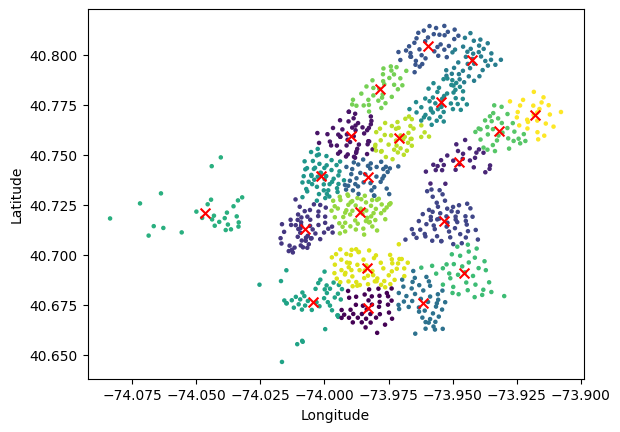

In [24]:
# plot with cluster colour & centriods
plt.scatter(coords_end[:,0], coords_end[:,1], c=kmeans.labels_, s=5)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', marker="x", s=50)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

In [25]:
# run this cell for coords of starting stations and the fully edited dataframe
coords_start = coords_start_copy.copy()
coords_end = coords_end_copy.copy()
df = df_copy2.copy()
print(df.shape) # to check if no data loss, should be (17548339, 15)
df.head()


(17545760, 15)


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender,usertype_Subscriber,drop_label,pick_label
trip_id,,,,,,,,,,,,,,,
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1992,1,1,1,1
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1969,1,1,1,1
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1956,1,1,1,1
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1974,1,1,1,1
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1992,1,1,15,1


## Prediction Challenge Part 2

For the prediction challenge posed in part 2 of the assignment, we will create a prediction model for all clusters, for both departures and arrivals, and for both weekday and weekend. (Appendix A1)

We will also only train models for all clusters except the cluster where only arrivals have been observed, the cluster west of all other clusters in the figure above. (Appendix A2)

In [26]:
# Copy full dataset so that you dont have to rerun the code from the top.
df = df_copy2.copy()

# Pick the clusters with the most amount of data, hence we leave the cluster with only arrivals out.
n = 19 
largest_cluster = df['drop_label'].value_counts().nlargest(n).index[:n]
print(largest_cluster)

# Get all data entries belonging to the largest clusters only 
df = df[df['pick_label'].isin(largest_cluster)]


Index([10, 1, 16, 6, 3, 17, 18, 4, 15, 9, 5, 0, 7, 11, 8, 13, 2, 14, 19], dtype='int32', name='drop_label')


Make dummies for all categorical gender variables, do not leave one out as it will be more convenient for the following step.

In [27]:
df = pd.get_dummies(df, columns=['gender'], dtype=int)


Following code cell splits up the dataset into departures and arrivals data, which will allow us to make prediction models for both separately, which is necessary for part 3. (Appendix A3)

In [28]:
# Extract relevant data features for prediction.  
df_departures = df[['starttime', 'pick_label', 'tripduration', 'gender_0', 'gender_1', 'gender_2', 'usertype_Subscriber']].copy()
df_arrivals = df[['stoptime', 'drop_label', 'tripduration', 'gender_0', 'gender_1', 'gender_2', 'usertype_Subscriber']].copy()

# Rename label columns
df_departures.rename(columns={'pick_label':'label'}, inplace=True)
df_arrivals.rename(columns={'drop_label':'label'}, inplace=True)

# Extract date and time components
def extract_date_time_components(df, time_column):
    df['hour'] = df[time_column].dt.hour
    df['date'] = df[time_column].dt.date
    df['month'] = df[time_column].dt.month
    df.drop(columns=[time_column], inplace=True)

extract_date_time_components(df_departures, 'starttime')
extract_date_time_components(df_arrivals, 'stoptime')

# Remove trip_id index, lost it's meaning
df_departures.reset_index(drop=True, inplace=True)
df_arrivals.reset_index(drop=True, inplace=True)

# Function to split data into train and test based on month requirement.
def split_train_test(df):
    df_train = df[df['month'] < 11]
    df_test = df[df['month'] >= 11]
    return df_train, df_test


# Count the number of rows with the same label, hour, date and save it in a new column. Function to compute the amount of departures/arrivals (depending on the dataset you look at)
# for each label, hour, date.
def count(df):
    counts = df.groupby(['label', 'hour', 'date']).size().reset_index(name='count')
    print(counts)
    df = df.merge(counts, on=['label', 'hour', 'date'], how='left')
    return df

# Find the average trip duration for each label, hour, date and save it in a new column
def avg_tripduration(df):
    avg_tripduration = df.groupby(['label', 'hour', 'date'])['tripduration'].mean().reset_index(name='avg_tripduration')
    print(avg_tripduration)
    df = df.merge(avg_tripduration, on=['label', 'hour', 'date'], how='left')
    return df

# Find the percentage of males, females, and unknowns for each label, hour, date and save it in a new column
def avg_gender(df):
    percentage_gender_0 = df.groupby(['label', 'hour', 'date'])['gender_0'].mean().reset_index(name = 'percentage_gender_0')
    percentage_gender_1 = df.groupby(['label', 'hour', 'date'])['gender_1'].mean().reset_index(name = 'percentage_gender_1')
    percentage_gender_2 = df.groupby(['label', 'hour', 'date'])['gender_2'].mean().reset_index(name = 'percentage_gender_2')
    print(percentage_gender_0)
    print(percentage_gender_1)
    print(percentage_gender_2)
    df = df.merge(percentage_gender_0, on=['label', 'hour', 'date'], how='left')
    df = df.merge(percentage_gender_1, on=['label', 'hour', 'date'], how='left')
    df = df.merge(percentage_gender_2, on=['label', 'hour', 'date'], how='left')
    return df
    
# Split data into train and test set
df_departures_train, df_departures_test = split_train_test(df_departures)
df_arrivals_train, df_arrivals_test = split_train_test(df_arrivals)

# Count the number of rows with the same label, hour, date and save it in a new column
df_departures_train = count(df_departures_train)
df_departures_test = count(df_departures_test)
df_arrivals_train = count(df_arrivals_train)
df_arrivals_test = count(df_arrivals_test)

# Find the average trip duration for each label, hour, date and save it in a new column
df_departures_train = avg_tripduration(df_departures_train)
df_departures_test = avg_tripduration(df_departures_test)
df_arrivals_train = avg_tripduration(df_arrivals_train)
df_arrivals_test = avg_tripduration(df_arrivals_test)

# Find the average gender for each label, hour, date and save it in a new column
df_departures_train = avg_gender(df_departures_train)
df_departures_test = avg_gender(df_departures_test)
df_arrivals_train = avg_gender(df_arrivals_train)
df_arrivals_test = avg_gender(df_arrivals_test)

        label  hour        date  count
0           0     0  2018-01-01      3
1           0     0  2018-01-03      1
2           0     0  2018-01-04      2
3           0     0  2018-01-06      1
4           0     0  2018-01-09      7
...       ...   ...         ...    ...
133814     19    23  2018-10-27      5
133815     19    23  2018-10-28      2
133816     19    23  2018-10-29     10
133817     19    23  2018-10-30     10
133818     19    23  2018-10-31     11

[133819 rows x 4 columns]
       label  hour        date  count
0          0     0  2018-11-01     13
1          0     0  2018-11-02     16
2          0     0  2018-11-03     16
3          0     0  2018-11-04     17
4          0     0  2018-11-05      5
...      ...   ...         ...    ...
26878     19    23  2018-12-26      4
26879     19    23  2018-12-27      4
26880     19    23  2018-12-28     10
26881     19    23  2018-12-29      4
26882     19    23  2018-12-30      3

[26883 rows x 4 columns]
        label  hour    

Drop all unnecessary features, (Appendix A4). Sort data and drop all duplicate entries that remain after the groupby function is applied. 

In [29]:
# Drop month, yielded poor prediction quality
df_departures_train.drop(columns=['month'], inplace=True)
df_departures_test.drop(columns=['month'], inplace=True)
df_arrivals_train.drop(columns=['month'], inplace=True)
df_arrivals_test.drop(columns=['month'], inplace=True)

# Drop tripduration, we will predict per label, hour, date, not per trip, so we only need avg_tripduration
df_departures_train.drop(columns=['tripduration'], inplace=True)
df_departures_test.drop(columns=['tripduration'], inplace=True)
df_arrivals_train.drop(columns=['tripduration'], inplace=True)
df_arrivals_test.drop(columns=['tripduration'], inplace=True)

# Drop gender_0, gender_1 and gender_2 dummies, we will predict per label, hour, date, not per trip, so we only need the avg_gender.
df_departures_train.drop(columns=['gender_0', 'gender_1', 'gender_2'], inplace=True)
df_departures_test.drop(columns=['gender_0', 'gender_1', 'gender_2'], inplace=True)
df_arrivals_train.drop(columns=['gender_0', 'gender_1', 'gender_2'], inplace=True)
df_arrivals_test.drop(columns=['gender_0', 'gender_1', 'gender_2'], inplace=True)

# Drop usertype_Subscriber, we have no aggregated data for this. We could have made a column with the percentage of subscribers per label, hour, date, but we decided to drop it for simplicity. 
# Later on we will also get rid of avg_tripduration since the model achieved nearly the same accuracy without it. Hence we decided adding these features would not yield improvement, if any. 
df_departures_train.drop(columns=['usertype_Subscriber'], inplace=True)
df_departures_test.drop(columns=['usertype_Subscriber'], inplace=True)
df_arrivals_train.drop(columns=['usertype_Subscriber'], inplace=True)
df_arrivals_test.drop(columns=['usertype_Subscriber'], inplace=True)

# Sort data by hour, date
df_departures_train.sort_values(by=['date', 'hour'], inplace=True)
df_departures_test.sort_values(by=['date', 'hour'], inplace=True)
df_arrivals_train.sort_values(by=['date', 'hour'], inplace=True)
df_arrivals_test.sort_values(by=['date', 'hour'], inplace=True)

# Keep unique rows
df_departures_train.drop_duplicates(inplace=True)
df_departures_test.drop_duplicates(inplace=True)
df_arrivals_train.drop_duplicates(inplace=True)
df_arrivals_test.drop_duplicates(inplace=True)


Check if the data is now: sorted correctly, grouped correctly, has the correct variables, had no duplicates, has data for all clusters. Check sizes as well.

In [30]:
df_departures_train.head(20)

,label,hour,date,count,avg_tripduration,percentage_gender_0,percentage_gender_1,percentage_gender_2
6559,10,0,2018-01-01,15,504.666667,0.000000,0.733333,0.266667
10013,3,0,2018-01-01,11,628.909091,0.000000,0.727273,0.272727
82527,6,0,2018-01-01,16,634.062500,0.000000,0.750000,0.250000
87932,16,0,2018-01-01,14,828.071429,0.000000,0.857143,0.142857
122114,18,0,2018-01-01,3,304.000000,0.000000,0.666667,0.333333
170475,7,0,2018-01-01,4,574.250000,0.000000,0.750000,0.250000
262500,1,0,2018-01-01,15,890.266667,0.400000,0.600000,0.000000
284913,4,0,2018-01-01,9,754.666667,0.000000,0.777778,0.222222
397584,17,0,2018-01-01,1,1429.000000,0.000000,1.000000,0.000000
467486,13,0,2018-01-01,3,700.666667,0.000000,1.000000,0.000000


In [31]:
df_departures_test.head(20)

,label,hour,date,count,avg_tripduration,percentage_gender_0,percentage_gender_1,percentage_gender_2
0,19,0,2018-11-01,8,274.250000,0.000000,0.625000,0.375000
1,10,0,2018-11-01,88,744.965909,0.056818,0.806818,0.136364
2,0,0,2018-11-01,13,735.538462,0.000000,0.769231,0.230769
3,9,0,2018-11-01,18,787.777778,0.055556,0.888889,0.055556
4,6,0,2018-11-01,72,690.513889,0.041667,0.805556,0.152778
5,3,0,2018-11-01,22,950.272727,0.000000,0.863636,0.136364
6,7,0,2018-11-01,14,562.714286,0.000000,0.785714,0.214286
7,17,0,2018-11-01,16,797.375000,0.000000,0.875000,0.125000
10,8,0,2018-11-01,11,446.090909,0.000000,0.818182,0.181818
11,1,0,2018-11-01,53,798.811321,0.018868,0.886792,0.094340


In [32]:
df_arrivals_train.head()

,label,hour,date,count,avg_tripduration,percentage_gender_0,percentage_gender_1,percentage_gender_2
6559,6,0,2018-01-01,15,457.800000,0.00,0.666667,0.333333
10013,3,0,2018-01-01,5,283.000000,0.00,1.000000,0.000000
16541,16,0,2018-01-01,11,489.727273,0.00,0.818182,0.181818
44550,10,0,2018-01-01,16,590.812500,0.25,0.625000,0.125000
122114,18,0,2018-01-01,3,421.333333,0.00,1.000000,0.000000


In [33]:
df_arrivals_test.head()

,label,hour,date,count,avg_tripduration,percentage_gender_0,percentage_gender_1,percentage_gender_2
34,5,0,2018-11-01,23,2186.391304,0.043478,0.739130,0.217391
36,9,0,2018-11-01,15,2733.266667,0.066667,0.800000,0.133333
41,16,0,2018-11-01,98,972.255102,0.122449,0.642857,0.234694
45,11,0,2018-11-01,12,3165.416667,0.083333,0.500000,0.416667
49,13,0,2018-11-01,23,1150.478261,0.130435,0.739130,0.130435


In [34]:
#check sizes 
print(df_departures_train.shape)
print(df_departures_test.shape)
print(df_arrivals_train.shape)
print(df_arrivals_test.shape)

(133819, 8)
(26883, 8)
(134520, 8)
(26994, 8)


The data is additionally split per cluster since that is necessary for training a model per cluster. From now on, the code gets intuitively complex ;-)

In [35]:
# Split data per label, n was the amount of largest clusters you desired. Note that in this step, we sort of "relabel" the clusters. The largest cluster with label x will get a new "index" 0.
# To keep track of which cluster is which, we will have to convert back during visualization.
for i in range(n):
    globals()['df_departures_train_{}'.format(i)] = df_departures_train[df_departures_train['label'] == largest_cluster[i]]
    globals()['df_departures_test_{}'.format(i)] = df_departures_test[df_departures_test['label'] == largest_cluster[i]]
    globals()['df_arrivals_train_{}'.format(i)] = df_arrivals_train[df_arrivals_train['label'] == largest_cluster[i]]
    globals()['df_arrivals_test_{}'.format(i)] = df_arrivals_test[df_arrivals_test['label'] == largest_cluster[i]]

### Shape check 1:

In [36]:
for i in range(n):
    print("Shapes of cluster {}:".format(i))
    print(globals()['df_departures_train_{}'.format(i)].shape)
    print(globals()['df_departures_test_{}'.format(i)].shape)
    print(globals()['df_arrivals_train_{}'.format(i)].shape)
    print(globals()['df_arrivals_test_{}'.format(i)].shape)
    print("")

# In the remaining dataset, we should see properly sorted data on date and hour, and only one cluster label. Note that the cluster label does not match the index of the variable, and that is due 
# to the sorting of the clusters according to size we performed at the start of part 2 and the step above.
df_departures_train_0.head(30)

Shapes of cluster 0:
(7266, 8)
(1464, 8)
(7269, 8)
(1464, 8)

Shapes of cluster 1:
(7265, 8)
(1463, 8)
(7273, 8)
(1462, 8)

Shapes of cluster 2:
(7271, 8)
(1464, 8)
(7279, 8)
(1464, 8)

Shapes of cluster 3:
(7254, 8)
(1462, 8)
(7265, 8)
(1463, 8)

Shapes of cluster 4:
(7224, 8)
(1455, 8)
(7245, 8)
(1459, 8)

Shapes of cluster 5:
(7174, 8)
(1442, 8)
(7198, 8)
(1447, 8)

Shapes of cluster 6:
(7222, 8)
(1444, 8)
(7219, 8)
(1444, 8)

Shapes of cluster 7:
(7173, 8)
(1440, 8)
(7181, 8)
(1446, 8)

Shapes of cluster 8:
(7145, 8)
(1423, 8)
(7146, 8)
(1435, 8)

Shapes of cluster 9:
(7100, 8)
(1432, 8)
(7127, 8)
(1441, 8)

Shapes of cluster 10:
(7064, 8)
(1421, 8)
(7104, 8)
(1419, 8)

Shapes of cluster 11:
(6931, 8)
(1386, 8)
(6963, 8)
(1413, 8)

Shapes of cluster 12:
(6965, 8)
(1403, 8)
(7002, 8)
(1410, 8)

Shapes of cluster 13:
(6664, 8)
(1334, 8)
(6803, 8)
(1331, 8)

Shapes of cluster 14:
(7013, 8)
(1413, 8)
(7079, 8)
(1423, 8)

Shapes of cluster 15:
(6966, 8)
(1391, 8)
(7028, 8)
(1406, 8)

Sh

,label,hour,date,count,avg_tripduration,percentage_gender_0,percentage_gender_1,percentage_gender_2
6559,10,0,2018-01-01,15,504.666667,0.000000,0.733333,0.266667
4183,10,1,2018-01-01,27,677.222222,0.000000,0.777778,0.222222
16542,10,2,2018-01-01,11,612.909091,0.000000,0.909091,0.090909
183586,10,3,2018-01-01,10,754.800000,0.000000,0.900000,0.100000
31379,10,4,2018-01-01,5,494.000000,0.000000,0.600000,0.400000
278995,10,5,2018-01-01,2,1103.000000,0.000000,1.000000,0.000000
172699,10,6,2018-01-01,3,1108.000000,0.000000,0.666667,0.333333
134483,10,7,2018-01-01,5,416.000000,0.000000,0.600000,0.400000
6561,10,8,2018-01-01,14,503.928571,0.000000,0.857143,0.142857
4185,10,9,2018-01-01,17,159262.882353,0.117647,0.647059,0.235294


For the departures dataset, we appear to be missing some datapoints. In 304 days (amount of days in the period from January to October) there are 7296 hours, however from analyzing the shapes of the different cluster datasets, we never actually have this amount. (Appendix A5)

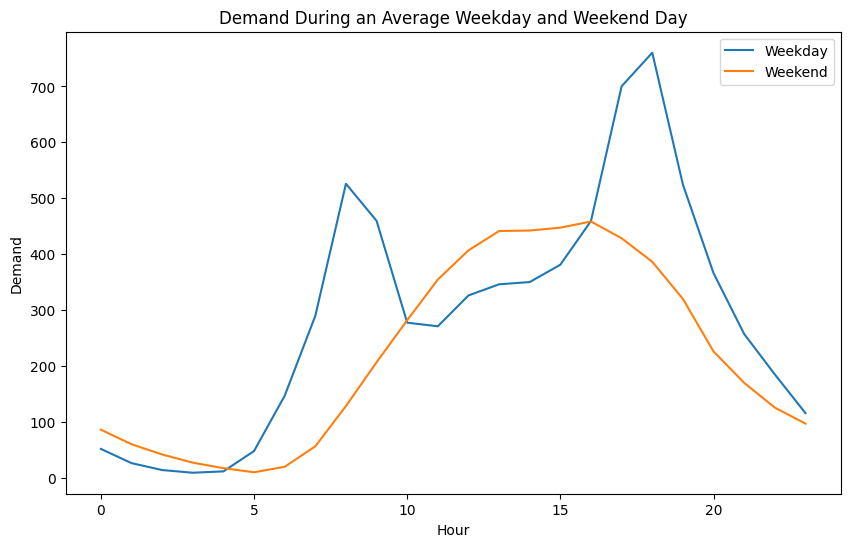

In [37]:

df_weekday = df_departures_train_0[df_departures_train_0['date'].apply(lambda x: x.weekday() < 5)]
df_weekend = df_departures_train_0[df_departures_train_0['date'].apply(lambda x: x.weekday() >= 5)]

# overlay the data as line plots
plt.figure(figsize=(10, 6))
df_weekday.groupby('hour')['count'].mean().plot(kind='line')
df_weekend.groupby('hour')['count'].mean().plot(kind='line')
plt.xlabel('Hour')
plt.ylabel('Demand')
plt.title('Demand During an Average Weekday and Weekend Day')
plt.legend(['Weekday', 'Weekend'])
plt.show()


Notice different hourly trends in pickups depending on if it's a weekend or weekday.

Use the Build lagged features code provided from stackoverflow to give each sub-dataset columns with lagged departures/arrivals (depending on the dataset you look at) counts. This yields better prediction.

**Note that from now on, when departures/arrivals is used, we imply that, depending on the dataset used, you use data on departures or data on arrivals.** 

In [38]:
def buildLaggedFeatures(s,columns, lag=24,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

In [39]:
# Add lag to all cluster count column. highly advised for best prediction quality to choose 24 for both, however different lags can be chosen as well, all set up parametrically.
n_lag_dep_train = 24
n_lag_arr_train = 24

for i in range(n):
    globals()['departures_train_lagged{}'.format(i)] = buildLaggedFeatures(globals()['df_departures_train_{}'.format(i)], ['count'], lag=n_lag_dep_train)
    globals()['arrivals_train_lagged{}'.format(i)] = buildLaggedFeatures(globals()['df_arrivals_train_{}'.format(i)], ['count'], lag=n_lag_arr_train)

# Do same to test data
n_lag_dep_test = n_lag_dep_train  #have to be the same for models to work, as otherwise you have a model fitted to taking in 30 features and then your test has 100...
n_lag_arr_test = n_lag_arr_train

for i in range(n):
    globals()['departures_test_lagged{}'.format(i)] = buildLaggedFeatures(globals()['df_departures_test_{}'.format(i)], ['count'], lag=n_lag_dep_test)
    globals()['arrivals_test_lagged{}'.format(i)] = buildLaggedFeatures(globals()['df_arrivals_test_{}'.format(i)], ['count'], lag=n_lag_arr_test)



# Add lag to all cluster avg_tripduration column:
n_lag_dep_train = 24
n_lag_arr_train = 24

for i in range(n):
    globals()['departures_train_lagged_tripduration{}'.format(i)] = buildLaggedFeatures(globals()['df_departures_train_{}'.format(i)], ['avg_tripduration'], lag=n_lag_dep_train)
    globals()['arrivals_train_lagged_tripduration{}'.format(i)] = buildLaggedFeatures(globals()['df_arrivals_test_{}'.format(i)], ['avg_tripduration'], lag=n_lag_arr_train)

# Do same to test data
n_lag_dep_test = n_lag_dep_train  #have to be the same for models to work, as otherwise you have a model fitted to taking in 30 features and then your test has 100...
n_lag_arr_test = n_lag_arr_train

for i in range(n):
    globals()['departures_test_lagged_tripduration{}'.format(i)] = buildLaggedFeatures(globals()['df_departures_test_{}'.format(i)], ['avg_tripduration'], lag=n_lag_dep_test)
    globals()['arrivals_test_lagged_tripduration{}'.format(i)] = buildLaggedFeatures(globals()['df_arrivals_test_{}'.format(i)], ['avg_tripduration'], lag=n_lag_arr_test)



# Why lag 24? we have tried a tonne of combinations with different lag and different degree of poly added, but for all lag, degree 2 came out on top, and for degree 2, lag 24 gave by far the best 
# performance on all models. For lag 22 I got a >0.6 for a cluster with usual R^2 ~0.59, but it came with the cost of quite a bit of performance loss in the other models, while the model for 
# the poor performing cluster would only increase R^2 by 0.01 or so. So we decided to go with lag 24 for all models.

Convert dates to datetime, in order to extract the "day of week" that date belongs to when building up the input data. 

In [40]:
globals()['departures_train_lagged{}'.format(i)]['date'] = pd.to_datetime(globals()['departures_train_lagged{}'.format(i)]['date'])
globals()['departures_test_lagged{}'.format(i)]['date'] = pd.to_datetime(globals()['departures_test_lagged{}'.format(i)]['date'])
globals()['arrivals_train_lagged{}'.format(i)]['date'] = pd.to_datetime(globals()['arrivals_train_lagged{}'.format(i)]['date'])
globals()['arrivals_test_lagged{}'.format(i)]['date'] = pd.to_datetime(globals()['arrivals_test_lagged{}'.format(i)]['date'])

We will now create the skeleton for the input dataset of our model. More features based on this skeleton will be added later. An important note has to be made, provided in (Appendix A6). All features included in the dataset have been proven to yield the best predictions possible while keeping the input to the model limited (Appendix A7). To keep variable naming intuitive, the input data to our model will get the x variable assigned to it. The output will be assigned the y variable (later on).

In [41]:
# For all clusters training data: use np.c_ to concatenate. 
for i in range(n):
    globals()['x_departures_train_lagged{}'.format(i)] = np.c_[np.ones(len(globals()['departures_train_lagged{}'.format(i)]))]
    globals()['x_arrivals_train_lagged{}'.format(i)] = np.c_[np.ones(len(globals()['arrivals_train_lagged{}'.format(i)]))]

    # Add a column with the "day of week" to the x_departures_train variable. 
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())]

    # convert "day of week" to dummy variables since it is a categorical, 0 = is_monday, 1 = is_tuesday, 2 = is_wednesday, 3 = is_thursday, 4 = is_friday, 5 = is_saturday, 6 = is_sunday
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 0 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 1 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 2 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 3 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 4 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 5 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 6 else 0)]

    # Add the hour column to the x_departures_train variable
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['hour']]

    # Add a column with the "day of week" to the x_arrivals_train variable.
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())]

    # Convert "day of week" to dummy variables, 0 = is_monday, 1 = is_tuesday, 2 = is_wednesday, 3 = is_thursday, 4 = is_friday, 5 = is_saturday, 6 = is_sunday
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 0 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 1 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 2 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 3 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 4 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 5 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 6 else 0)]
    
    # Add the hour column to the x_arrivals_train variable
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['hour']]

    # Add all the lagged counts to the x_train variable
    for j in range(1, n_lag_dep_train+1):
        globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['count_lag{}'.format(j)]]
    for j in range(1, n_lag_arr_train+1):
        globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['count_lag{}'.format(j)]]
    
    


# perform the same steps for the test data   
    globals()['x_departures_test_lagged{}'.format(i)] = np.c_[np.ones(len(globals()['departures_test_lagged{}'.format(i)]))]
    globals()['x_arrivals_test_lagged{}'.format(i)] = np.c_[np.ones(len(globals()['arrivals_test_lagged{}'.format(i)]))]
    
    # add a column with the "day of week" to the x_departures_test variable.
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())]

    #convert "day of week" to dummy variables, 0 = is_monday, 1 = is_tuesday, 2 = is_wednesday, 3 = is_thursday, 4 = is_friday, 5 = is_saturday, 6 = is_sunday
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 0 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 1 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 2 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 3 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 4 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 5 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 6 else 0)]

    #add the hour column to the x_departures_test variable
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['hour']]

    # add a column with the "day of week" to the x_arrivals_train variable.
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())]

    #convert "day of week" to dummy variables, 0 = is_monday, 1 = is_tuesday, 2 = is_wednesday, 3 = is_thursday, 4 = is_friday, 5 = is_saturday, 6 = is_sunday
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 0 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 1 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 2 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 3 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 4 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 5 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 6 else 0)]
    
    # Add the hour column to the x_arrivals_test variable
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['hour']]
    
    #also add all the lagged counts to the x_test variable
    for j in range(1, n_lag_dep_test+1):
        globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['count_lag{}'.format(j)]]
    for j in range(1, n_lag_arr_test+1):
        globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['count_lag{}'.format(j)]]

Check for the correctness of the code. The first column should contain all ones, the second includes the "day of week" as a continuous variable (0-6), the next 7 contain the weekday as dummy variables, the tenth column is the hour, and the final 24 columns contain the lagged departures/arrivals counts. Whether the lagged counts have been added correctly can be answered by confirming that the value along the -45⁰ diagonal (CCW positive) is constant for the final 24 columns. 

In [42]:
pd.DataFrame(globals()['x_departures_train_lagged{}'.format(0)]).head(20)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,14.0,5.0,3.0,2.0,5.0,10.0,11.0,27.0,15.0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,30.0,17.0,14.0,5.0,3.0,2.0,5.0,10.0,11.0,27.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,52.0,30.0,17.0,14.0,5.0,3.0,2.0,5.0,10.0,11.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,...,42.0,52.0,30.0,17.0,14.0,5.0,3.0,2.0,5.0,10.0
4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,...,33.0,42.0,52.0,30.0,17.0,14.0,5.0,3.0,2.0,5.0
5,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,...,42.0,33.0,42.0,52.0,30.0,17.0,14.0,5.0,3.0,2.0
6,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,...,49.0,42.0,33.0,42.0,52.0,30.0,17.0,14.0,5.0,3.0
7,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,...,55.0,49.0,42.0,33.0,42.0,52.0,30.0,17.0,14.0,5.0
8,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,...,51.0,55.0,49.0,42.0,33.0,42.0,52.0,30.0,17.0,14.0
9,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,...,43.0,51.0,55.0,49.0,42.0,33.0,42.0,52.0,30.0,17.0


### Shape check 2:

In [43]:
for i in range(n):
    print("Shapes of cluster {}:".format(i))
    print(globals()['x_departures_train_lagged{}'.format(i)].shape)
    print(globals()['x_departures_test_lagged{}'.format(i)].shape)
    print(globals()['x_arrivals_train_lagged{}'.format(i)].shape)
    print(globals()['x_arrivals_test_lagged{}'.format(i)].shape)
    print(" ")

pd.DataFrame(departures_train_lagged0).head()

Shapes of cluster 0:
(7242, 34)
(1440, 34)
(7245, 34)
(1440, 34)
 
Shapes of cluster 1:
(7241, 34)
(1439, 34)
(7249, 34)
(1438, 34)
 
Shapes of cluster 2:
(7247, 34)
(1440, 34)
(7255, 34)
(1440, 34)
 
Shapes of cluster 3:
(7230, 34)
(1438, 34)
(7241, 34)
(1439, 34)
 
Shapes of cluster 4:
(7200, 34)
(1431, 34)
(7221, 34)
(1435, 34)
 
Shapes of cluster 5:
(7150, 34)
(1418, 34)
(7174, 34)
(1423, 34)
 
Shapes of cluster 6:
(7198, 34)
(1420, 34)
(7195, 34)
(1420, 34)
 
Shapes of cluster 7:
(7149, 34)
(1416, 34)
(7157, 34)
(1422, 34)
 
Shapes of cluster 8:
(7121, 34)
(1399, 34)
(7122, 34)
(1411, 34)
 
Shapes of cluster 9:
(7076, 34)
(1408, 34)
(7103, 34)
(1417, 34)
 
Shapes of cluster 10:
(7040, 34)
(1397, 34)
(7080, 34)
(1395, 34)
 
Shapes of cluster 11:
(6907, 34)
(1362, 34)
(6939, 34)
(1389, 34)
 
Shapes of cluster 12:
(6941, 34)
(1379, 34)
(6978, 34)
(1386, 34)
 
Shapes of cluster 13:
(6640, 34)
(1310, 34)
(6779, 34)
(1307, 34)
 
Shapes of cluster 14:
(6989, 34)
(1389, 34)
(7055, 34)
(13

,label,hour,date,count,avg_tripduration,percentage_gender_0,percentage_gender_1,percentage_gender_2,count_lag1,count_lag2,...,count_lag15,count_lag16,count_lag17,count_lag18,count_lag19,count_lag20,count_lag21,count_lag22,count_lag23,count_lag24
4200,10,0,2018-01-02,5,353.600000,0.0,0.8,0.2,8.0,13.0,...,17.0,14.0,5.0,3.0,2.0,5.0,10.0,11.0,27.0,15.0
78991,10,1,2018-01-02,5,474.800000,0.2,0.6,0.2,5.0,8.0,...,30.0,17.0,14.0,5.0,3.0,2.0,5.0,10.0,11.0,27.0
147307,10,2,2018-01-02,3,1291.666667,0.0,1.0,0.0,5.0,5.0,...,52.0,30.0,17.0,14.0,5.0,3.0,2.0,5.0,10.0,11.0
280884,10,3,2018-01-02,2,634.500000,0.0,1.0,0.0,3.0,5.0,...,42.0,52.0,30.0,17.0,14.0,5.0,3.0,2.0,5.0,10.0
16557,10,4,2018-01-02,4,229.500000,0.0,1.0,0.0,2.0,3.0,...,33.0,42.0,52.0,30.0,17.0,14.0,5.0,3.0,2.0,5.0


Compared to shape check 1, each of the cluster split datasets has exactly 30 datpoints less. This was induced by applying the lagged build-up function on the dataset. (Appendix A8) 

The amount of columns should, for all datasets, add up to 10 + n_lag. (Appendix A9)

Adding more features for better prediction: 
- polynomial of degree n applied to hour and lag counts. 
- sine of hour
- cosine of hour

In [44]:
def add_polynomial(x_data, n):
    x_data_poly = x_data.copy()
    for i in range(2, n+1):
        x_data_poly = np.concatenate((x_data_poly, np.power(x_data[:,9:], i)), axis=1)
    return x_data_poly
# The reason for not applying the poly on the entire data is important: otherwise we also apply it on the first column with all ones, and the "day of week" dummy variables column. Applying degree n on
# either of these columns adds no meaning to the input data and will thus be avoided.

# Add sine to hour
def add_sine(x_data):
    x_data_sine = x_data.copy()
    x_data_sine = np.concatenate((x_data_sine, np.sin(x_data)), axis = 1)
    return x_data_sine

# Add cossine to hour
def add_cosine(x_data):
    x_data_cosine = x_data.copy()
    x_data_cosine = np.concatenate((x_data_cosine, np.cos(x_data)), axis = 1)
    return x_data_cosine

In [45]:
# Add polynomial features to all clusters input data. Degree 2 has been proven to yield best prediction performance, other degrees can be selected as well.
degree = 2
for i in range(n):
    globals()['x_departures_train_poly{}'.format(i)] = add_polynomial(globals()['x_departures_train_lagged{}'.format(i)], degree)
    globals()['x_departures_test_poly{}'.format(i)] = add_polynomial(globals()['x_departures_test_lagged{}'.format(i)], degree)
    globals()['x_arrivals_train_poly{}'.format(i)] = add_polynomial(globals()['x_arrivals_train_lagged{}'.format(i)], degree)
    globals()['x_arrivals_test_poly{}'.format(i)] = add_polynomial(globals()['x_arrivals_test_lagged{}'.format(i)], degree)

# Why degree 2? Prediction performance of the model has been evaluated for degrees 2-7, degree 2 ensured the most accurate predictions, and more specifically, for the models that did not meet 
# the 0.6 threshold, degree 2 ensured their largest possible r^2. No matter what amount of lag we used, degree 2 proved to be optimal.


In [46]:
# Apply the add_sine function on the the hour column of the input data. From data structure knowledge, the hour data is provided in the tenth column. 
for i in range(n):
    globals()['x_departures_train_sine{}'.format(i)] = np.insert(globals()['x_departures_train_poly{}'.format(i)],    9,    add_sine(globals()['x_departures_train_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_departures_test_sine{}'.format(i)] = np.insert(globals()['x_departures_test_poly{}'.format(i)],    9,    add_sine(globals()['x_departures_test_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_arrivals_train_sine{}'.format(i)] = np.insert(globals()['x_arrivals_train_poly{}'.format(i)],    9,    add_sine(globals()['x_arrivals_train_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_arrivals_test_sine{}'.format(i)] = np.insert(globals()['x_arrivals_test_poly{}'.format(i)],    9,    add_sine(globals()['x_arrivals_test_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)


# The add_sine column inserts [hour, sin(hour)] at index 9, and thus moves the original content of index 9 to index 11. This original content is the hour, which will thus be present twice in the
# dataset. We will thus delete the content of column 11 to avoid such duplicates. 
for i in range(n):
    globals()['x_departures_train_sine{}'.format(i)] = np.delete(globals()['x_departures_train_sine{}'.format(i)], 11, 1)
    globals()['x_departures_test_sine{}'.format(i)] = np.delete(globals()['x_departures_test_sine{}'.format(i)], 11, 1)
    globals()['x_arrivals_train_sine{}'.format(i)] = np.delete(globals()['x_arrivals_train_sine{}'.format(i)], 11, 1)
    globals()['x_arrivals_test_sine{}'.format(i)] = np.delete(globals()['x_arrivals_test_sine{}'.format(i)], 11, 1)


# Apply the add_cosine function on the the hour column of the input data. From data structure knowledge, the hour data is still provided in the tenth column. 
for i in range(n):
    globals()['x_departures_train_cosine_sine{}'.format(i)] = np.insert(globals()['x_departures_train_sine{}'.format(i)],    9,    add_cosine(globals()['x_departures_train_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_departures_test_cosine_sine{}'.format(i)] = np.insert(globals()['x_departures_test_sine{}'.format(i)],    9,    add_cosine(globals()['x_departures_test_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_arrivals_train_cosine_sine{}'.format(i)] = np.insert(globals()['x_arrivals_train_sine{}'.format(i)],    9,    add_cosine(globals()['x_arrivals_train_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_arrivals_test_cosine_sine{}'.format(i)] = np.insert(globals()['x_arrivals_test_sine{}'.format(i)],    9,    add_cosine(globals()['x_arrivals_test_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)

# The add_cosine column inserts [hour, cos(hour)] at index 9, and thus moves the original content of index 9 to index 11. This original content is the hour, which will thus be present twice in the
# dataset. We will thus delete the content of column 11 to avoid such duplicates. 
for i in range(n):
    globals()['x_departures_train_cosine_sine{}'.format(i)] = np.delete(globals()['x_departures_train_cosine_sine{}'.format(i)], 11, 1)
    globals()['x_departures_test_cosine_sine{}'.format(i)] = np.delete(globals()['x_departures_test_cosine_sine{}'.format(i)], 11, 1)
    globals()['x_arrivals_train_cosine_sine{}'.format(i)] = np.delete(globals()['x_arrivals_train_cosine_sine{}'.format(i)], 11, 1)
    globals()['x_arrivals_test_cosine_sine{}'.format(i)] = np.delete(globals()['x_arrivals_test_cosine_sine{}'.format(i)], 11, 1)

# Now the sine and cosine are present in the input dataset columns 10 and 9 respectively. 


Choose the features you want to use

In [47]:
# Choose which features you desire for the input data,        "poly"        <->        "poly + sine"         <->         "poly + sine + cosine"
features = "poly + sine + cosine"
if features == "poly":
    for i in range(n):
        globals()['x_departures_train{}'.format(i)] = globals()['x_departures_train_poly{}'.format(i)]
        globals()['x_departures_test{}'.format(i)] = globals()['x_departures_test_poly{}'.format(i)]
        globals()['x_arrivals_train{}'.format(i)] = globals()['x_arrivals_train_poly{}'.format(i)]
        globals()['x_arrivals_test{}'.format(i)] = globals()['x_arrivals_test_poly{}'.format(i)]
elif features == "poly + sine":
    for i in range(n):
        globals()['x_departures_train{}'.format(i)] = globals()['x_departures_train_sine{}'.format(i)]
        globals()['x_departures_test{}'.format(i)] = globals()['x_departures_test_sine{}'.format(i)]
        globals()['x_arrivals_train{}'.format(i)] = globals()['x_arrivals_train_sine{}'.format(i)]
        globals()['x_arrivals_test{}'.format(i)] = globals()['x_arrivals_test_sine{}'.format(i)]
else:
    for i in range(n):
        globals()['x_departures_train{}'.format(i)] = globals()['x_departures_train_cosine_sine{}'.format(i)]
        globals()['x_departures_test{}'.format(i)] = globals()['x_departures_test_cosine_sine{}'.format(i)]
        globals()['x_arrivals_train{}'.format(i)] = globals()['x_arrivals_train_cosine_sine{}'.format(i)]
        globals()['x_arrivals_test{}'.format(i)] = globals()['x_arrivals_test_cosine_sine{}'.format(i)]


# It is advised to choose poly + sine + cosine, as this generally yielded the best possible prediction performance of the model. 


### Shape check 3:


In [48]:
for i in range(n):
    print("Shapes of cluster {}:".format(i))
    print(globals()['x_departures_train{}'.format(i)].shape)
    print(globals()['x_departures_test{}'.format(i)].shape)
    print(globals()['x_arrivals_train{}'.format(i)].shape)
    print(globals()['x_arrivals_test{}'.format(i)].shape)
    print(" ")

Shapes of cluster 0:
(7242, 61)
(1440, 61)
(7245, 61)
(1440, 61)
 
Shapes of cluster 1:
(7241, 61)
(1439, 61)
(7249, 61)
(1438, 61)
 
Shapes of cluster 2:
(7247, 61)
(1440, 61)
(7255, 61)
(1440, 61)
 
Shapes of cluster 3:
(7230, 61)
(1438, 61)
(7241, 61)
(1439, 61)
 
Shapes of cluster 4:
(7200, 61)
(1431, 61)
(7221, 61)
(1435, 61)
 
Shapes of cluster 5:
(7150, 61)
(1418, 61)
(7174, 61)
(1423, 61)
 
Shapes of cluster 6:
(7198, 61)
(1420, 61)
(7195, 61)
(1420, 61)
 
Shapes of cluster 7:
(7149, 61)
(1416, 61)
(7157, 61)
(1422, 61)
 
Shapes of cluster 8:
(7121, 61)
(1399, 61)
(7122, 61)
(1411, 61)
 
Shapes of cluster 9:
(7076, 61)
(1408, 61)
(7103, 61)
(1417, 61)
 
Shapes of cluster 10:
(7040, 61)
(1397, 61)
(7080, 61)
(1395, 61)
 
Shapes of cluster 11:
(6907, 61)
(1362, 61)
(6939, 61)
(1389, 61)
 
Shapes of cluster 12:
(6941, 61)
(1379, 61)
(6978, 61)
(1386, 61)
 
Shapes of cluster 13:
(6640, 61)
(1310, 61)
(6779, 61)
(1307, 61)
 
Shapes of cluster 14:
(6989, 61)
(1389, 61)
(7055, 61)
(13

The length of the input datasets should not have changed since the last shape check, and it hasn't. This means our operations did not yield data loss at any stage. The amount of columns present in the input data should have changed according to the rules presented in (Appendix A10, A11, A12), and yield:

<pre>
- Poly:                       9 + poly_degree * (1 + n_lag)      (Appendix A10)
- Poly + Sine:               10 + poly_degree * (1 + n_lag)      (Appendix A11)
- Poly + Sine + Cosine:      11 + poly_degree * (1 + n_lag)      (Appendix A12)
</pre>


We will split the departures/arrivals input data into weekday and weekend data. (Appendix 13)

In [49]:
# split departures/arrivals input data into weekday and weekend departures/arrivals input data, for all clusters. The "day of week" continuous variable was stored in the second column.
if features == "poly":
    column = 1
elif features == "poly + sine":
    column = 1
else:
    column = 1


for i in range(n):
    globals()['x_departures_train_weekday{}'.format(i)] = globals()['x_departures_train{}'.format(i)][globals()['x_departures_train{}'.format(i)][:,column] < 5]
    globals()['x_departures_train_weekend{}'.format(i)] = globals()['x_departures_train{}'.format(i)][globals()['x_departures_train{}'.format(i)][:,column] > 4]
    globals()['x_departures_test_weekday{}'.format(i)] = globals()['x_departures_test{}'.format(i)][globals()['x_departures_test{}'.format(i)][:,column] < 5]
    globals()['x_departures_test_weekend{}'.format(i)] = globals()['x_departures_test{}'.format(i)][globals()['x_departures_test{}'.format(i)][:,column] > 4]
    
    globals()['x_arrivals_train_weekday{}'.format(i)] = globals()['x_arrivals_train{}'.format(i)][globals()['x_arrivals_train{}'.format(i)][:,column] < 5]
    globals()['x_arrivals_train_weekend{}'.format(i)] = globals()['x_arrivals_train{}'.format(i)][globals()['x_arrivals_train{}'.format(i)][:,column] > 4]
    globals()['x_arrivals_test_weekday{}'.format(i)] = globals()['x_arrivals_test{}'.format(i)][globals()['x_arrivals_test{}'.format(i)][:,column] < 5]
    globals()['x_arrivals_test_weekend{}'.format(i)] = globals()['x_arrivals_test{}'.format(i)][globals()['x_arrivals_test{}'.format(i)][:,column] > 4]

    
# Training the model using "day of week" data as a continuous variable is poor practice. For this reason, the second column, where the "day of week" data is stored in this manner will be removed. 
for i in range(n):
    globals()['x_departures_train_weekday{}'.format(i)] = np.delete(globals()['x_departures_train_weekday{}'.format(i)], 1, 1)
    globals()['x_departures_train_weekend{}'.format(i)] = np.delete(globals()['x_departures_train_weekend{}'.format(i)], 1, 1)
    globals()['x_departures_test_weekday{}'.format(i)] = np.delete(globals()['x_departures_test_weekday{}'.format(i)], 1, 1)
    globals()['x_departures_test_weekend{}'.format(i)] = np.delete(globals()['x_departures_test_weekend{}'.format(i)], 1, 1)
    
    globals()['x_arrivals_train_weekday{}'.format(i)] = np.delete(globals()['x_arrivals_train_weekday{}'.format(i)], 1, 1)
    globals()['x_arrivals_train_weekend{}'.format(i)] = np.delete(globals()['x_arrivals_train_weekend{}'.format(i)], 1, 1)
    globals()['x_arrivals_test_weekday{}'.format(i)] = np.delete(globals()['x_arrivals_test_weekday{}'.format(i)], 1, 1)
    globals()['x_arrivals_test_weekend{}'.format(i)] = np.delete(globals()['x_arrivals_test_weekend{}'.format(i)], 1, 1)


### Shape check 4:

In [50]:
for i in range(n):
    print("Shapes of cluster {}:".format(i))
    print(globals()['x_departures_train_weekday{}'.format(i)].shape)
    print(globals()['x_departures_train_weekend{}'.format(i)].shape)
    print(globals()['x_departures_test_weekday{}'.format(i)].shape)
    print(globals()['x_departures_test_weekend{}'.format(i)].shape)
    print(globals()['x_arrivals_train_weekday{}'.format(i)].shape)
    print(globals()['x_arrivals_train_weekend{}'.format(i)].shape)
    print(globals()['x_arrivals_test_weekday{}'.format(i)].shape)
    print(globals()['x_arrivals_test_weekend{}'.format(i)].shape)

Shapes of cluster 0:
(5184, 60)
(2058, 60)
(1008, 60)
(432, 60)
(5186, 60)
(2059, 60)
(1008, 60)
(432, 60)
Shapes of cluster 1:
(5179, 60)
(2062, 60)
(1007, 60)
(432, 60)
(5188, 60)
(2061, 60)
(1006, 60)
(432, 60)
Shapes of cluster 2:
(5184, 60)
(2063, 60)
(1008, 60)
(432, 60)
(5192, 60)
(2063, 60)
(1008, 60)
(432, 60)
Shapes of cluster 3:
(5171, 60)
(2059, 60)
(1006, 60)
(432, 60)
(5181, 60)
(2060, 60)
(1007, 60)
(432, 60)
Shapes of cluster 4:
(5156, 60)
(2044, 60)
(1001, 60)
(430, 60)
(5164, 60)
(2057, 60)
(1003, 60)
(432, 60)
Shapes of cluster 5:
(5109, 60)
(2041, 60)
(991, 60)
(427, 60)
(5134, 60)
(2040, 60)
(994, 60)
(429, 60)
Shapes of cluster 6:
(5153, 60)
(2045, 60)
(998, 60)
(422, 60)
(5152, 60)
(2043, 60)
(994, 60)
(426, 60)
Shapes of cluster 7:
(5089, 60)
(2060, 60)
(987, 60)
(429, 60)
(5102, 60)
(2055, 60)
(994, 60)
(428, 60)
Shapes of cluster 8:
(5091, 60)
(2030, 60)
(976, 60)
(423, 60)
(5095, 60)
(2027, 60)
(987, 60)
(424, 60)
Shapes of cluster 9:
(5035, 60)
(2041, 60)
(9

With the "day of week" as continous variable column deleted, the updated rule for the amount of columns is:
<pre>
- Poly:                       8 + poly_degree * (1 + n_lag * 2)
- Poly + sine:                9 + poly_degree * (1 + n_lag * 2)
- Poly + sine + cosine:      10 + poly_degree * (1 + n_lag * 2)
</pre>

Which is the case for all datasets. The amount of rows varies significantly due to the weekday/weekend split and will not be validated for brevity's sake.

With the input data constructed, the target data for the model can be built up. (Appendix A14)

In [51]:
# create y variables for all clusters training data, add "day of week" to be able to split weekend/weekday, the reshapes are necessary to make column vectors for better intuition, as both 
# counts and "day of week" are 1D arrays.. We had to make "day of week" an array as you cannot reshape a series object.
for i in range(n):
    globals()['y_departures_train{}'.format(i)] = np.array(globals()['departures_train_lagged{}'.format(i)]['count']).reshape(-1,1)
    globals()['y_departures_train{}'.format(i)]= np.concatenate((globals()['y_departures_train{}'.format(i)], np.array(globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())).reshape(-1,1)), axis = 1)
    globals()['y_arrivals_train{}'.format(i)] = np.array(globals()['arrivals_train_lagged{}'.format(i)]['count']).reshape(-1,1)
    globals()['y_arrivals_train{}'.format(i)]= np.concatenate((globals()['y_arrivals_train{}'.format(i)], np.array(globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())).reshape(-1,1)), axis = 1)

#do same for test data
for i in range(n):
    globals()['y_departures_test{}'.format(i)] = np.array(globals()['departures_test_lagged{}'.format(i)]['count']).reshape(-1,1)
    globals()['y_departures_test{}'.format(i)]= np.concatenate((globals()['y_departures_test{}'.format(i)], np.array(globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())).reshape(-1,1)), axis = 1)
    globals()['y_arrivals_test{}'.format(i)] = np.array(globals()['arrivals_test_lagged{}'.format(i)]['count']).reshape(-1,1)
    globals()['y_arrivals_test{}'.format(i)]= np.concatenate((globals()['y_arrivals_test{}'.format(i)], np.array(globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())).reshape(-1,1)), axis = 1)

In [52]:
# split the y data into weekday and weekend data, looking at how the y data is built up, the "day of week" is stored in the second column, weekends correspond to continuous "day of week" variable value 
# 5 and 6.
for i in range(n):
    globals()['y_departures_train_weekday{}'.format(i)] = globals()['y_departures_train{}'.format(i)][globals()['y_departures_train{}'.format(i)][:,1] < 5]
    globals()['y_departures_train_weekend{}'.format(i)] = globals()['y_departures_train{}'.format(i)][globals()['y_departures_train{}'.format(i)][:,1] > 4]
    globals()['y_departures_test_weekday{}'.format(i)] = globals()['y_departures_test{}'.format(i)][globals()['y_departures_test{}'.format(i)][:,1] < 5]
    globals()['y_departures_test_weekend{}'.format(i)] = globals()['y_departures_test{}'.format(i)][globals()['y_departures_test{}'.format(i)][:,1] > 4]
    
    globals()['y_arrivals_train_weekday{}'.format(i)] = globals()['y_arrivals_train{}'.format(i)][globals()['y_arrivals_train{}'.format(i)][:,1] < 5]
    globals()['y_arrivals_train_weekend{}'.format(i)] = globals()['y_arrivals_train{}'.format(i)][globals()['y_arrivals_train{}'.format(i)][:,1] > 4]
    globals()['y_arrivals_test_weekday{}'.format(i)] = globals()['y_arrivals_test{}'.format(i)][globals()['y_arrivals_test{}'.format(i)][:,1] < 5]
    globals()['y_arrivals_test_weekend{}'.format(i)] = globals()['y_arrivals_test{}'.format(i)][globals()['y_arrivals_test{}'.format(i)][:,1] > 4]

# Delete second col (= continuous "day of week" value) of y data, since including this is poor practice.
for i in range(n):
    globals()['y_departures_train_weekday{}'.format(i)] = np.delete(globals()['y_departures_train_weekday{}'.format(i)], 1, 1)
    globals()['y_departures_train_weekend{}'.format(i)] = np.delete(globals()['y_departures_train_weekend{}'.format(i)], 1, 1)
    globals()['y_departures_test_weekday{}'.format(i)] = np.delete(globals()['y_departures_test_weekday{}'.format(i)], 1, 1)
    globals()['y_departures_test_weekend{}'.format(i)] = np.delete(globals()['y_departures_test_weekend{}'.format(i)], 1, 1)
    
    globals()['y_arrivals_train_weekday{}'.format(i)] = np.delete(globals()['y_arrivals_train_weekday{}'.format(i)], 1, 1)
    globals()['y_arrivals_train_weekend{}'.format(i)] = np.delete(globals()['y_arrivals_train_weekend{}'.format(i)], 1, 1)
    globals()['y_arrivals_test_weekday{}'.format(i)] = np.delete(globals()['y_arrivals_test_weekday{}'.format(i)], 1, 1)
    globals()['y_arrivals_test_weekend{}'.format(i)] = np.delete(globals()['y_arrivals_test_weekend{}'.format(i)], 1, 1)

# We need y to be a 1D array for the linear regression approach, so reshape again.
for i in range(n):
    globals()['y_departures_train_weekday{}'.format(i)] = globals()['y_departures_train_weekday{}'.format(i)].reshape(-1)
    globals()['y_departures_train_weekend{}'.format(i)] = globals()['y_departures_train_weekend{}'.format(i)].reshape(-1)
    globals()['y_departures_test_weekday{}'.format(i)] = globals()['y_departures_test_weekday{}'.format(i)].reshape(-1)
    globals()['y_departures_test_weekend{}'.format(i)] = globals()['y_departures_test_weekend{}'.format(i)].reshape(-1)
    
    globals()['y_arrivals_train_weekday{}'.format(i)] = globals()['y_arrivals_train_weekday{}'.format(i)].reshape(-1)
    globals()['y_arrivals_train_weekend{}'.format(i)] = globals()['y_arrivals_train_weekend{}'.format(i)].reshape(-1)
    globals()['y_arrivals_test_weekday{}'.format(i)] = globals()['y_arrivals_test_weekday{}'.format(i)].reshape(-1)
    globals()['y_arrivals_test_weekend{}'.format(i)] = globals()['y_arrivals_test_weekend{}'.format(i)].reshape(-1)




Standardize all input (x) and target (y) data for both weekends and weekdays to get data on a similar scale. (Appendix A15)


In [53]:
# Standerdize x and y data
for i in range(n):
    globals()['x_departures_train_weekday_std{}'.format(i)] = (globals()['x_departures_train_weekday{}'.format(i)][:,8:] - np.mean(globals()['x_departures_train_weekday{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_departures_train_weekday{}'.format(i)][:,8:], axis=0)
    globals()['x_departures_train_weekend_std{}'.format(i)] = (globals()['x_departures_train_weekend{}'.format(i)][:,8:] - np.mean(globals()['x_departures_train_weekend{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_departures_train_weekend{}'.format(i)][:,8:], axis=0)
    globals()['x_departures_test_weekday_std{}'.format(i)] = (globals()['x_departures_test_weekday{}'.format(i)][:,8:] - np.mean(globals()['x_departures_test_weekday{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_departures_test_weekday{}'.format(i)][:,8:], axis=0)
    globals()['x_departures_test_weekend_std{}'.format(i)] = (globals()['x_departures_test_weekend{}'.format(i)][:,8:] - np.mean(globals()['x_departures_test_weekend{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_departures_test_weekend{}'.format(i)][:,8:], axis=0)

    globals()['x_arrivals_train_weekday_std{}'.format(i)] = (globals()['x_arrivals_train_weekday{}'.format(i)][:,8:] - np.mean(globals()['x_arrivals_train_weekday{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_arrivals_train_weekday{}'.format(i)][:,8:], axis=0)
    globals()['x_arrivals_train_weekend_std{}'.format(i)] = (globals()['x_arrivals_train_weekend{}'.format(i)][:,8:] - np.mean(globals()['x_arrivals_train_weekend{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_arrivals_train_weekend{}'.format(i)][:,8:], axis=0)
    globals()['x_arrivals_test_weekday_std{}'.format(i)] = (globals()['x_arrivals_test_weekday{}'.format(i)][:,8:] - np.mean(globals()['x_arrivals_test_weekday{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_arrivals_test_weekday{}'.format(i)][:,8:], axis=0)
    globals()['x_arrivals_test_weekend_std{}'.format(i)] = (globals()['x_arrivals_test_weekend{}'.format(i)][:,8:] - np.mean(globals()['x_arrivals_test_weekend{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_arrivals_test_weekend{}'.format(i)][:,8:], axis=0)

    globals()['y_departures_train_weekday_std{}'.format(i)] = (globals()['y_departures_train_weekday{}'.format(i)] - np.mean(globals()['y_departures_train_weekday{}'.format(i)], axis=0)) / np.std(globals()['y_departures_train_weekday{}'.format(i)], axis=0)
    globals()['y_departures_train_weekend_std{}'.format(i)] = (globals()['y_departures_train_weekend{}'.format(i)] - np.mean(globals()['y_departures_train_weekend{}'.format(i)], axis=0)) / np.std(globals()['y_departures_train_weekend{}'.format(i)], axis=0)
    globals()['y_departures_test_weekday_std{}'.format(i)] = (globals()['y_departures_test_weekday{}'.format(i)] - np.mean(globals()['y_departures_test_weekday{}'.format(i)], axis=0)) / np.std(globals()['y_departures_test_weekday{}'.format(i)], axis=0)
    globals()['y_departures_test_weekend_std{}'.format(i)] = (globals()['y_departures_test_weekend{}'.format(i)] - np.mean(globals()['y_departures_test_weekend{}'.format(i)], axis=0)) / np.std(globals()['y_departures_test_weekend{}'.format(i)], axis=0)

    globals()['y_arrivals_train_weekday_std{}'.format(i)] = (globals()['y_arrivals_train_weekday{}'.format(i)] - np.mean(globals()['y_arrivals_train_weekday{}'.format(i)], axis=0)) / np.std(globals()['y_arrivals_train_weekday{}'.format(i)], axis=0)
    globals()['y_arrivals_train_weekend_std{}'.format(i)] = (globals()['y_arrivals_train_weekend{}'.format(i)] - np.mean(globals()['y_arrivals_train_weekend{}'.format(i)], axis=0)) / np.std(globals()['y_arrivals_train_weekend{}'.format(i)], axis=0)
    globals()['y_arrivals_test_weekday_std{}'.format(i)] = (globals()['y_arrivals_test_weekday{}'.format(i)] - np.mean(globals()['y_arrivals_test_weekday{}'.format(i)], axis=0)) / np.std(globals()['y_arrivals_test_weekday{}'.format(i)], axis=0)
    globals()['y_arrivals_test_weekend_std{}'.format(i)] = (globals()['y_arrivals_test_weekend{}'.format(i)] - np.mean(globals()['y_arrivals_test_weekend{}'.format(i)], axis=0)) / np.std(globals()['y_arrivals_test_weekend{}'.format(i)], axis=0)
    

# Create a new dataset. add the ones column, and weekday/weekend dummies.
for i in range(n):
    globals()['x_departures_train_weekday_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_departures_train_weekday{}'.format(i)])), globals()['x_departures_train_weekday{}'.format(i)][:,1:8]]
    globals()['x_departures_train_weekend_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_departures_train_weekend{}'.format(i)])), globals()['x_departures_train_weekend{}'.format(i)][:,1:8]]
    globals()['x_departures_test_weekday_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_departures_test_weekday{}'.format(i)])), globals()['x_departures_test_weekday{}'.format(i)][:,1:8]]
    globals()['x_departures_test_weekend_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_departures_test_weekend{}'.format(i)])), globals()['x_departures_test_weekend{}'.format(i)][:,1:8]]

    globals()['x_arrivals_train_weekday_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_arrivals_train_weekday{}'.format(i)])), globals()['x_arrivals_train_weekday{}'.format(i)][:,1:8]]
    globals()['x_arrivals_train_weekend_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_arrivals_train_weekend{}'.format(i)])), globals()['x_arrivals_train_weekend{}'.format(i)][:,1:8]]
    globals()['x_arrivals_test_weekday_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_arrivals_test_weekday{}'.format(i)])), globals()['x_arrivals_test_weekday{}'.format(i)][:,1:8]]
    globals()['x_arrivals_test_weekend_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_arrivals_test_weekend{}'.format(i)])), globals()['x_arrivals_test_weekend{}'.format(i)][:,1:8]]



# Add the standerdized x data to the new dataset to achieve the final, standerdized input dataset.
for i in range(n):
    globals()['x_departures_train_weekday_std{}'.format(i)] = np.c_[globals()['x_departures_train_weekday_temp{}'.format(i)], globals()['x_departures_train_weekday_std{}'.format(i)]]
    globals()['x_departures_train_weekend_std{}'.format(i)] = np.c_[globals()['x_departures_train_weekend_temp{}'.format(i)], globals()['x_departures_train_weekend_std{}'.format(i)]]
    globals()['x_departures_test_weekday_std{}'.format(i)] = np.c_[globals()['x_departures_test_weekday_temp{}'.format(i)], globals()['x_departures_test_weekday_std{}'.format(i)]]
    globals()['x_departures_test_weekend_std{}'.format(i)] = np.c_[globals()['x_departures_test_weekend_temp{}'.format(i)], globals()['x_departures_test_weekend_std{}'.format(i)]]

    globals()['x_arrivals_train_weekday_std{}'.format(i)] = np.c_[globals()['x_arrivals_train_weekday_temp{}'.format(i)], globals()['x_arrivals_train_weekday_std{}'.format(i)]]
    globals()['x_arrivals_train_weekend_std{}'.format(i)] = np.c_[globals()['x_arrivals_train_weekend_temp{}'.format(i)], globals()['x_arrivals_train_weekend_std{}'.format(i)]]
    globals()['x_arrivals_test_weekday_std{}'.format(i)] = np.c_[globals()['x_arrivals_test_weekday_temp{}'.format(i)], globals()['x_arrivals_test_weekday_std{}'.format(i)]]
    globals()['x_arrivals_test_weekend_std{}'.format(i)] = np.c_[globals()['x_arrivals_test_weekend_temp{}'.format(i)], globals()['x_arrivals_test_weekend_std{}'.format(i)]]



In [54]:
# Check if NaN's were created in the standardisation process. If there are, this means the standardisation process caused data loss. This is not the case.
lst = []
for i in range(n):
    lst.append(np.count_nonzero(np.isnan(globals()["x_departures_train_weekday_std{}".format(i)])))
print(lst)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


With all input and target data preprocessed, the model can be trained and validated. (Appendix A16)

In [55]:
# Import the linear regression model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Train weekday models
for i in range(n):
    globals()['model_departures_weekday{}'.format(i)] = Ridge().fit(globals()['x_departures_train_weekday_std{}'.format(i)], globals()['y_departures_train_weekday_std{}'.format(i)])
    globals()['model_arrivals_weekday{}'.format(i)] = Ridge().fit(globals()['x_arrivals_train_weekday_std{}'.format(i)], globals()['y_arrivals_train_weekday_std{}'.format(i)])
# Train weekend models
for i in range(n):
    globals()['model_departures_weekend{}'.format(i)] = Ridge().fit(globals()['x_departures_train_weekend_std{}'.format(i)], globals()['y_departures_train_weekend_std{}'.format(i)])
    globals()['model_arrivals_weekend{}'.format(i)] = Ridge().fit(globals()['x_arrivals_train_weekend_std{}'.format(i)], globals()['y_arrivals_train_weekend_std{}'.format(i)])

# Predict target variable for all clusters weekday test input data
for i in range(n):
    globals()['y_departures_pred_weekday{}'.format(i)] = globals()['model_departures_weekday{}'.format(i)].predict(globals()['x_departures_test_weekday_std{}'.format(i)])
    globals()['y_arrivals_pred_weekday{}'.format(i)] = globals()['model_arrivals_weekday{}'.format(i)].predict(globals()['x_arrivals_test_weekday_std{}'.format(i)])
# Predict target variable for all clusters weekend test input data
for i in range(n):
    globals()['y_departures_pred_weekend{}'.format(i)] = globals()['model_departures_weekend{}'.format(i)].predict(globals()['x_departures_test_weekend_std{}'.format(i)])
    globals()['y_arrivals_pred_weekend{}'.format(i)] = globals()['model_arrivals_weekend{}'.format(i)].predict(globals()['x_arrivals_test_weekend_std{}'.format(i)])

# Calculate r^2 for all clusters weekday test input data
from sklearn.metrics import r2_score
for i in range(n):
    globals()['r2_departures_weekday{}'.format(i)] = r2_score(globals()['y_departures_test_weekday_std{}'.format(i)], globals()['y_departures_pred_weekday{}'.format(i)])
    globals()['r2_arrivals_weekday{}'.format(i)] = r2_score(globals()['y_arrivals_test_weekday_std{}'.format(i)], globals()['y_arrivals_pred_weekday{}'.format(i)])
# Calculate r^2 for all clusters weekend test input data
for i in range(n):
    globals()['r2_departures_weekend{}'.format(i)] = r2_score(globals()['y_departures_test_weekend_std{}'.format(i)], globals()['y_departures_pred_weekend{}'.format(i)])
    globals()['r2_arrivals_weekend{}'.format(i)] = r2_score(globals()['y_arrivals_test_weekend_std{}'.format(i)], globals()['y_arrivals_pred_weekend{}'.format(i)])

# Print r^2 for all clusters weekday test input data
for i in range(n):
    print('r2 departures weekday cluster {}: {}'.format(i, globals()['r2_departures_weekday{}'.format(i)]))
    print('r2 arrivals weekday cluster {}: {}'.format(i, globals()['r2_arrivals_weekday{}'.format(i)]))
# Print r^2 for all clusters weekend test input data
for i in range(n):
    print('r2 departures weekend cluster {}: {}'.format(i, globals()['r2_departures_weekend{}'.format(i)]))
    print('r2 arrivals weekend cluster {}: {}'.format(i, globals()['r2_arrivals_weekend{}'.format(i)]))

# Note that the cluster number does not correspond to the actual cluster number, as determined in part 1. This is due to our sorting of the clusters based on size (amount of data entries) at the start
# of part 2. In order to correctly identify the cluster label, look at the order of the entries in the largest_cluster list. The first entry in this list corresponds to cluster with index 0, etc.
    



r2 departures weekday cluster 0: 0.9103387222513258
r2 arrivals weekday cluster 0: 0.907690405895099
r2 departures weekday cluster 1: 0.8920280846352652
r2 arrivals weekday cluster 1: 0.9138221462350009
r2 departures weekday cluster 2: 0.9072111241732419
r2 arrivals weekday cluster 2: 0.9174694595677193
r2 departures weekday cluster 3: 0.913860418816434
r2 arrivals weekday cluster 3: 0.9185560443373959
r2 departures weekday cluster 4: 0.871179491922983
r2 arrivals weekday cluster 4: 0.8896691398748995
r2 departures weekday cluster 5: 0.8533022357827855
r2 arrivals weekday cluster 5: 0.8978858039951
r2 departures weekday cluster 6: 0.8802358862474161
r2 arrivals weekday cluster 6: 0.8873091640522504
r2 departures weekday cluster 7: 0.8757936818705082
r2 arrivals weekday cluster 7: 0.877114235493126
r2 departures weekday cluster 8: 0.8098755554013706
r2 arrivals weekday cluster 8: 0.8700698161766933
r2 departures weekday cluster 9: 0.8680886788809952
r2 arrivals weekday cluster 9: 0.8721

We will now visualize the performance of the prediction models for each cluster, departures/arrivals and weekday/weekend. Most left histogram bin = cluster with the most amount of data entries. The prediction performance will be given the correct corresponding cluster label as determined in Part 1.

Please run the cell below two times for formatting. 

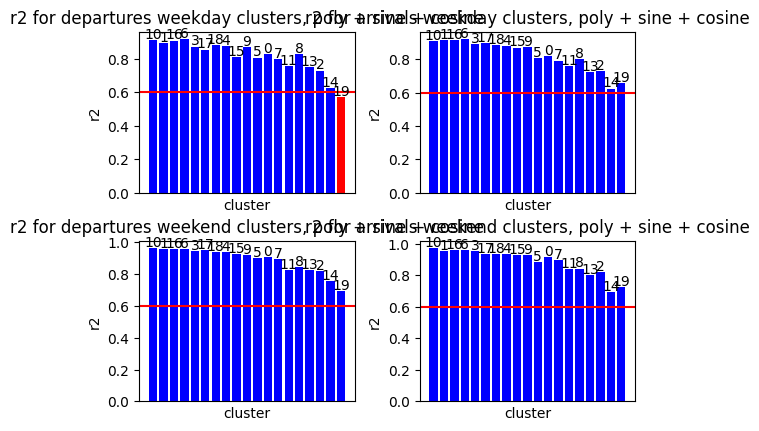

In [56]:
plt.subplot(2, 2, 1)
# Color the bars that fall below the 0.6 threshold red, the others blue.
plt.bar(range(n), [globals()['r2_departures_weekday{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_departures_weekday{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
plt.ylabel('r2')
plt.xlabel('cluster')
plt.title('r2 for departures weekday clusters'+', ' +features)
# Put the label of the clusters on top of each bin in the histogram. Center the label, give some whitespace between histogram top and label to avoid overlap.
# Reminder that we renamed the largest cluster to 0, so we had to account for this. 
for i in range(n):
    plt.text(i, globals()['r2_departures_weekday{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
# Remove xticks, no meaning
plt.xticks([])
# Put horizontal line at r^2 = 0.6
plt.axhline(y=0.6, color='r', linestyle='-')


plt.subplot(2, 2, 2)
# Color the bars that fall below the 0.6 threshold red, the others blue.
plt.bar(range(n), [globals()['r2_arrivals_weekday{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_arrivals_weekday{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
plt.ylabel('r2')
plt.xlabel('cluster')
plt.title('r2 for arrivals weekday clusters'+', ' + features)
# Put the label of the clusters on top of each bin in the histogram. Center the label, give some whitespace between histogram top and label to avoid overlap.
# Reminder that we renamed the largest cluster to 0, so we had to account for this.
for i in range(n):
    plt.text(i, globals()['r2_arrivals_weekday{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
# Remove xticks, no meaning
plt.xticks([])
# Put horizontal line at r^2 = 0.6
plt.axhline(y=0.6, color='r', linestyle='-')



plt.subplot(2, 2, 3)
# Color the bars that fall below the 0.6 threshold red, the others blue.
plt.bar(range(n), [globals()['r2_departures_weekend{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_departures_weekend{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
plt.ylabel('r2')
plt.xlabel('cluster')
plt.title('r2 for departures weekend clusters'+', ' +features)
# Put the label of the clusters on top of each bin in the histogram. Center the label, give some whitespace between histogram top and label to avoid overlap.
# Reminder that we renamed the largest cluster to 0, so we had to account for this.
for i in range(n):
    plt.text(i, globals()['r2_departures_weekend{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
# Remove xticks, no meaning
plt.xticks([])
# Put horizontal line at r^2 = 0.6
plt.axhline(y=0.6, color='r', linestyle='-')



plt.subplot(2, 2, 4)
# Color the bars that fall below the 0.6 threshold red, the others blue.
plt.bar(range(n), [globals()['r2_arrivals_weekend{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_arrivals_weekend{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
plt.ylabel('r2')
plt.xlabel('cluster')
plt.title('r2 for arrivals weekend clusters'+', ' +features)
# Put the label of the clusters on top of each bin in the histogram. Center the label, give some whitespace between histogram top and label to avoid overlap.
# Reminder that we renamed the largest cluster to 0, so we had to account for this.
for i in range(n):
    plt.text(i, globals()['r2_arrivals_weekend{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
# Remove xticks, no meaning
plt.xticks([])
# Put horizontal line at r^2 = 0.6
plt.axhline(y=0.6, color='r', linestyle='-')

# Icrease whitespace between subplots and figure size
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.rcParams["figure.figsize"] = (15,10)

#Increase textsizes of title, axes, ticks, labels
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=8)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.rc('figure', titlesize=8)  # fontsize of the figure title
plt.show()

For intuition behind the plots, see (Appendix A17).

## Intermezzo part: Making a prediction model for departures/arrivals counts²

In this part, we will train a prediction model to predict the counts² variable, necessary in pt.3. (Appendix A18)


r2 departures weekday cluster 0: 0.8196438533442629
r2 arrivals weekday cluster 0: 0.8169345743915053
r2 departures weekday cluster 1: 0.7974935185995472
r2 arrivals weekday cluster 1: 0.8354171780711925
r2 departures weekday cluster 2: 0.8184417261710769
r2 arrivals weekday cluster 2: 0.8411450165084585
r2 departures weekday cluster 3: 0.8183283589000582
r2 arrivals weekday cluster 3: 0.8467688273363981
r2 departures weekday cluster 4: 0.7551766199778706
r2 arrivals weekday cluster 4: 0.7737632843780501
r2 departures weekday cluster 5: 0.6861862631636365
r2 arrivals weekday cluster 5: 0.7541580967318519
r2 departures weekday cluster 6: 0.7760583324814307
r2 arrivals weekday cluster 6: 0.7762138248818078
r2 departures weekday cluster 7: 0.7658353938695951
r2 arrivals weekday cluster 7: 0.7771104795567055
r2 departures weekday cluster 8: 0.5781525858264813
r2 arrivals weekday cluster 8: 0.767890557477723
r2 departures weekday cluster 9: 0.7184972525886506
r2 arrivals weekday cluster 9: 

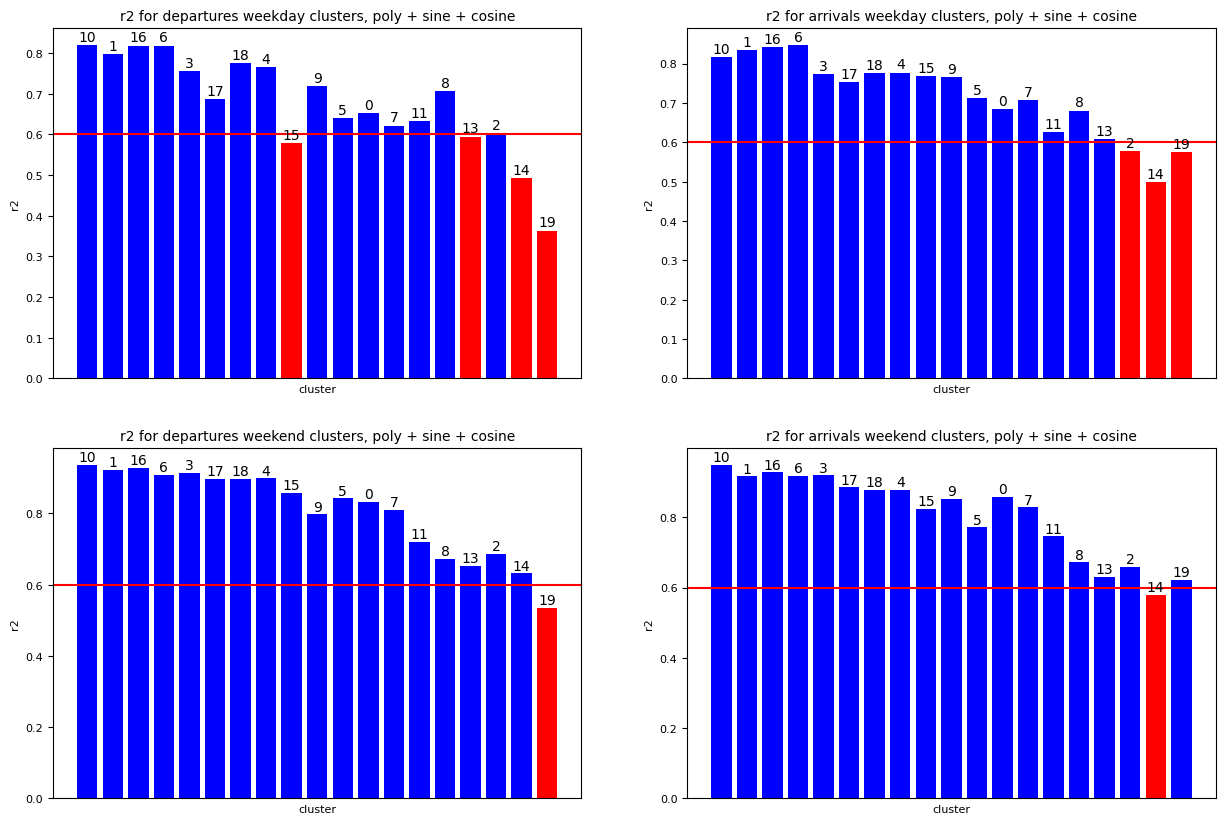

In [57]:
# Re-perform the linear regression approach introduced earlier, but now with target variable standerdized counts².
for i in range(n):
    globals()['x_departures_train_lagged{}'.format(i)] = np.c_[np.ones(len(globals()['departures_train_lagged{}'.format(i)]))]
    globals()['x_arrivals_train_lagged{}'.format(i)] = np.c_[np.ones(len(globals()['arrivals_train_lagged{}'.format(i)]))]

    # Add a column with the "day of week" to the x_departures_train variable. 
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())]

    # convert "day of week" to dummy variables since it is a categorical, 0 = is_monday, 1 = is_tuesday, 2 = is_wednesday, 3 = is_thursday, 4 = is_friday, 5 = is_saturday, 6 = is_sunday
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 0 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 1 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 2 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 3 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 4 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 5 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 6 else 0)]

    # Add the hour column to the x_departures_train variable
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['hour']]

    # Add a column with the "day of week" to the x_arrivals_train variable.
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())]

    # Convert "day of week" to dummy variables, 0 = is_monday, 1 = is_tuesday, 2 = is_wednesday, 3 = is_thursday, 4 = is_friday, 5 = is_saturday, 6 = is_sunday
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 0 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 1 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 2 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 3 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 4 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 5 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 6 else 0)]
    
    # Add the hour column to the x_arrivals_train variable
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['hour']]

    # Add all the lagged counts to the x_train variable
    for j in range(1, n_lag_dep_train+1):
        globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['count_lag{}'.format(j)]]
    for j in range(1, n_lag_arr_train+1):
        globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['count_lag{}'.format(j)]]



# Perform the same steps for the test data     
    globals()['x_departures_test_lagged{}'.format(i)] = np.c_[np.ones(len(globals()['departures_test_lagged{}'.format(i)]))]
    globals()['x_arrivals_test_lagged{}'.format(i)] = np.c_[np.ones(len(globals()['arrivals_test_lagged{}'.format(i)]))]
    
    # Add a column with the "day of week" to the x_departures_test variable.
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())]

    # Convert "day of week" to dummy variables, 0 = is_monday, 1 = is_tuesday, 2 = is_wednesday, 3 = is_thursday, 4 = is_friday, 5 = is_saturday, 6 = is_sunday
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 0 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 1 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 2 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 3 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 4 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 5 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 6 else 0)]

    # Add the hour column to the x_departures_test variable
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['hour']]

    # Add a column with the "day of week" to the x_arrivals_train variable.
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())]

    # Convert "day of week" to dummy variables, 0 = is_monday, 1 = is_tuesday, 2 = is_wednesday, 3 = is_thursday, 4 = is_friday, 5 = is_saturday, 6 = is_sunday
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 0 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 1 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 2 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 3 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 4 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 5 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 6 else 0)]
    
    # Add the hour column to the x_arrivals_test variable
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['hour']]
    
    # Also add all the lagged counts to the x_test variable
    for j in range(1, n_lag_dep_test+1):
        globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['count_lag{}'.format(j)]]
    for j in range(1, n_lag_arr_test+1):
        globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['count_lag{}'.format(j)]]
        


# Add polynomial features
degree = 2
for i in range(n):
    globals()['x_departures_train_poly{}'.format(i)] = add_polynomial(globals()['x_departures_train_lagged{}'.format(i)], degree)
    globals()['x_departures_test_poly{}'.format(i)] = add_polynomial(globals()['x_departures_test_lagged{}'.format(i)], degree)
    globals()['x_arrivals_train_poly{}'.format(i)] = add_polynomial(globals()['x_arrivals_train_lagged{}'.format(i)], degree)
    globals()['x_arrivals_test_poly{}'.format(i)] = add_polynomial(globals()['x_arrivals_test_lagged{}'.format(i)], degree)



# Add sine(hour)
for i in range(n):
    globals()['x_departures_train_sine{}'.format(i)] = np.insert(globals()['x_departures_train_poly{}'.format(i)],    9,    add_sine(globals()['x_departures_train_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_departures_test_sine{}'.format(i)] = np.insert(globals()['x_departures_test_poly{}'.format(i)],    9,    add_sine(globals()['x_departures_test_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_arrivals_train_sine{}'.format(i)] = np.insert(globals()['x_arrivals_train_poly{}'.format(i)],    9,    add_sine(globals()['x_arrivals_train_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_arrivals_test_sine{}'.format(i)] = np.insert(globals()['x_arrivals_test_poly{}'.format(i)],    9,    add_sine(globals()['x_arrivals_test_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)



# Delete hour duplicate column
for i in range(n):
    globals()['x_departures_train_sine{}'.format(i)] = np.delete(globals()['x_departures_train_sine{}'.format(i)], 11, 1)
    globals()['x_departures_test_sine{}'.format(i)] = np.delete(globals()['x_departures_test_sine{}'.format(i)], 11, 1)
    globals()['x_arrivals_train_sine{}'.format(i)] = np.delete(globals()['x_arrivals_train_sine{}'.format(i)], 11, 1)
    globals()['x_arrivals_test_sine{}'.format(i)] = np.delete(globals()['x_arrivals_test_sine{}'.format(i)], 11, 1)



# Add cos(hour)
for i in range(n):
    globals()['x_departures_train_cosine_sine{}'.format(i)] = np.insert(globals()['x_departures_train_sine{}'.format(i)],    9,    add_cosine(globals()['x_departures_train_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_departures_test_cosine_sine{}'.format(i)] = np.insert(globals()['x_departures_test_sine{}'.format(i)],    9,    add_cosine(globals()['x_departures_test_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_arrivals_train_cosine_sine{}'.format(i)] = np.insert(globals()['x_arrivals_train_sine{}'.format(i)],    9,    add_cosine(globals()['x_arrivals_train_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_arrivals_test_cosine_sine{}'.format(i)] = np.insert(globals()['x_arrivals_test_sine{}'.format(i)],    9,    add_cosine(globals()['x_arrivals_test_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)



# Delete hour duplicate column
for i in range(n):
    globals()['x_departures_train_cosine_sine{}'.format(i)] = np.delete(globals()['x_departures_train_cosine_sine{}'.format(i)], 11, 1)
    globals()['x_departures_test_cosine_sine{}'.format(i)] = np.delete(globals()['x_departures_test_cosine_sine{}'.format(i)], 11, 1)
    globals()['x_arrivals_train_cosine_sine{}'.format(i)] = np.delete(globals()['x_arrivals_train_cosine_sine{}'.format(i)], 11, 1)
    globals()['x_arrivals_test_cosine_sine{}'.format(i)] = np.delete(globals()['x_arrivals_test_cosine_sine{}'.format(i)], 11, 1)



#select the features you want to use
features = "poly + sine + cosine"
if features == "poly":
    for i in range(n):
        globals()['x_departures_train{}'.format(i)] = globals()['x_departures_train_poly{}'.format(i)]
        globals()['x_departures_test{}'.format(i)] = globals()['x_departures_test_poly{}'.format(i)]
        globals()['x_arrivals_train{}'.format(i)] = globals()['x_arrivals_train_poly{}'.format(i)]
        globals()['x_arrivals_test{}'.format(i)] = globals()['x_arrivals_test_poly{}'.format(i)]
elif features == "poly + sine":
    for i in range(n):
        globals()['x_departures_train{}'.format(i)] = globals()['x_departures_train_sine{}'.format(i)]
        globals()['x_departures_test{}'.format(i)] = globals()['x_departures_test_sine{}'.format(i)]
        globals()['x_arrivals_train{}'.format(i)] = globals()['x_arrivals_train_sine{}'.format(i)]
        globals()['x_arrivals_test{}'.format(i)] = globals()['x_arrivals_test_sine{}'.format(i)]
else:
    for i in range(n):
        globals()['x_departures_train{}'.format(i)] = globals()['x_departures_train_cosine_sine{}'.format(i)]
        globals()['x_departures_test{}'.format(i)] = globals()['x_departures_test_cosine_sine{}'.format(i)]
        globals()['x_arrivals_train{}'.format(i)] = globals()['x_arrivals_train_cosine_sine{}'.format(i)]
        globals()['x_arrivals_test{}'.format(i)] = globals()['x_arrivals_test_cosine_sine{}'.format(i)]



# Split the input data into weekday and weekend data
if features == "poly":
    column = 1
elif features == "poly + sine":
    column = 1
else:
    column = 1

for i in range(n):
    globals()['x_departures_train_weekday{}'.format(i)] = globals()['x_departures_train{}'.format(i)][globals()['x_departures_train{}'.format(i)][:,column] < 5]
    globals()['x_departures_train_weekend{}'.format(i)] = globals()['x_departures_train{}'.format(i)][globals()['x_departures_train{}'.format(i)][:,column] > 4]
    globals()['x_departures_test_weekday{}'.format(i)] = globals()['x_departures_test{}'.format(i)][globals()['x_departures_test{}'.format(i)][:,column] < 5]
    globals()['x_departures_test_weekend{}'.format(i)] = globals()['x_departures_test{}'.format(i)][globals()['x_departures_test{}'.format(i)][:,column] > 4]
    
    globals()['x_arrivals_train_weekday{}'.format(i)] = globals()['x_arrivals_train{}'.format(i)][globals()['x_arrivals_train{}'.format(i)][:,column] < 5]
    globals()['x_arrivals_train_weekend{}'.format(i)] = globals()['x_arrivals_train{}'.format(i)][globals()['x_arrivals_train{}'.format(i)][:,column] > 4]
    globals()['x_arrivals_test_weekday{}'.format(i)] = globals()['x_arrivals_test{}'.format(i)][globals()['x_arrivals_test{}'.format(i)][:,column] < 5]
    globals()['x_arrivals_test_weekend{}'.format(i)] = globals()['x_arrivals_test{}'.format(i)][globals()['x_arrivals_test{}'.format(i)][:,column] > 4]



# Delete the "day of week" column and only keep the correct way to present categorical data to your model.
for i in range(n):
    globals()['x_departures_train_weekday{}'.format(i)] = np.delete(globals()['x_departures_train_weekday{}'.format(i)], 1, 1)
    globals()['x_departures_train_weekend{}'.format(i)] = np.delete(globals()['x_departures_train_weekend{}'.format(i)], 1, 1)
    globals()['x_departures_test_weekday{}'.format(i)] = np.delete(globals()['x_departures_test_weekday{}'.format(i)], 1, 1)
    globals()['x_departures_test_weekend{}'.format(i)] = np.delete(globals()['x_departures_test_weekend{}'.format(i)], 1, 1)
    
    globals()['x_arrivals_train_weekday{}'.format(i)] = np.delete(globals()['x_arrivals_train_weekday{}'.format(i)], 1, 1)
    globals()['x_arrivals_train_weekend{}'.format(i)] = np.delete(globals()['x_arrivals_train_weekend{}'.format(i)], 1, 1)
    globals()['x_arrivals_test_weekday{}'.format(i)] = np.delete(globals()['x_arrivals_test_weekday{}'.format(i)], 1, 1)
    globals()['x_arrivals_test_weekend{}'.format(i)] = np.delete(globals()['x_arrivals_test_weekend{}'.format(i)], 1, 1)



# Standardize the input data
for i in range(n):
    globals()['x_departures_train_weekday_std{}'.format(i)] = (globals()['x_departures_train_weekday{}'.format(i)][:,8:] - np.mean(globals()['x_departures_train_weekday{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_departures_train_weekday{}'.format(i)][:,8:], axis=0)
    globals()['x_departures_train_weekend_std{}'.format(i)] = (globals()['x_departures_train_weekend{}'.format(i)][:,8:] - np.mean(globals()['x_departures_train_weekend{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_departures_train_weekend{}'.format(i)][:,8:], axis=0)
    globals()['x_departures_test_weekday_std{}'.format(i)] = (globals()['x_departures_test_weekday{}'.format(i)][:,8:] - np.mean(globals()['x_departures_test_weekday{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_departures_test_weekday{}'.format(i)][:,8:], axis=0)
    globals()['x_departures_test_weekend_std{}'.format(i)] = (globals()['x_departures_test_weekend{}'.format(i)][:,8:] - np.mean(globals()['x_departures_test_weekend{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_departures_test_weekend{}'.format(i)][:,8:], axis=0)

    globals()['x_arrivals_train_weekday_std{}'.format(i)] = (globals()['x_arrivals_train_weekday{}'.format(i)][:,8:] - np.mean(globals()['x_arrivals_train_weekday{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_arrivals_train_weekday{}'.format(i)][:,8:], axis=0)
    globals()['x_arrivals_train_weekend_std{}'.format(i)] = (globals()['x_arrivals_train_weekend{}'.format(i)][:,8:] - np.mean(globals()['x_arrivals_train_weekend{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_arrivals_train_weekend{}'.format(i)][:,8:], axis=0)
    globals()['x_arrivals_test_weekday_std{}'.format(i)] = (globals()['x_arrivals_test_weekday{}'.format(i)][:,8:] - np.mean(globals()['x_arrivals_test_weekday{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_arrivals_test_weekday{}'.format(i)][:,8:], axis=0)
    globals()['x_arrivals_test_weekend_std{}'.format(i)] = (globals()['x_arrivals_test_weekend{}'.format(i)][:,8:] - np.mean(globals()['x_arrivals_test_weekend{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_arrivals_test_weekend{}'.format(i)][:,8:], axis=0)



# Create a new dataset. Add the ones column, and weekday/weekend dummies.
for i in range(n):
    globals()['x_departures_train_weekday_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_departures_train_weekday{}'.format(i)])), globals()['x_departures_train_weekday{}'.format(i)][:,1:8]]
    globals()['x_departures_train_weekend_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_departures_train_weekend{}'.format(i)])), globals()['x_departures_train_weekend{}'.format(i)][:,1:8]]
    globals()['x_departures_test_weekday_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_departures_test_weekday{}'.format(i)])), globals()['x_departures_test_weekday{}'.format(i)][:,1:8]]
    globals()['x_departures_test_weekend_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_departures_test_weekend{}'.format(i)])), globals()['x_departures_test_weekend{}'.format(i)][:,1:8]]

    globals()['x_arrivals_train_weekday_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_arrivals_train_weekday{}'.format(i)])), globals()['x_arrivals_train_weekday{}'.format(i)][:,1:8]]
    globals()['x_arrivals_train_weekend_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_arrivals_train_weekend{}'.format(i)])), globals()['x_arrivals_train_weekend{}'.format(i)][:,1:8]]
    globals()['x_arrivals_test_weekday_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_arrivals_test_weekday{}'.format(i)])), globals()['x_arrivals_test_weekday{}'.format(i)][:,1:8]]
    globals()['x_arrivals_test_weekend_temp{}'.format(i)] = np.c_[np.ones(len(globals()['x_arrivals_test_weekend{}'.format(i)])), globals()['x_arrivals_test_weekend{}'.format(i)][:,1:8]]



# Add the standerdized x data to the new dataset to achieve the final, standerdized input dataset.
for i in range(n):
    globals()['x_departures_train_weekday_std{}'.format(i)] = np.c_[globals()['x_departures_train_weekday_temp{}'.format(i)], globals()['x_departures_train_weekday_std{}'.format(i)]]
    globals()['x_departures_train_weekend_std{}'.format(i)] = np.c_[globals()['x_departures_train_weekend_temp{}'.format(i)], globals()['x_departures_train_weekend_std{}'.format(i)]]
    globals()['x_departures_test_weekday_std{}'.format(i)] = np.c_[globals()['x_departures_test_weekday_temp{}'.format(i)], globals()['x_departures_test_weekday_std{}'.format(i)]]
    globals()['x_departures_test_weekend_std{}'.format(i)] = np.c_[globals()['x_departures_test_weekend_temp{}'.format(i)], globals()['x_departures_test_weekend_std{}'.format(i)]]

    globals()['x_arrivals_train_weekday_std{}'.format(i)] = np.c_[globals()['x_arrivals_train_weekday_temp{}'.format(i)], globals()['x_arrivals_train_weekday_std{}'.format(i)]]
    globals()['x_arrivals_train_weekend_std{}'.format(i)] = np.c_[globals()['x_arrivals_train_weekend_temp{}'.format(i)], globals()['x_arrivals_train_weekend_std{}'.format(i)]]
    globals()['x_arrivals_test_weekday_std{}'.format(i)] = np.c_[globals()['x_arrivals_test_weekday_temp{}'.format(i)], globals()['x_arrivals_test_weekday_std{}'.format(i)]]
    globals()['x_arrivals_test_weekend_std{}'.format(i)] = np.c_[globals()['x_arrivals_test_weekend_temp{}'.format(i)], globals()['x_arrivals_test_weekend_std{}'.format(i)]]



# Create a target dataset filled with departures/arrivals counts² values. 
for i in range(n):
    globals()['y_departures_train_squared{}'.format(i)] = (np.array(globals()['departures_train_lagged{}'.format(i)]['count'])**2).reshape(-1,1)
    globals()['y_departures_train_squared{}'.format(i)]= np.concatenate((globals()['y_departures_train_squared{}'.format(i)], np.array(globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())).reshape(-1,1)), axis = 1)
    globals()['y_arrivals_train_squared{}'.format(i)] = (np.array(globals()['arrivals_train_lagged{}'.format(i)]['count'])**2).reshape(-1,1)
    globals()['y_arrivals_train_squared{}'.format(i)]= np.concatenate((globals()['y_arrivals_train_squared{}'.format(i)], np.array(globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())).reshape(-1,1)), axis = 1)

    globals()['y_departures_test_squared{}'.format(i)] = (np.array(globals()['departures_test_lagged{}'.format(i)]['count'])**2).reshape(-1,1)
    globals()['y_departures_test_squared{}'.format(i)]= np.concatenate((globals()['y_departures_test_squared{}'.format(i)], np.array(globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())).reshape(-1,1)), axis = 1)
    globals()['y_arrivals_test_squared{}'.format(i)] = (np.array(globals()['arrivals_test_lagged{}'.format(i)]['count'])**2).reshape(-1,1)
    globals()['y_arrivals_test_squared{}'.format(i)]= np.concatenate((globals()['y_arrivals_test_squared{}'.format(i)], np.array(globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())).reshape(-1,1)), axis = 1)



# Split the target dataset into weekday and weekend data.
for i in range(n):
    globals()['y_departures_train_weekday_squared{}'.format(i)] = globals()['y_departures_train_squared{}'.format(i)][globals()['y_departures_train_squared{}'.format(i)][:,1] < 5]
    globals()['y_departures_train_weekend_squared{}'.format(i)] = globals()['y_departures_train_squared{}'.format(i)][globals()['y_departures_train_squared{}'.format(i)][:,1] > 4]
    globals()['y_departures_test_weekday_squared{}'.format(i)] = globals()['y_departures_test_squared{}'.format(i)][globals()['y_departures_test_squared{}'.format(i)][:,1] < 5]
    globals()['y_departures_test_weekend_squared{}'.format(i)] = globals()['y_departures_test_squared{}'.format(i)][globals()['y_departures_test_squared{}'.format(i)][:,1] > 4]
    
    globals()['y_arrivals_train_weekday_squared{}'.format(i)] = globals()['y_arrivals_train_squared{}'.format(i)][globals()['y_arrivals_train_squared{}'.format(i)][:,1] < 5]
    globals()['y_arrivals_train_weekend_squared{}'.format(i)] = globals()['y_arrivals_train_squared{}'.format(i)][globals()['y_arrivals_train_squared{}'.format(i)][:,1] > 4]
    globals()['y_arrivals_test_weekday_squared{}'.format(i)] = globals()['y_arrivals_test_squared{}'.format(i)][globals()['y_arrivals_test_squared{}'.format(i)][:,1] < 5]
    globals()['y_arrivals_test_weekend_squared{}'.format(i)] = globals()['y_arrivals_test_squared{}'.format(i)][globals()['y_arrivals_test_squared{}'.format(i)][:,1] > 4]

# Delete the "day of week" column and only keep the correct way to present categorical data to your model.
for i in range(n):
    globals()['y_departures_train_weekday_squared{}'.format(i)] = np.delete(globals()['y_departures_train_weekday_squared{}'.format(i)], 1, 1)
    globals()['y_departures_train_weekend_squared{}'.format(i)] = np.delete(globals()['y_departures_train_weekend_squared{}'.format(i)], 1, 1)
    globals()['y_departures_test_weekday_squared{}'.format(i)] = np.delete(globals()['y_departures_test_weekday_squared{}'.format(i)], 1, 1)
    globals()['y_departures_test_weekend_squared{}'.format(i)] = np.delete(globals()['y_departures_test_weekend_squared{}'.format(i)], 1, 1)
    
    globals()['y_arrivals_train_weekday_squared{}'.format(i)] = np.delete(globals()['y_arrivals_train_weekday_squared{}'.format(i)], 1, 1)
    globals()['y_arrivals_train_weekend_squared{}'.format(i)] = np.delete(globals()['y_arrivals_train_weekend_squared{}'.format(i)], 1, 1)
    globals()['y_arrivals_test_weekday_squared{}'.format(i)] = np.delete(globals()['y_arrivals_test_weekday_squared{}'.format(i)], 1, 1)
    globals()['y_arrivals_test_weekend_squared{}'.format(i)] = np.delete(globals()['y_arrivals_test_weekend_squared{}'.format(i)], 1, 1)

# We need y to be a 1D array for the linear regression approach, so reshape again.
for i in range(n):
    globals()['y_departures_train_weekday_squared{}'.format(i)] = globals()['y_departures_train_weekday_squared{}'.format(i)].reshape(-1)
    globals()['y_departures_train_weekend_squared{}'.format(i)] = globals()['y_departures_train_weekend_squared{}'.format(i)].reshape(-1)
    globals()['y_departures_test_weekday_squared{}'.format(i)] = globals()['y_departures_test_weekday_squared{}'.format(i)].reshape(-1)
    globals()['y_departures_test_weekend_squared{}'.format(i)] = globals()['y_departures_test_weekend_squared{}'.format(i)].reshape(-1)
    
    globals()['y_arrivals_train_weekday_squared{}'.format(i)] = globals()['y_arrivals_train_weekday_squared{}'.format(i)].reshape(-1)
    globals()['y_arrivals_train_weekend_squared{}'.format(i)] = globals()['y_arrivals_train_weekend_squared{}'.format(i)].reshape(-1)
    globals()['y_arrivals_test_weekday_squared{}'.format(i)] = globals()['y_arrivals_test_weekday_squared{}'.format(i)].reshape(-1)
    globals()['y_arrivals_test_weekend_squared{}'.format(i)] = globals()['y_arrivals_test_weekend_squared{}'.format(i)].reshape(-1)

# Standerdize the y data
for i in range(n):
    globals()['y_departures_train_weekday_squared_std{}'.format(i)] = (globals()['y_departures_train_weekday_squared{}'.format(i)] - np.mean(globals()['y_departures_train_weekday_squared{}'.format(i)], axis=0)) / np.std(globals()['y_departures_train_weekday_squared{}'.format(i)], axis=0)
    globals()['y_departures_train_weekend_squared_std{}'.format(i)] = (globals()['y_departures_train_weekend_squared{}'.format(i)] - np.mean(globals()['y_departures_train_weekend_squared{}'.format(i)], axis=0)) / np.std(globals()['y_departures_train_weekend_squared{}'.format(i)], axis=0)
    globals()['y_departures_test_weekday_squared_std{}'.format(i)] = (globals()['y_departures_test_weekday_squared{}'.format(i)] - np.mean(globals()['y_departures_test_weekday_squared{}'.format(i)], axis=0)) / np.std(globals()['y_departures_test_weekday_squared{}'.format(i)], axis=0)
    globals()['y_departures_test_weekend_squared_std{}'.format(i)] = (globals()['y_departures_test_weekend_squared{}'.format(i)] - np.mean(globals()['y_departures_test_weekend_squared{}'.format(i)], axis=0)) / np.std(globals()['y_departures_test_weekend_squared{}'.format(i)], axis=0)

    globals()['y_arrivals_train_weekday_squared_std{}'.format(i)] = (globals()['y_arrivals_train_weekday_squared{}'.format(i)] - np.mean(globals()['y_arrivals_train_weekday_squared{}'.format(i)], axis=0)) / np.std(globals()['y_arrivals_train_weekday_squared{}'.format(i)], axis=0)
    globals()['y_arrivals_train_weekend_squared_std{}'.format(i)] = (globals()['y_arrivals_train_weekend_squared{}'.format(i)] - np.mean(globals()['y_arrivals_train_weekend_squared{}'.format(i)], axis=0)) / np.std(globals()['y_arrivals_train_weekend_squared{}'.format(i)], axis=0)
    globals()['y_arrivals_test_weekday_squared_std{}'.format(i)] = (globals()['y_arrivals_test_weekday_squared{}'.format(i)] - np.mean(globals()['y_arrivals_test_weekday_squared{}'.format(i)], axis=0)) / np.std(globals()['y_arrivals_test_weekday_squared{}'.format(i)], axis=0)
    globals()['y_arrivals_test_weekend_squared_std{}'.format(i)] = (globals()['y_arrivals_test_weekend_squared{}'.format(i)] - np.mean(globals()['y_arrivals_test_weekend_squared{}'.format(i)], axis=0)) / np.std(globals()['y_arrivals_test_weekend_squared{}'.format(i)], axis=0)




# Import the linear regression model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Train weekday models
for i in range(n):
    globals()['model_departures_weekday_squared{}'.format(i)] = Ridge().fit(globals()['x_departures_train_weekday_std{}'.format(i)], globals()['y_departures_train_weekday_squared_std{}'.format(i)])
    globals()['model_arrivals_weekday_squared{}'.format(i)] = Ridge().fit(globals()['x_arrivals_train_weekday_std{}'.format(i)], globals()['y_arrivals_train_weekday_squared_std{}'.format(i)])
# Train weekend models
for i in range(n):
    globals()['model_departures_weekend_squared{}'.format(i)] = Ridge().fit(globals()['x_departures_train_weekend_std{}'.format(i)], globals()['y_departures_train_weekend_squared_std{}'.format(i)])
    globals()['model_arrivals_weekend_squared{}'.format(i)] = Ridge().fit(globals()['x_arrivals_train_weekend_std{}'.format(i)], globals()['y_arrivals_train_weekend_squared_std{}'.format(i)])

# Predict target variable for all clusters weekday test input data
for i in range(n):
    globals()['y_departures_pred_weekday_squared{}'.format(i)] = globals()['model_departures_weekday_squared{}'.format(i)].predict(globals()['x_departures_test_weekday_std{}'.format(i)])
    globals()['y_arrivals_pred_weekday_squared{}'.format(i)] = globals()['model_arrivals_weekday_squared{}'.format(i)].predict(globals()['x_arrivals_test_weekday_std{}'.format(i)])
# Predict target variable for all clusters weekend test input data
for i in range(n):
    globals()['y_departures_pred_weekend_squared{}'.format(i)] = globals()['model_departures_weekend_squared{}'.format(i)].predict(globals()['x_departures_test_weekend_std{}'.format(i)])
    globals()['y_arrivals_pred_weekend_squared{}'.format(i)] = globals()['model_arrivals_weekend_squared{}'.format(i)].predict(globals()['x_arrivals_test_weekend_std{}'.format(i)])

# Calculate r^2 for all clusters weekday test input data
from sklearn.metrics import r2_score
for i in range(n):
    globals()['r2_departures_weekday_squared{}'.format(i)] = r2_score(globals()['y_departures_test_weekday_squared_std{}'.format(i)], globals()['y_departures_pred_weekday_squared{}'.format(i)])
    globals()['r2_arrivals_weekday_squared{}'.format(i)] = r2_score(globals()['y_arrivals_test_weekday_squared_std{}'.format(i)], globals()['y_arrivals_pred_weekday_squared{}'.format(i)])
# Calculate r^2 for all clusters weekend test input data
for i in range(n):
    globals()['r2_departures_weekend_squared{}'.format(i)] = r2_score(globals()['y_departures_test_weekend_squared_std{}'.format(i)], globals()['y_departures_pred_weekend_squared{}'.format(i)])
    globals()['r2_arrivals_weekend_squared{}'.format(i)] = r2_score(globals()['y_arrivals_test_weekend_squared_std{}'.format(i)], globals()['y_arrivals_pred_weekend_squared{}'.format(i)])

# Print r^2 for all clusters weekday test input data
for i in range(n):
    print('r2 departures weekday cluster {}: {}'.format(i, globals()['r2_departures_weekday_squared{}'.format(i)]))
    print('r2 arrivals weekday cluster {}: {}'.format(i, globals()['r2_arrivals_weekday_squared{}'.format(i)]))
# Print r^2 for all clusters weekend test input data
for i in range(n):
    print('r2 departures weekend cluster {}: {}'.format(i, globals()['r2_departures_weekend_squared{}'.format(i)]))
    print('r2 arrivals weekend cluster {}: {}'.format(i, globals()['r2_arrivals_weekend_squared{}'.format(i)]))
    

# Plot prediction performance for all clusters test data. 
plt.subplot(2, 2, 1)
# Color the bars that fall below the 0.6 threshold red, the others blue.
plt.bar(range(n), [globals()['r2_departures_weekday_squared{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_departures_weekday_squared{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
plt.ylabel('r2')
plt.xlabel('cluster')
plt.title('r2 for departures weekday clusters'+', ' +features)
# Put the label of the clusters on top of each bin in the histogram. Center the label, give some whitespace between histogram top and label to avoid overlap.
# Reminder that we renamed the largest cluster to 0, so we had to account for this.
for i in range(n):
    plt.text(i, globals()['r2_departures_weekday_squared{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
# Remove xticks, no meaning
plt.xticks([])
# Put horizontal line at r^2 = 0.6
plt.axhline(y=0.6, color='r', linestyle='-')


plt.subplot(2, 2, 2)
# Color the bars that fall below the 0.6 threshold red, the others blue.
plt.bar(range(n), [globals()['r2_arrivals_weekday_squared{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_arrivals_weekday_squared{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
plt.ylabel('r2')
plt.xlabel('cluster')
plt.title('r2 for arrivals weekday clusters'+', ' + features)
# Put the label of the clusters on top of each bin in the histogram. Center the label, give some whitespace between histogram top and label to avoid overlap.
# Reminder that we renamed the largest cluster to 0, so we had to account for this.
for i in range(n):
    plt.text(i, globals()['r2_arrivals_weekday_squared{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
# Remove xticks, no meaning
plt.xticks([])
# Put horizontal line at r^2 = 0.6
plt.axhline(y=0.6, color='r', linestyle='-')


plt.subplot(2, 2, 3)
# Color the bars that fall below the 0.6 threshold red, the others blue.
plt.bar(range(n), [globals()['r2_departures_weekend_squared{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_departures_weekend_squared{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
plt.ylabel('r2')
plt.xlabel('cluster')
plt.title('r2 for departures weekend clusters'+', ' +features)
# Put the label of the clusters on top of each bin in the histogram. Center the label, give some whitespace between histogram top and label to avoid overlap.
# Reminder that we renamed the largest cluster to 0, so we had to account for this.
for i in range(n):
    plt.text(i, globals()['r2_departures_weekend_squared{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
# Remove xticks, no meaning
plt.xticks([])
# Put horizontal line at r^2 = 0.6
plt.axhline(y=0.6, color='r', linestyle='-')


plt.subplot(2, 2, 4)
# Color the bars that fall below the 0.6 threshold red, the others blue.
plt.bar(range(n), [globals()['r2_arrivals_weekend_squared{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_arrivals_weekend_squared{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
plt.ylabel('r2')
plt.xlabel('cluster')
plt.title('r2 for arrivals weekend clusters'+', ' +features)
# Put the label of the clusters on top of each bin in the histogram. Center the label, give some whitespace between histogram top and label to avoid overlap.
# Reminder that we renamed the largest cluster to 0, so we had to account for this.
for i in range(n):
    plt.text(i, globals()['r2_arrivals_weekend_squared{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
# Remove xticks, no meaning
plt.xticks([])
# Put horizontal line at r^2 = 0.6
plt.axhline(y=0.6, color='r', linestyle='-')



## Prediction Challenge Part 3



As described in the intermezzo chapter, we will apply a recursive approach for predicting the departures/arrivals counts. The approach is as follows: for a snippet of data from the test set (Appendix A19). Predict departures/arrivals counts and counts² using the models created. Supply these predictions into the input dataset as lag value to make a prediction for the next future hour. Continue this recursive process for the following 24 hours. 

The following code will only work if the model has been fitted for degree = 2, features = "poly + sine + cosine", and any lag. (Appendix A20)

In [58]:
# Select random snippet, ensure you stay inside the bounds of the test dataset (so not too large n_snippet)
n_snippet = 3

for i in range(n):
    globals()["x_departures_test_weekday{}_initial".format(i)] = globals()["x_departures_test_weekday{}".format(i)][n_snippet*n_lag_dep_test:(n_snippet+1)*n_lag_dep_test]
    globals()["x_departures_test_weekend{}_initial".format(i)] = globals()["x_departures_test_weekend{}".format(i)][n_snippet*n_lag_dep_test:(n_snippet+1)*n_lag_dep_test]
    globals()["x_arrivals_test_weekday{}_initial".format(i)] = globals()["x_arrivals_test_weekday{}".format(i)][n_snippet*n_lag_dep_test:(n_snippet+1)*n_lag_dep_test]
    globals()["x_arrivals_test_weekend{}_initial".format(i)] = globals()["x_arrivals_test_weekend{}".format(i)][n_snippet*n_lag_dep_test:(n_snippet+1)*n_lag_dep_test]
    # the indexes used ensure the final entry of the snippet is at 23 PM, allowing us to make a prediction for the next 24 hour day.

# We made this snippet from the unstandardised data purely to check whether the final value of the snippet is indeed at 23 PM. If the data was standardised, we would not be able to check this.
# Check if the final value is at hour 23, the hour was stored in the 8th column of the dataset. 
print(x_departures_test_weekday0_initial[:,8])
print(len(x_departures_test_weekday0_initial[:,8]))
print(x_departures_test_weekend0_initial[:,8])
print(len(x_departures_test_weekend0_initial[:,8]))
print(x_arrivals_test_weekday0_initial[:,8])
print(len(x_arrivals_test_weekday0_initial[:,8]))
print(x_arrivals_test_weekend0_initial[:,8])
print(len(x_arrivals_test_weekend0_initial[:,8]))


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]
24
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]
24
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]
24
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]
24


In [59]:
# Now that we are sure the final hour in the dataset is 23 PM, we can simply use the same snippet indexes on the standardised data. 
for i in range(n):
    globals()["x_departures_test_weekday{}_initial_std".format(i)] = globals()["x_departures_test_weekday_std{}".format(i)][n_snippet*n_lag_dep_test:(n_snippet+1)*n_lag_dep_test]
    globals()["x_departures_test_weekend{}_initial_std".format(i)] = globals()["x_departures_test_weekend_std{}".format(i)][n_snippet*n_lag_dep_test:(n_snippet+1)*n_lag_dep_test]
    globals()["x_arrivals_test_weekday{}_initial_std".format(i)] = globals()["x_arrivals_test_weekday_std{}".format(i)][n_snippet*n_lag_dep_test:(n_snippet+1)*n_lag_dep_test]
    globals()["x_arrivals_test_weekend{}_initial_std".format(i)] = globals()["x_arrivals_test_weekend_std{}".format(i)][n_snippet*n_lag_dep_test:(n_snippet+1)*n_lag_dep_test]

Perform the recursive approach. (Appendix A21)

In [60]:
# Predict the next hour for each cluster. Add a new row to the initial dataset. for index 0 add a 1, for index 1 to , add a one in column next to the one there was one already,
# for index 8 add the standardized hour, for index 9 add the standardized cos(hour), for index 10 add the standardized sin(hour), for index 11 add the predicted value for the next hour, 
# for index 12 take the value that was at index 11 in the previous row, for index 13 take index 12 in previous row and so on until index 11+n_lag. for index 11+n_lag+1 use the predicted 
# value on count squared for the next hour, for index 11+n_lag+2 take the value that was at index 11+n_lag+1 in the previous row, etc.
for i in range(n):
    for j in range(24):
        new_row_departures_test_weekday = np.zeros((1, 10+(n_lag_dep_test + 1)*degree))
        new_row_departures_test_weekend = np.zeros((1, 10+(n_lag_dep_test + 1)*degree))
        new_row_arrivals_test_weekday = np.zeros((1, 10+(n_lag_arr_test + 1)*degree))
        new_row_arrivals_test_weekend = np.zeros((1, 10+(n_lag_arr_test + 1)*degree))
        
        # Add 1 to index 0
        new_row_departures_test_weekday[0,0] = 1
        new_row_departures_test_weekend[0,0] = 1
        new_row_arrivals_test_weekday[0,0] = 1
        new_row_arrivals_test_weekend[0,0] = 1

        # Check which index from index 1-7 had a 1 in the first row of initial std dataset, and add a 1 to the next index, if the index was 7, add a 1 to index 1
        for k in range(1,8):
            if globals()["x_departures_test_weekday{}_initial_std".format(i)][0,k] == 1:
                if k == 7:
                    new_row_departures_test_weekday[0,1] = 1
                else:
                    new_row_departures_test_weekday[0,k+1] = 1
            if globals()["x_departures_test_weekend{}_initial_std".format(i)][0,k] == 1:
                if k == 7:
                    new_row_departures_test_weekend[0,1] = 1
                else:
                    new_row_departures_test_weekend[0,k+1] = 1
            if globals()["x_arrivals_test_weekday{}_initial_std".format(i)][0,k] == 1:
                if k == 7:
                    new_row_arrivals_test_weekday[0,1] = 1
                else:
                    new_row_arrivals_test_weekday[0,k+1] = 1
            if globals()["x_arrivals_test_weekend{}_initial_std".format(i)][0,k] == 1:
                if k == 7:
                    new_row_arrivals_test_weekend[0,1] = 1
                else:
                    new_row_arrivals_test_weekend[0,k+1] = 1

        
        # Add the j'th entry of snippet col 9 to index 8 (note i use the nomenclature: first col = col 1 = index 0)
        new_row_departures_test_weekday[0,8] = globals()["x_departures_test_weekday{}_initial_std".format(i)][j,8]
        new_row_departures_test_weekend[0,8] = globals()["x_departures_test_weekend{}_initial_std".format(i)][j,8]
        new_row_arrivals_test_weekday[0,8] = globals()["x_arrivals_test_weekday{}_initial_std".format(i)][j,8]
        new_row_arrivals_test_weekend[0,8] = globals()["x_arrivals_test_weekend{}_initial_std".format(i)][j,8]

        # Add the j'th entry of snippet col 10 to index 9
        new_row_departures_test_weekday[0,9] = globals()["x_departures_test_weekday{}_initial_std".format(i)][j,9]
        new_row_departures_test_weekend[0,9] = globals()["x_departures_test_weekend{}_initial_std".format(i)][j,9]
        new_row_arrivals_test_weekday[0,9] = globals()["x_arrivals_test_weekday{}_initial_std".format(i)][j,9]
        new_row_arrivals_test_weekend[0,9] = globals()["x_arrivals_test_weekend{}_initial_std".format(i)][j,9]

        # Add the j'th entry of snippet col 11 to index 10
        new_row_departures_test_weekday[0,10] = globals()["x_departures_test_weekday{}_initial_std".format(i)][j,10]
        new_row_departures_test_weekend[0,10] = globals()["x_departures_test_weekend{}_initial_std".format(i)][j,10]
        new_row_arrivals_test_weekday[0,10] = globals()["x_arrivals_test_weekday{}_initial_std".format(i)][j,10]
        new_row_arrivals_test_weekend[0,10] = globals()["x_arrivals_test_weekend{}_initial_std".format(i)][j,10]

        # Add the count model predicted value for the next hour to index 11
        new_row_departures_test_weekday[0,11] = globals()["model_departures_weekday{}".format(i)].predict(globals()["x_departures_test_weekday{}_initial_std".format(i)])[-1]
        new_row_departures_test_weekend[0,11] = globals()["model_departures_weekend{}".format(i)].predict(globals()["x_departures_test_weekend{}_initial_std".format(i)])[-1]
        new_row_arrivals_test_weekday[0,11] = globals()["model_arrivals_weekday{}".format(i)].predict(globals()["x_arrivals_test_weekday{}_initial_std".format(i)])[-1]
        new_row_arrivals_test_weekend[0,11] = globals()["model_arrivals_weekend{}".format(i)].predict(globals()["x_arrivals_test_weekend{}_initial_std".format(i)])[-1]

        
        # Add the value that was at index 11 in the previous row to index 12 and do this for the next n_lag_dep_test-1 indexes
        for k in range(1,n_lag_dep_test):
            new_row_departures_test_weekday[0,11+k] = globals()["x_departures_test_weekday{}_initial_std".format(i)][-1,11+k-1]
            new_row_departures_test_weekend[0,11+k] = globals()["x_departures_test_weekend{}_initial_std".format(i)][-1,11+k-1]
            new_row_arrivals_test_weekday[0,11+k] = globals()["x_arrivals_test_weekday{}_initial_std".format(i)][-1,11+k-1]
            new_row_arrivals_test_weekend[0,11+k] = globals()["x_arrivals_test_weekend{}_initial_std".format(i)][-1,11+k-1]
        
        # Add the j'th entry of snippet col 12+n_lag_dep_test (= hour²) to index 11+n_lag_dep_test
        new_row_departures_test_weekday[0,11+n_lag_dep_test] = globals()["x_departures_test_weekday{}_initial_std".format(i)][j,11+n_lag_dep_test]
        new_row_departures_test_weekend[0,11+n_lag_dep_test] = globals()["x_departures_test_weekend{}_initial_std".format(i)][j,11+n_lag_dep_test]
        new_row_arrivals_test_weekday[0,11+n_lag_dep_test] = globals()["x_arrivals_test_weekday{}_initial_std".format(i)][j,11+n_lag_dep_test]
        new_row_arrivals_test_weekend[0,11+n_lag_dep_test] = globals()["x_arrivals_test_weekend{}_initial_std".format(i)][j,11+n_lag_dep_test]

        # Add the count² model predicted value for the next hour to index 12+n_lag_dep_test
        new_row_departures_test_weekday[0,12+n_lag_dep_test] = globals()["model_departures_weekday_squared{}".format(i)].predict(globals()["x_departures_test_weekday{}_initial_std".format(i)])[-1]
        new_row_departures_test_weekend[0,12+n_lag_dep_test] = globals()["model_departures_weekend_squared{}".format(i)].predict(globals()["x_departures_test_weekend{}_initial_std".format(i)])[-1]
        new_row_arrivals_test_weekday[0,12+n_lag_dep_test] = globals()["model_arrivals_weekday_squared{}".format(i)].predict(globals()["x_arrivals_test_weekday{}_initial_std".format(i)])[-1]
        new_row_arrivals_test_weekend[0,12+n_lag_dep_test] = globals()["model_arrivals_weekend_squared{}".format(i)].predict(globals()["x_arrivals_test_weekend{}_initial_std".format(i)])[-1]

        # Add the value that was at index 12+n_lag_dep_test in the previous row to index 13+n_lag_dep_test and do this for the next n_lag_dep_test-1 indexes
        for k in range(1,n_lag_dep_test):
            new_row_departures_test_weekday[0,12+n_lag_dep_test+k] = globals()["x_departures_test_weekday{}_initial_std".format(i)][-1,12+n_lag_dep_test+k-1]
            new_row_departures_test_weekend[0,12+n_lag_dep_test+k] = globals()["x_departures_test_weekend{}_initial_std".format(i)][-1,12+n_lag_dep_test+k-1]
            new_row_arrivals_test_weekday[0,12+n_lag_dep_test+k] = globals()["x_arrivals_test_weekday{}_initial_std".format(i)][-1,12+n_lag_dep_test+k-1]
            new_row_arrivals_test_weekend[0,12+n_lag_dep_test+k] = globals()["x_arrivals_test_weekend{}_initial_std".format(i)][-1,12+n_lag_dep_test+k-1]

        # Add the new row to the initial standerdized dataset
        globals()["x_departures_test_weekday{}_initial_std".format(i)] = np.append(globals()["x_departures_test_weekday{}_initial_std".format(i)], new_row_departures_test_weekday, axis=0)
        globals()["x_departures_test_weekend{}_initial_std".format(i)] = np.append(globals()["x_departures_test_weekend{}_initial_std".format(i)], new_row_departures_test_weekend, axis=0)
        globals()["x_arrivals_test_weekday{}_initial_std".format(i)] = np.append(globals()["x_arrivals_test_weekday{}_initial_std".format(i)], new_row_arrivals_test_weekday, axis=0)
        globals()["x_arrivals_test_weekend{}_initial_std".format(i)] = np.append(globals()["x_arrivals_test_weekend{}_initial_std".format(i)], new_row_arrivals_test_weekend, axis=0)

# Rename dataset for clarity 
for i in range(n):
    globals()["x_departures_test_weekday{}_predicted".format(i)] = globals()["x_departures_test_weekday{}_initial_std".format(i)]
    globals()["x_departures_test_weekend{}_predicted".format(i)] = globals()["x_departures_test_weekend{}_initial_std".format(i)]
    globals()["x_arrivals_test_weekday{}_predicted".format(i)] = globals()["x_arrivals_test_weekday{}_initial_std".format(i)]
    globals()["x_arrivals_test_weekend{}_predicted".format(i)] = globals()["x_arrivals_test_weekend{}_initial_std".format(i)]

# For each cluster, extract the counts prediction column, column 11:
for i in range(n):
    globals()["counts_departures_test_weekday{}_predicted".format(i)] = globals()["x_departures_test_weekday{}_predicted".format(i)][:,11]
    globals()["counts_departures_test_weekend{}_predicted".format(i)] = globals()["x_departures_test_weekend{}_predicted".format(i)][:,11]
    globals()["counts_arrivals_test_weekday{}_predicted".format(i)] = globals()["x_arrivals_test_weekday{}_predicted".format(i)][:,11]
    globals()["counts_arrivals_test_weekend{}_predicted".format(i)] = globals()["x_arrivals_test_weekend{}_predicted".format(i)][:,11]


# Use the mean and std of the training data for the y variables to unstanderdize the predicted values. Do not use of the test or full data, since these require values after the scope of the snippet.
# Use train because we have access to this data since since it is "in the past" from the perspective of the test data. We want to unstanderdize to get an intuitive measure for the amount of bikes
# predicted. 
for i in range(n):
    globals()["counts_departures_test_weekday{}_predicted_unstd".format(i)] = globals()["counts_departures_test_weekday{}_predicted".format(i)]*np.std(globals()["y_departures_train_weekday{}".format(i)]) + np.mean(globals()["y_departures_train_weekday{}".format(i)])
    globals()["counts_departures_test_weekend{}_predicted_unstd".format(i)] = globals()["counts_departures_test_weekend{}_predicted".format(i)]*np.std(globals()["y_departures_train_weekend{}".format(i)]) + np.mean(globals()["y_departures_train_weekend{}".format(i)])
    globals()["counts_arrivals_test_weekday{}_predicted_unstd".format(i)] = globals()["counts_arrivals_test_weekday{}_predicted".format(i)]*np.std(globals()["y_arrivals_train_weekday{}".format(i)]) + np.mean(globals()["y_arrivals_train_weekday{}".format(i)])
    globals()["counts_arrivals_test_weekend{}_predicted_unstd".format(i)] = globals()["counts_arrivals_test_weekend{}_predicted".format(i)]*np.std(globals()["y_arrivals_train_weekend{}".format(i)]) + np.mean(globals()["y_arrivals_train_weekend{}".format(i)])

    

# For each cluster, sum the predicted departures and arrivals for the last 24 hours in the unstanderdized y_dataset and take the difference to see how many bikes have to be imported, or are in surplus
# at the end of the day. 
for i in range(n):
    globals()["counts_departures_test_weekday{}_predicted_unstd_sum".format(i)] = np.sum(globals()["counts_departures_test_weekday{}_predicted_unstd".format(i)][-24:])
    globals()["counts_departures_test_weekend{}_predicted_unstd_sum".format(i)] = np.sum(globals()["counts_departures_test_weekend{}_predicted_unstd".format(i)][-24:])
    globals()["counts_arrivals_test_weekday{}_predicted_unstd_sum".format(i)] = np.sum(globals()["counts_arrivals_test_weekday{}_predicted_unstd".format(i)][-24:])
    globals()["counts_arrivals_test_weekend{}_predicted_unstd_sum".format(i)] = np.sum(globals()["counts_arrivals_test_weekend{}_predicted_unstd".format(i)][-24:])

    globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)] = globals()["counts_departures_test_weekday{}_predicted_unstd_sum".format(i)] - globals()["counts_arrivals_test_weekday{}_predicted_unstd_sum".format(i)]
    globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)] = globals()["counts_departures_test_weekend{}_predicted_unstd_sum".format(i)] - globals()["counts_arrivals_test_weekend{}_predicted_unstd_sum".format(i)]

# Round the sums to nearest integer.
for i in range(n):
    globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)] = int(np.rint(globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)]))
    globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)] = int(np.rint(globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)]))

     
# If the value of the difference is negative, it means that there are more bikes that arrive than leave, so we dont have to import bikes, there is a surplus at the end of the day.
# If the value of the difference is positive, it means that there are more bikes that leave than arrive, so we have to import bikes.
print(' ')
print("The amount of bikes to import or the amount left at the end of the day for each cluster, ordered by size of cluster in descending order:")
for i in range(n):
    print('-----------------------------------')
    print('----------- cluster {} -------------'.format(largest_cluster[i]))
    print('-----------------------------------')
    if globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)] > 0:
        print('When the 24 hour sippet is taken on the selected weekday: for cluster {}, import {} bikes'.format(largest_cluster[i],globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)]))
    else:
        print('When the 24 hour sippet is taken on the selected weekday: for cluster {}, you will be left with {} bikes at the end of the day. No bikes to be imported.'.format(largest_cluster[i],-globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)]))
    if globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)] > 0:
        print('When the 24 hour sippet is taken on the selected weekend day: for cluster {}, import {} bikes'.format(largest_cluster[i],globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)]))
    else:
        print('When the 24 hour sippet is taken on the selected weekend day: for cluster {}, you will be left with {} bikes at the end of the day. No bikes to be imported.'.format(largest_cluster[i],-globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)]))
    print(' ')
    print(' ')
    print(' ')



print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")



# Used the unstanderdized value instead of standerdized one followed by unstanderdization using the mean and std of the training data for the y variables, because that would not have yielded the 
# actual present value. We can directly use the actual present value, so why not? 
for i in range(n):
    globals()["y_departures_test_weekday{}_actual_unstd".format(i)] = globals()["y_departures_test_weekday{}".format(i)][(n_snippet+1)*n_lag_dep_test:(n_snippet+2)*n_lag_dep_test]
    globals()["y_departures_test_weekend{}_actual_unstd".format(i)] = globals()["y_departures_test_weekend{}".format(i)][(n_snippet+1)*n_lag_dep_test:(n_snippet+2)*n_lag_dep_test]
    globals()["y_arrivals_test_weekday{}_actual_unstd".format(i)] = globals()["y_arrivals_test_weekday{}".format(i)][(n_snippet+1)*n_lag_dep_test:(n_snippet+2)*n_lag_dep_test]
    globals()["y_arrivals_test_weekend{}_actual_unstd".format(i)] = globals()["y_arrivals_test_weekend{}".format(i)][(n_snippet+1)*n_lag_dep_test:(n_snippet+2)*n_lag_dep_test]


# Sum the actual values for the last 24 hours of the actual y data, and take the difference to see how many bikes have to be imported, or are in surplus at the end of the day.
for i in range(n):
    globals()["y_departures_test_weekday{}_actual_unstd_sum".format(i)] = np.sum(globals()["y_departures_test_weekday{}_actual_unstd".format(i)])
    globals()["y_departures_test_weekend{}_actual_unstd_sum".format(i)] = np.sum(globals()["y_departures_test_weekend{}_actual_unstd".format(i)])
    globals()["y_arrivals_test_weekday{}_actual_unstd_sum".format(i)] = np.sum(globals()["y_arrivals_test_weekday{}_actual_unstd".format(i)])
    globals()["y_arrivals_test_weekend{}_actual_unstd_sum".format(i)] = np.sum(globals()["y_arrivals_test_weekend{}_actual_unstd".format(i)])

    globals()["difference_test_weekday{}_actual_unstd_sum".format(i)] = globals()["y_departures_test_weekday{}_actual_unstd_sum".format(i)] - globals()["y_arrivals_test_weekday{}_actual_unstd_sum".format(i)]
    globals()["difference_test_weekend{}_actual_unstd_sum".format(i)] = globals()["y_departures_test_weekend{}_actual_unstd_sum".format(i)] - globals()["y_arrivals_test_weekend{}_actual_unstd_sum".format(i)]

# Round the sums to nearest integer
for i in range(n):
    globals()["difference_test_weekday{}_actual_unstd_sum".format(i)] = int(np.rint(globals()["difference_test_weekday{}_actual_unstd_sum".format(i)]))
    globals()["difference_test_weekend{}_actual_unstd_sum".format(i)] = int(np.rint(globals()["difference_test_weekend{}_actual_unstd_sum".format(i)]))

# Get the difference between the actual values and the predicted values for the last 24 hours of the actual y data to see how many bikes our model was off by.
for i in range(n):
    globals()["difference_test_weekday{}_pred_vs_act".format(i)] = globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)] - globals()["difference_test_weekday{}_actual_unstd_sum".format(i)]
    globals()["difference_test_weekend{}_pred_vs_act".format(i)] = globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)] - globals()["difference_test_weekend{}_actual_unstd_sum".format(i)]

# Round the sums to nearest integer
for i in range(n):
    globals()["difference_test_weekday{}_pred_vs_act".format(i)] = np.abs(int(np.rint(globals()["difference_test_weekday{}_pred_vs_act".format(i)])))
    globals()["difference_test_weekend{}_pred_vs_act".format(i)] = np.abs(int(np.rint(globals()["difference_test_weekend{}_pred_vs_act".format(i)])))

print(' ')
print("The actual amount of bikes to import or the amount left at the end of the day for each cluster, ordered by size of cluster in descending order:")
for i in range(n):
    print('-----------------------------------')
    print('----------- cluster {} -------------'.format(largest_cluster[i]))
    print('-----------------------------------')
    if globals()["difference_test_weekday{}_actual_unstd_sum".format(i)] > 0:
        print('When the 24 hour sippet is taken on the selected weekday: for cluster {}, import {} bikes'.format(largest_cluster[i],globals()["difference_test_weekday{}_actual_unstd_sum".format(i)]))
        print("our prediction was off by {} bikes".format(globals()["difference_test_weekday{}_pred_vs_act".format(i)]))
    else:
        print('When the 24 hour sippet is taken on the selected weekday: for cluster {}, you will be left with {} bikes at the end of the day. No bikes to be imported.'.format(largest_cluster[i],-globals()["difference_test_weekday{}_actual_unstd_sum".format(i)]))
        print("our prediction was off by {} bikes".format(globals()["difference_test_weekday{}_pred_vs_act".format(i)]))
    if globals()["difference_test_weekend{}_actual_unstd_sum".format(i)] > 0:
        print('When the  24 hour sippet is taken on the selected weekend day: for cluster {}, import {} bikes'.format(largest_cluster[i],globals()["difference_test_weekend{}_actual_unstd_sum".format(i)]))
        print("our prediction was off by {} bikes".format(globals()["difference_test_weekday{}_pred_vs_act".format(i)]))
    else:
        print('When the 24 hour sippet is taken on the selected weekend day: for cluster {}, you will be left with {} bikes at the end of the day. No bikes to be imported.'.format(largest_cluster[i],-globals()["difference_test_weekend{}_actual_unstd_sum".format(i)]))
        print("our prediction was off by {} bikes".format(globals()["difference_test_weekday{}_pred_vs_act".format(i)]))
    print(' ')
    print(' ')
    print(' ')



 
The amount of bikes to import or the amount left at the end of the day for each cluster, ordered by size of cluster in descending order:
-----------------------------------
----------- cluster 10 -------------
-----------------------------------
When the 24 hour sippet is taken on the selected weekday: for cluster 10, you will be left with 381 bikes at the end of the day. No bikes to be imported.
When the 24 hour sippet is taken on the selected weekend day: for cluster 10, you will be left with 117 bikes at the end of the day. No bikes to be imported.
 
 
 
-----------------------------------
----------- cluster 1 -------------
-----------------------------------
When the 24 hour sippet is taken on the selected weekday: for cluster 1, import 625 bikes
When the 24 hour sippet is taken on the selected weekend day: for cluster 1, import 136 bikes
 
 
 
-----------------------------------
----------- cluster 16 -------------
-----------------------------------
When the 24 hour sippet is 

Visualize the results.

Text(0.985, 0.01, 'Positive histograms indicate bikes have to be imported')

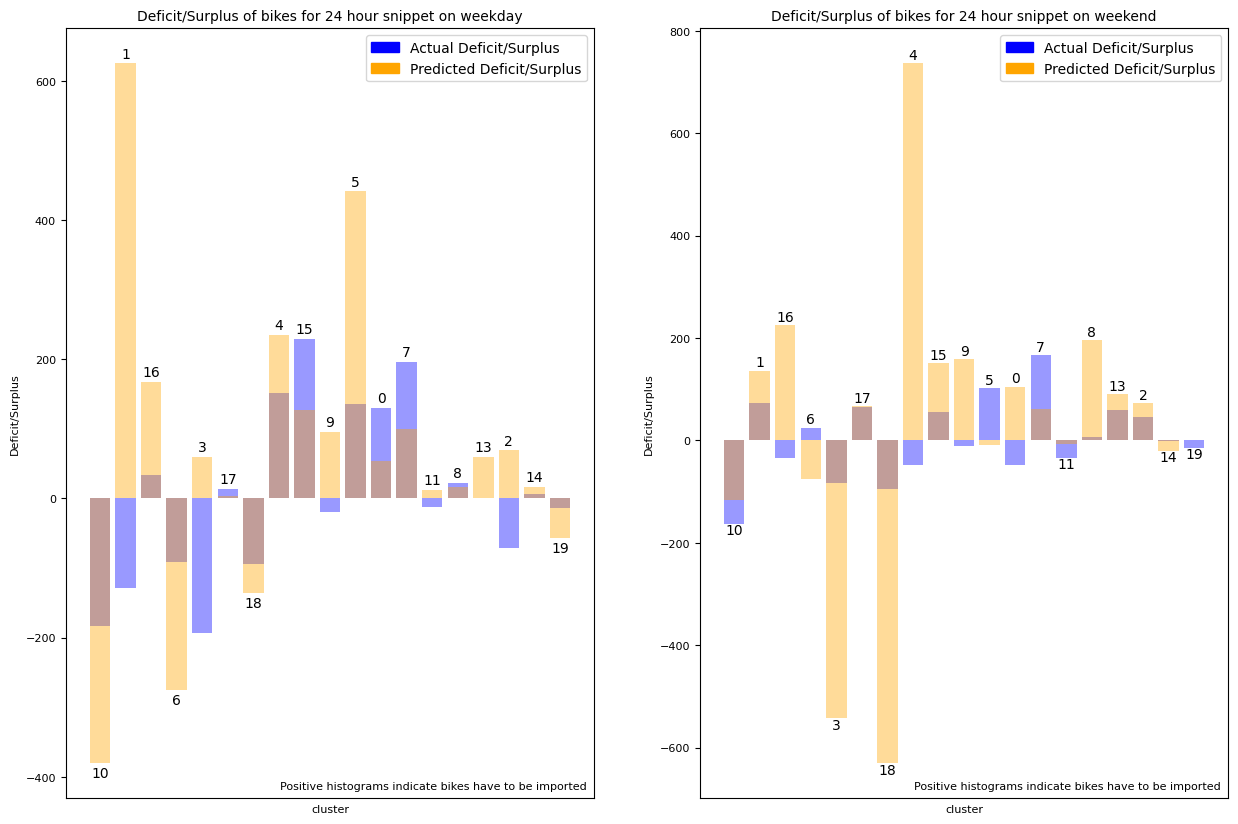

In [61]:
# Visualize the performance of the predictions: plot the actual value in histogram, in the same bin, plot the predicted value in a different color.
import matplotlib.patches as mpatches

blue_patch = mpatches.Patch(color='blue', label='Actual Deficit/Surplus')
orange_patch = mpatches.Patch(color='orange', label='Predicted Deficit/Surplus')
explanation_patch = mpatches.Patch(label = "Positive value means deficit in bikes, import these bikes")

# Color list: 
color_blue = []
color_orange = []
for i in range(n):
    color_blue.append("blue")
    color_orange.append("orange")

# Label list
label_actual = []
label_predicted = []
for i in range(n):
    label_actual.append("actual")
    label_predicted.append("predicted")

plt.subplot(1, 2, 1)
plt.bar(range(n), [globals()['difference_test_weekday{}_actual_unstd_sum'.format(i)] for i in range(n)], color=color_blue, label=label_actual, alpha = 0.4)
#plotting the text (cluster label) correctly above the bars
for i in range(n):
    if globals()["difference_test_weekday{}_actual_unstd_sum".format(i)] < 0 and globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)]>0:
        plt.text(i, globals()['difference_test_weekday{}_predicted_unstd_sum'.format(i)]+8, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekday{}_actual_unstd_sum".format(i)] > 0 and globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)]<0:
        plt.text(i, globals()['difference_test_weekday{}_actual_unstd_sum'.format(i)]+8, largest_cluster[i], rotation=0, ha='center')    
    if globals()["difference_test_weekday{}_actual_unstd_sum".format(i)] < 0 and globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)]<0:
        if np.abs(globals()["difference_test_weekday{}_actual_unstd_sum".format(i)]) > np.abs(globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)]):
            plt.text(i, globals()['difference_test_weekday{}_actual_unstd_sum'.format(i)]-20, largest_cluster[i], rotation=0, ha='center')
        if np.abs(globals()["difference_test_weekday{}_actual_unstd_sum".format(i)]) < np.abs(globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)]): 
            plt.text(i, globals()['difference_test_weekday{}_predicted_unstd_sum'.format(i)]-20, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekday{}_actual_unstd_sum".format(i)] > 0 and globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)]>0:         
        if np.abs(globals()["difference_test_weekday{}_actual_unstd_sum".format(i)]) > np.abs(globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)]):
            plt.text(i, globals()['difference_test_weekday{}_actual_unstd_sum'.format(i)]+8, largest_cluster[i], rotation=0, ha='center')
        if np.abs(globals()["difference_test_weekday{}_actual_unstd_sum".format(i)]) < np.abs(globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)]): 
            plt.text(i, globals()['difference_test_weekday{}_predicted_unstd_sum'.format(i)]+8, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekday{}_actual_unstd_sum".format(i)] == 0 and globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)] == 0:
        plt.text(i, 0, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekday{}_actual_unstd_sum".format(i)] == 0 and globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)] > 0:
        plt.text(i, globals()['difference_test_weekday{}_predicted_unstd_sum'.format(i)]+8, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekday{}_actual_unstd_sum".format(i)] == 0 and globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)] < 0:
        plt.text(i, globals()['difference_test_weekday{}_predicted_unstd_sum'.format(i)]-20, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekday{}_actual_unstd_sum".format(i)] > 0 and globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)] == 0:
        plt.text(i, globals()['difference_test_weekday{}_actual_unstd_sum'.format(i)]+8, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekday{}_actual_unstd_sum".format(i)] < 0 and globals()["difference_test_weekday{}_predicted_unstd_sum".format(i)] == 0:
        plt.text(i, globals()['difference_test_weekday{}_actual_unstd_sum'.format(i)]-20, largest_cluster[i], rotation=0, ha='center')
plt.bar(range(n), [globals()['difference_test_weekday{}_predicted_unstd_sum'.format(i)] for i in range(n)], color=color_orange, label=label_predicted, alpha = 0.4)
plt.title('Deficit/Surplus of bikes for 24 hour snippet on weekday')
plt.xlabel("cluster")
plt.xticks([])
plt.ylabel('Deficit/Surplus')
plt.legend(loc='upper right')
plt.legend(handles=[blue_patch, orange_patch])
text_box = "Positive histograms indicate bikes have to be imported"
plt.text(0.985, 0.01, text_box, transform=plt.gca().transAxes,
         fontsize=8, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))


plt.subplot(1, 2, 2)
plt.bar(range(n), [globals()['difference_test_weekend{}_actual_unstd_sum'.format(i)] for i in range(n)], color=color_blue, label=label_actual, alpha = 0.4)
#plotting the text (cluster label) correctly above the bars
for i in range(n):
    if globals()["difference_test_weekend{}_actual_unstd_sum".format(i)] < 0 and globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)]>0:
        plt.text(i, globals()['difference_test_weekend{}_predicted_unstd_sum'.format(i)]+8, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekend{}_actual_unstd_sum".format(i)] > 0 and globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)]<0:
        plt.text(i, globals()['difference_test_weekend{}_actual_unstd_sum'.format(i)]+8, largest_cluster[i], rotation=0, ha='center')    
    if globals()["difference_test_weekend{}_actual_unstd_sum".format(i)] < 0 and globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)]<0:
        if np.abs(globals()["difference_test_weekend{}_actual_unstd_sum".format(i)]) > np.abs(globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)]):
            plt.text(i, globals()['difference_test_weekend{}_actual_unstd_sum'.format(i)]-20, largest_cluster[i], rotation=0, ha='center')
        if np.abs(globals()["difference_test_weekend{}_actual_unstd_sum".format(i)]) < np.abs(globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)]): 
            plt.text(i, globals()['difference_test_weekend{}_predicted_unstd_sum'.format(i)]-20, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekend{}_actual_unstd_sum".format(i)] > 0 and globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)]>0:         
        if np.abs(globals()["difference_test_weekend{}_actual_unstd_sum".format(i)]) > np.abs(globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)]):
            plt.text(i, globals()['difference_test_weekend{}_actual_unstd_sum'.format(i)]+8, largest_cluster[i], rotation=0, ha='center')
        if np.abs(globals()["difference_test_weekend{}_actual_unstd_sum".format(i)]) < np.abs(globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)]): 
            plt.text(i, globals()['difference_test_weekend{}_predicted_unstd_sum'.format(i)]+8, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekend{}_actual_unstd_sum".format(i)] == 0 and globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)] == 0:
        plt.text(i, 0, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekend{}_actual_unstd_sum".format(i)] == 0 and globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)] > 0:
        plt.text(i, globals()['difference_test_weekend{}_predicted_unstd_sum'.format(i)]+8, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekend{}_actual_unstd_sum".format(i)] == 0 and globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)] < 0:
        plt.text(i, globals()['difference_test_weekend{}_predicted_unstd_sum'.format(i)]-20, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekend{}_actual_unstd_sum".format(i)] > 0 and globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)] == 0:
        plt.text(i, globals()['difference_test_weekend{}_actual_unstd_sum'.format(i)]+8, largest_cluster[i], rotation=0, ha='center')
    if globals()["difference_test_weekend{}_actual_unstd_sum".format(i)] < 0 and globals()["difference_test_weekend{}_predicted_unstd_sum".format(i)] == 0:
        plt.text(i, globals()['difference_test_weekend{}_actual_unstd_sum'.format(i)]-20, largest_cluster[i], rotation=0, ha='center')
plt.bar(range(n), [globals()['difference_test_weekend{}_predicted_unstd_sum'.format(i)] for i in range(n)], color=color_orange, label=label_predicted, alpha = 0.4)
plt.title('Deficit/Surplus of bikes for 24 hour snippet on weekend')
plt.xlabel("cluster")
plt.xticks([])
plt.ylabel('Deficit/Surplus')
plt.legend(loc='upper right')
plt.legend(handles=[blue_patch, orange_patch])
text_box = "Positive histograms indicate bikes have to be imported"
plt.text(0.985, 0.01, text_box, transform=plt.gca().transAxes,
         fontsize=8, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))


The relatively poor prediction accuracy from the model can be explained by two main hypotheses:
1) The models used for the prediction were not all perfect, some clusters had models with prediction accuracies close to R² = 0.6, hence prediction quality was not perfect for all clusters.
2) Even if the model had a large R² value, using the model recursively using its outputs would yield bad results if the amount of recursions is large (which is the case). An accuracy of 90% becomes one of 8% when applied 24 times using its output.

Nevertheless, no improvement in the models has been found.

=======================================================================================================================================================================================================
=======================================================================================================================================================================================================

## Exploratory Component 

1) Research question:
    - Can the addition of NY daily weather data in combination with an increase in prediction accuracy?
    - Is there a trend in the weather data that can be used to improve the prediction accuracy?
    - Can adding weather data improve the prediction accuracy for the clusters with the least amount of data?

<br>

2) Additional data and source:
    - We will use both the trips_2018.csv file provided by the course instructors and a self-gathered dataset containing the 2018 daily weather data in NYC, with the assumption that the weather at Central Park is representative of the weather in the entire spatial scope of the bike stations included in the dataset. A link to the data can be found [here](https://www.weather.gov/wrh/climate?wfo=okx).

<br>

3) Methods:
    - We will attempt to compare different regression models and evaluate their performance. We will use the models of Linear Regression, Ridge Regression, Lasso Regression, Random Forest Regression, and Neural Networks.

<br>

4) Benchmark:
    - The benchmark will be the prediction model's performance introduced in Part 2 of the mandatory assignment. 
    
<br>

5) Metrics and methods for validation:
    - The R^2 value of the predictions. 

The exploratory part starts with importing all necessary libraries and data files. Additionally, the data is pre-processed, cleaned and unnecessary data is dropped. Finally, the clustering of the bike stations is performed.

In [62]:
# clear all variables for memory overflow reasons
%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def count(df):
    counts = df.groupby(['label', 'hour', 'day', 'month']).size().reset_index(name='count')
    df = df.merge(counts, on=['label', 'hour', 'day', 'month'], how='left')
    return df


#open weather data 2018, read textfile and convert to dataframe
text = open('data/2018_weather_data.txt', 'r')
weather_data = text.read()
weather_data = weather_data.split('\n')
weather_data = [i.split('\t') for i in weather_data[1:]]
weather_data = pd.DataFrame(weather_data)
weather_data.columns = ['Date', 'Max_temp', 'Min_temp', 'Avg_temp', 'Departure_temp', 'HDD', 'CDD', 'Precipitation', 'Snowfall', 'Snow_depth']
weather_data = weather_data.dropna()
# day month
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
weather_data['day'] = weather_data['Date'].dt.day
weather_data['month'] = weather_data['Date'].dt.month
weather_data['weekend'] = np.where(weather_data['Date'].dt.dayofweek < 5, 0, 1)
weather_data['day_of_week'] = weather_data['Date'].dt.dayofweek
weather_data['year'] = weather_data['Date'].dt.year
weather_data['day_of_year'] = weather_data['Date'].dt.dayofyear
weather_data.drop(['Date'], axis=1, inplace=True)

weather_data.replace('T', 0, inplace=True)
weather_data.replace('M', 0, inplace=True)

# convert temperatures to celcius
weather_data['Max_temp'] = (weather_data['Max_temp'].astype(float) - 32) * 5/9
weather_data['Min_temp'] = (weather_data['Min_temp'].astype(float) - 32) * 5/9
weather_data['Avg_temp'] = (weather_data['Avg_temp'].astype(float) - 32) * 5/9
weather_data['Departure_temp'] = (weather_data['Departure_temp'].astype(float) - 32) * 5/9


# # check for nan
# print(weather_data.isnull().sum())

# print(weather_data.head())

df = pd.read_csv('data/Trips_2018.csv')
df.rename(columns={'Unnamed: 0': 'trip_id'}, inplace=True)
df.set_index('trip_id', inplace=True)
df = df.dropna()
df['starttime'] = pd.to_datetime(df['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
df['stoptime'] = pd.to_datetime(df['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
df = df[~np.isnan(df['start_station_id'])]
df = df[~np.isnan(df['end_station_id'])]
# get rid of Canada outlier
df = df[df['start_station_longitude'] < -73.6]
df = df[df['end_station_longitude'] < -73.6]
df = pd.get_dummies(df, columns=['usertype'], dtype=int, drop_first=True)

# print(df.columns)
# print(df.head())

df_arrival = df.drop(['start_station_latitude', 'start_station_longitude', 'start_station_id', 'starttime'], axis=1)
df_departure = df.drop(['end_station_latitude', 'end_station_longitude', 'end_station_id', 'stoptime'], axis=1)

# make lat and long called that and time
df_arrival.rename(columns={'end_station_latitude': 'latitude', 'end_station_longitude': 'longitude'}, inplace=True)
df_departure.rename(columns={'start_station_latitude': 'latitude', 'start_station_longitude': 'longitude'}, inplace=True)
df_arrival.rename(columns={'stoptime': 'time'}, inplace=True)
df_departure.rename(columns={'starttime': 'time'}, inplace=True)

print(df_arrival.columns)
print(df_departure.columns)

# add hour, day, month, weekend, day of week
df_arrival['hour'] = df_arrival['time'].dt.hour
df_departure['hour'] = df_departure['time'].dt.hour
df_arrival['day'] = df_arrival['time'].dt.day
df_departure['day'] = df_departure['time'].dt.day
df_arrival['month'] = df_arrival['time'].dt.month
df_departure['month'] = df_departure['time'].dt.month
df_arrival['weekend'] = np.where(df_arrival['time'].dt.dayofweek < 5, 0, 1)
df_departure['weekend'] = np.where(df_departure['time'].dt.dayofweek < 5, 0, 1)
df_arrival['day_of_week'] = df_arrival['time'].dt.dayofweek
df_departure['day_of_week'] = df_departure['time'].dt.dayofweek
df_arrival['day_of_year'] = df_arrival['time'].dt.dayofyear
df_departure['day_of_year'] = df_departure['time'].dt.dayofyear


kmeans = KMeans(n_clusters=20, random_state=0, n_init='auto').fit(df_arrival[['latitude', 'longitude']])

# add labels using k means predict
df_arrival['label'] = kmeans.predict(df_arrival[['latitude', 'longitude']])
df_departure['label'] = kmeans.predict(df_departure[['latitude', 'longitude']])

# count
df_arrival = count(df_arrival)
df_departure = count(df_departure)

print(df_arrival.columns)
print(df_departure.columns)

# drop trip id, lat, long, 
df_arrival.drop(['tripduration', 'latitude', 'longitude', 'end_station_id', 'bikeid', 'birth_year', 'gender', 'usertype_Subscriber'], axis=1, inplace=True)
df_departure.drop(['tripduration', 'latitude', 'longitude', 'start_station_id', 'bikeid', 'birth_year', 'gender', 'usertype_Subscriber'], axis=1, inplace=True)
weather_data.drop(['HDD', 'CDD'], axis=1, inplace=True)

print(df_arrival.columns)
print(df_departure.columns)

# drop nans
df_arrival = df_arrival.dropna()
df_departure = df_departure.dropna()
weather_data = weather_data.dropna()

# change weather data float
weather_data = weather_data.astype(float)

Index(['tripduration', 'time', 'end_station_id', 'latitude', 'longitude',
       'bikeid', 'birth_year', 'gender', 'usertype_Subscriber'],
      dtype='object')
Index(['tripduration', 'time', 'start_station_id', 'latitude', 'longitude',
       'bikeid', 'birth_year', 'gender', 'usertype_Subscriber'],
      dtype='object')
Index(['tripduration', 'time', 'end_station_id', 'latitude', 'longitude',
       'bikeid', 'birth_year', 'gender', 'usertype_Subscriber', 'hour', 'day',
       'month', 'weekend', 'day_of_week', 'day_of_year', 'label', 'count'],
      dtype='object')
Index(['tripduration', 'time', 'start_station_id', 'latitude', 'longitude',
       'bikeid', 'birth_year', 'gender', 'usertype_Subscriber', 'hour', 'day',
       'month', 'weekend', 'day_of_week', 'day_of_year', 'label', 'count'],
      dtype='object')
Index(['time', 'hour', 'day', 'month', 'weekend', 'day_of_week', 'day_of_year',
       'label', 'count'],
      dtype='object')
Index(['time', 'hour', 'day', 'month', 'week

# Visualizations and data exploration
Firstly let's examine the the weather data we included and establish which features are contributing to the number of pickups and dropoffs. We will also look at the distribution of the data to see if there are any outliers or other anomalies that we should be aware of. 

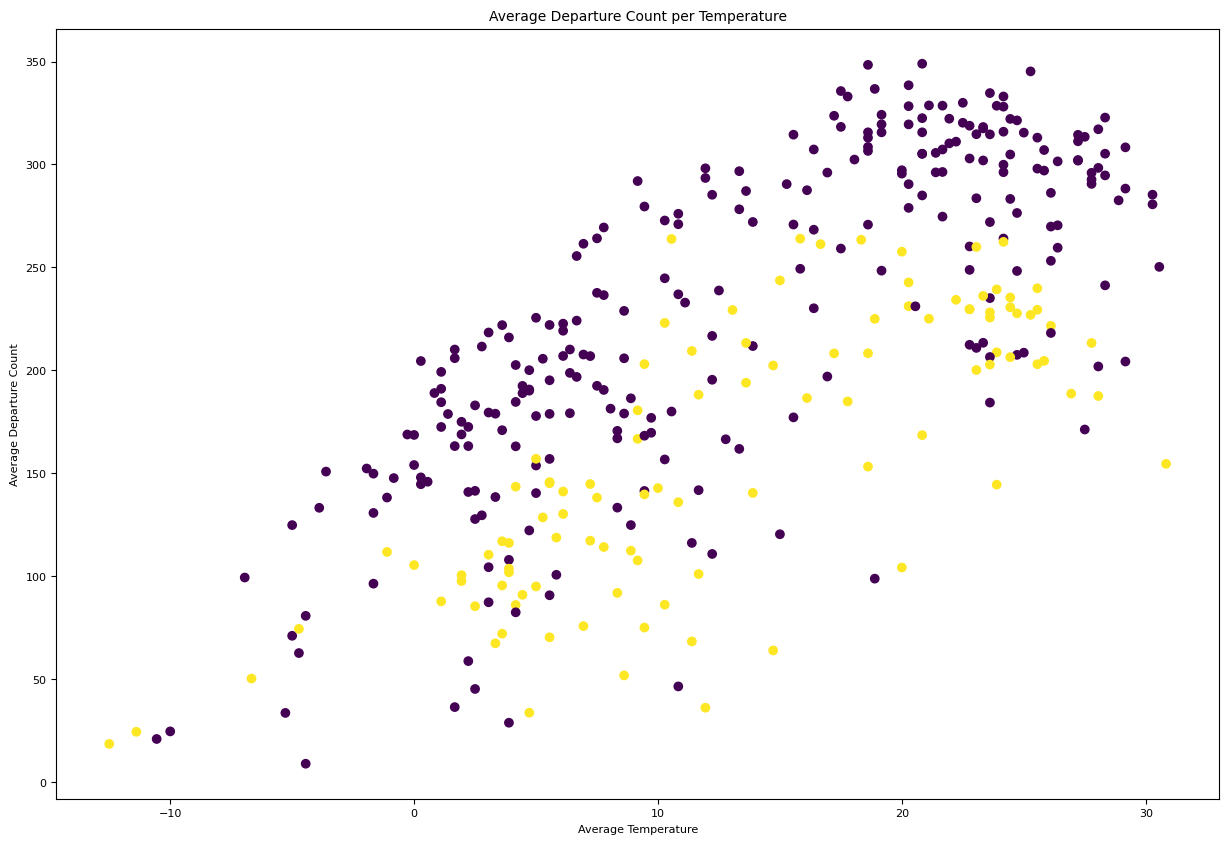

In [63]:
# plot the average number of pickups per hour per average temperature on that day
# distinguish between weekend and weekday
weather_temperature_per_day = weather_data[['day_of_year', 'Avg_temp', 'weekend']].groupby(['day_of_year', 'weekend']).mean().reset_index()
df_departure_avg = df_departure[['day_of_year', 'weekend', 'count']].groupby(['day_of_year', 'weekend']).mean().reset_index()
df_arrival_avg = df_arrival[['day_of_year', 'weekend', 'count']].groupby(['day_of_year', 'weekend']).mean().reset_index()

# plot the average departure count per temperature
plt.scatter(weather_temperature_per_day['Avg_temp'], df_departure_avg['count'], c=df_departure_avg['weekend'])
plt.xlabel('Average Temperature')
plt.ylabel('Average Departure Count')
plt.title('Average Departure Count per Temperature')
plt.show()

Let's plot the best-fit line for the number of departures per day concerning the average temperature of that day. We will plot the best fit for the weekdays and weekends separately. Maybe we can discover the Simpsons paradox here.

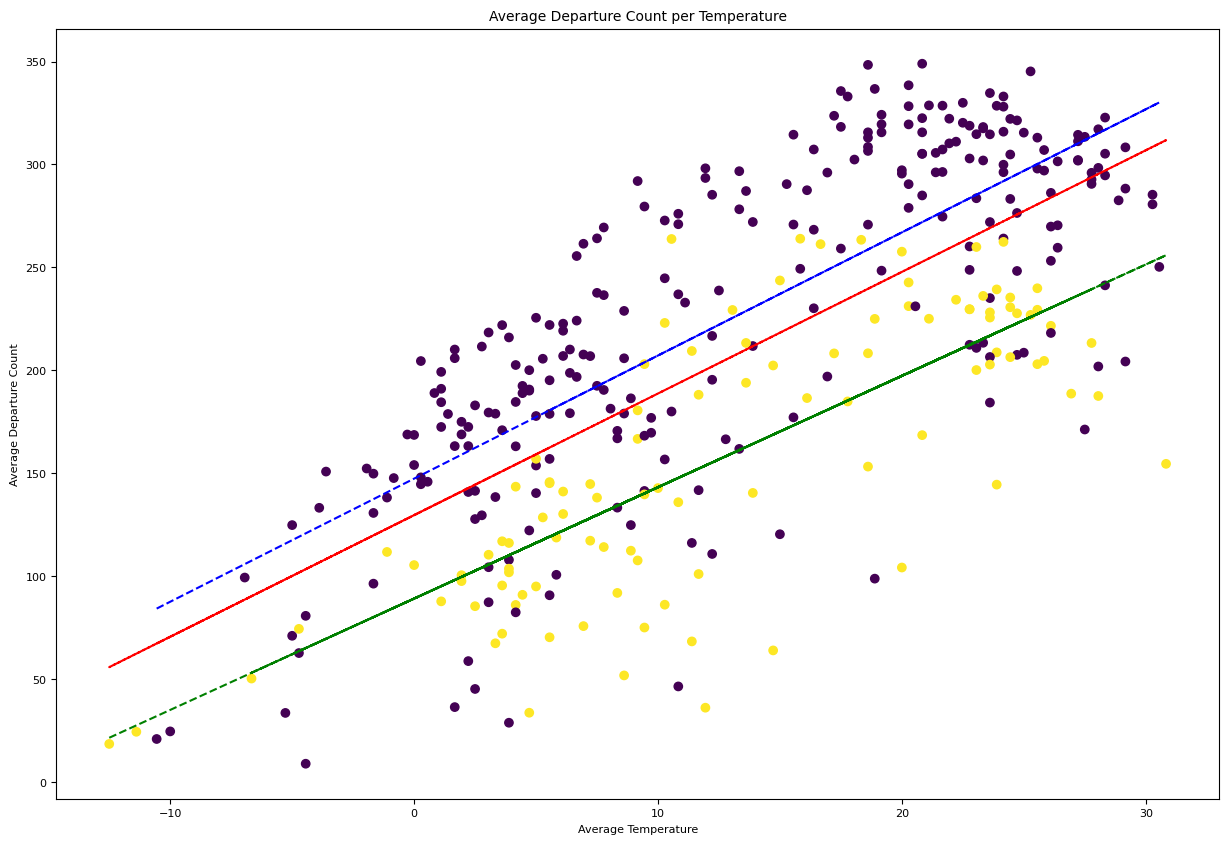

In [64]:
#plot a best fit line for all the data points and then plot 2 separate best fit lines for weekday = 0 and weekday = 1

# get the best fit line for all the data points
z = np.polyfit(weather_temperature_per_day['Avg_temp'], df_departure_avg['count'], 1)
p = np.poly1d(z)
plt.plot(weather_temperature_per_day['Avg_temp'], p(weather_temperature_per_day['Avg_temp']), "r--")

# get the best fit line for weekday = 0
z = np.polyfit(weather_temperature_per_day[weather_temperature_per_day['weekend'] == 0]['Avg_temp'], df_departure_avg[df_departure_avg['weekend'] == 0]['count'], 1)
p = np.poly1d(z)
plt.plot(weather_temperature_per_day[weather_temperature_per_day['weekend'] == 0]['Avg_temp'], p(weather_temperature_per_day[weather_temperature_per_day['weekend'] == 0]['Avg_temp']), "b--")

# get the best fit line for weekday = 1
z = np.polyfit(weather_temperature_per_day[weather_temperature_per_day['weekend'] == 1]['Avg_temp'], df_departure_avg[df_departure_avg['weekend'] == 1]['count'], 1)
p = np.poly1d(z)
plt.plot(weather_temperature_per_day[weather_temperature_per_day['weekend'] == 1]['Avg_temp'], p(weather_temperature_per_day[weather_temperature_per_day['weekend'] == 1]['Avg_temp']), "g--")
plt.scatter(weather_temperature_per_day['Avg_temp'], df_departure_avg['count'], c=df_departure_avg['weekend'])


plt.xlabel('Average Temperature')
plt.ylabel('Average Departure Count')
plt.title('Average Departure Count per Temperature')
plt.show()


As we can see there is a strong correlation between the average temperature on a given day and the number of departures. As we can see the higher the temperature the more bikes are used. We can also see that the number of departures is higher on weekdays than on weekends. This is to be expected as most people travel for business and not for pleasure.

C:\Users\alexi\AppData\Local\Temp\ipykernel_11192\863634297.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_precipitation_per_day['Precipitation'] = weather_precipitation_per_day['Precipitation'].astype(float)


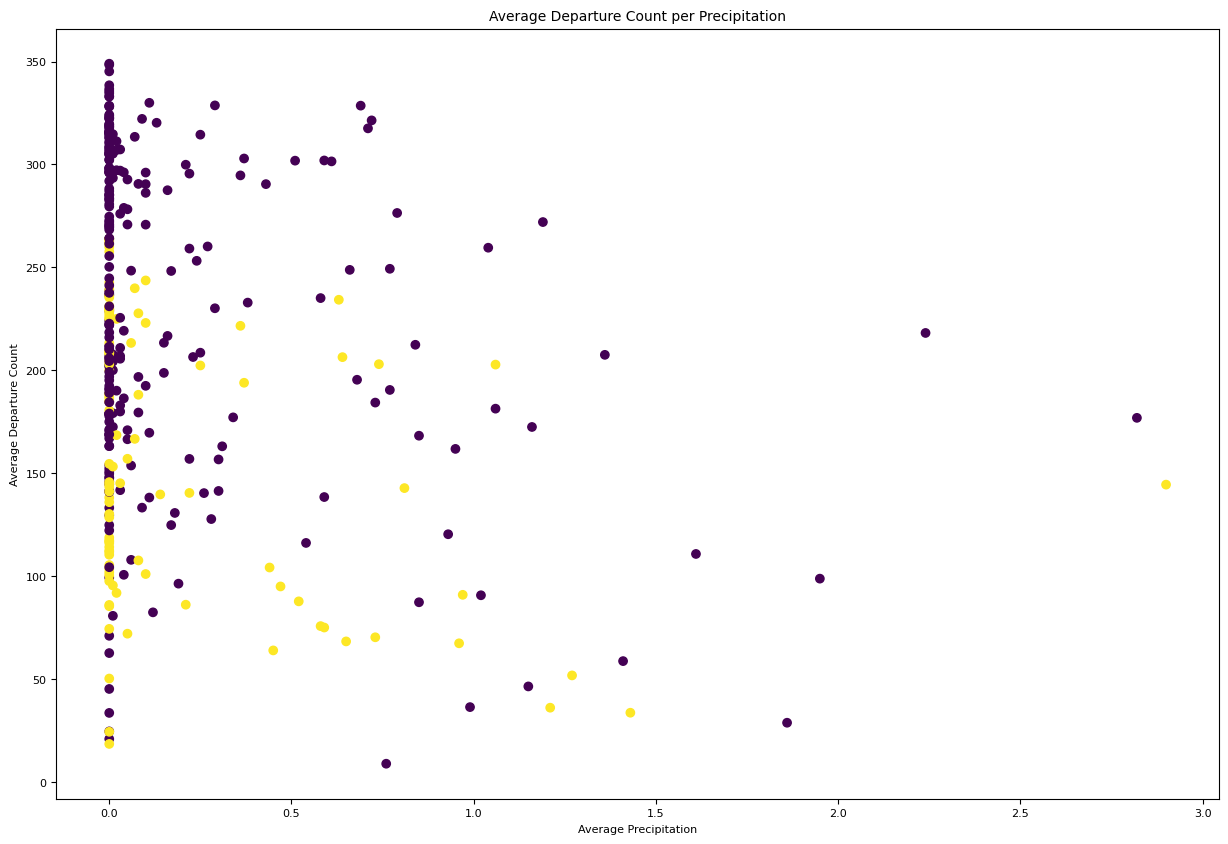

In [65]:
# calculate average precipitation per day 
weather_precipitation_per_day = weather_data[['day_of_year', 'Precipitation', 'weekend']]

weather_precipitation_per_day['Precipitation'] = weather_precipitation_per_day['Precipitation'].astype(float)
weather_data['Precipitation'] = weather_data['Precipitation'].astype(float)

weather_precipitation_per_day = weather_precipitation_per_day.groupby(['day_of_year', 'weekend']).mean().reset_index()

# plot the average Precipitation per day against the average count of departures per day
plt.scatter(weather_precipitation_per_day['Precipitation'], df_departure_avg['count'], c=df_departure_avg['weekend'])
plt.xlabel('Average Precipitation')
plt.ylabel('Average Departure Count')
plt.title('Average Departure Count per Precipitation')
plt.show()

Let's do the same thing for the Average precipitation and the number of departures. We will plot the best fit for the weekdays and weekends separately.

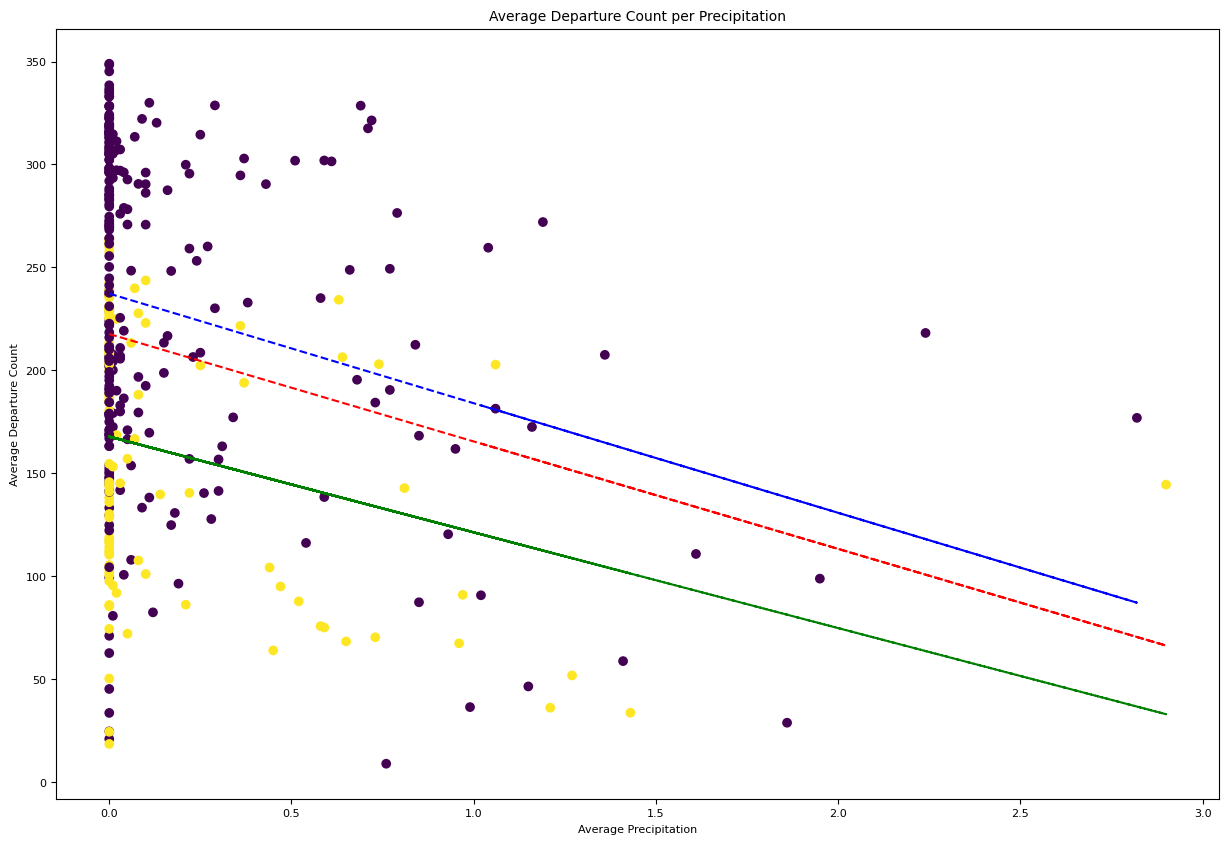

In [66]:
#plot a best fit line for all the data points and then plot 2 separate best fit lines for weekday = 0 and weekday = 1

# get the best fit line for all the data points
z = np.polyfit(weather_precipitation_per_day['Precipitation'], df_departure_avg['count'], 1)
p = np.poly1d(z)
plt.plot(weather_precipitation_per_day['Precipitation'], p(weather_precipitation_per_day['Precipitation']), "r--")

# get the best fit line for weekday = 0
z = np.polyfit(weather_precipitation_per_day[weather_precipitation_per_day['weekend'] == 0]['Precipitation'], df_departure_avg[df_departure_avg['weekend'] == 0]['count'], 1)
p = np.poly1d(z)
plt.plot(weather_precipitation_per_day[weather_precipitation_per_day['weekend'] == 0]['Precipitation'], p(weather_precipitation_per_day[weather_precipitation_per_day['weekend'] == 0]['Precipitation']), "b--")

# get the best fit line for weekday = 1
z = np.polyfit(weather_precipitation_per_day[weather_precipitation_per_day['weekend'] == 1]['Precipitation'], df_departure_avg[df_departure_avg['weekend'] == 1]['count'], 1)
p = np.poly1d(z)
plt.plot(weather_precipitation_per_day[weather_precipitation_per_day['weekend'] == 1]['Precipitation'], p(weather_precipitation_per_day[weather_precipitation_per_day['weekend'] == 1]['Precipitation']), "g--")
plt.scatter(weather_precipitation_per_day['Precipitation'], df_departure_avg['count'], c=df_departure_avg['weekend'])

plt.xlabel('Average Precipitation')
plt.ylabel('Average Departure Count')
plt.title('Average Departure Count per Precipitation')
plt.show()

As we can see there is a strong correlation between the precipitation and the number of departures. The more it rains the fewer bikes are used. We will therefore use the precipitation and the average temperature as features in our regression model.

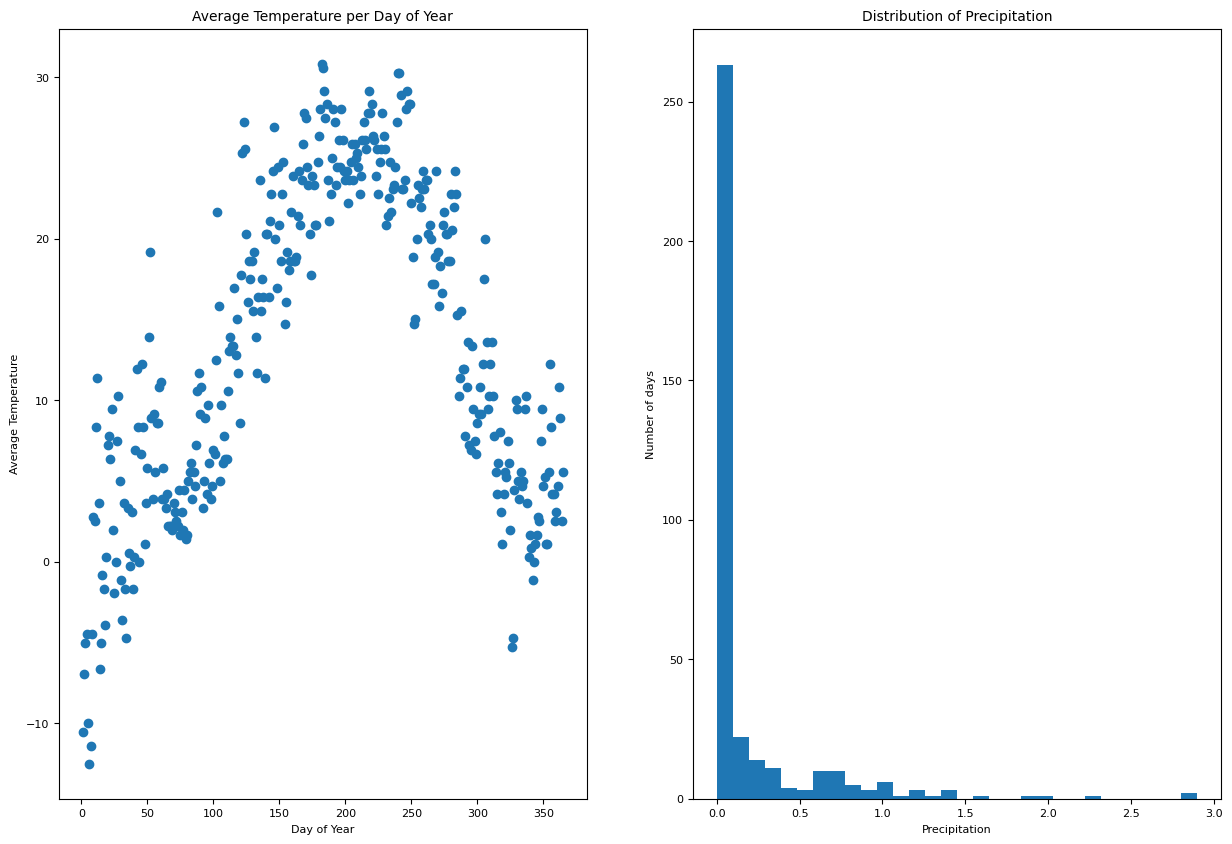

In [67]:
# plot the temperature for each day in the year and distribution of the precipitation 
plt.subplot(1, 2, 1)
plt.scatter(weather_data['day_of_year'], weather_data['Avg_temp'])
plt.xlabel('Day of Year')
plt.ylabel('Average Temperature')
plt.title('Average Temperature per Day of Year')
plt.subplot(1, 2, 2)
plt.hist(weather_data['Precipitation'], bins=30)
plt.xlabel('Precipitation')
plt.ylabel('Number of days')
plt.title('Distribution of Precipitation')
plt.show()

As we can see, there are no anomalies in the data. Now, only the two clusters with the largest number of arrivals and the largest number of departures will be used. 

In [68]:
# only keep largest label data
df_arrival_largest = df_arrival[df_arrival['label'] == df_arrival['label'].value_counts().nlargest(1).index[0]]
df_arrival_largest.head()
df_departure_largest = df_departure[df_departure['label'] == df_departure['label'].value_counts().nlargest(1).index[0]]
df_departure_largest.head()

,time,hour,day,month,weekend,day_of_week,day_of_year,label,count
0,2018-01-01 13:50:57.434,13,1,1,0,0,1,6,29
1,2018-01-01 15:33:30.182,15,1,1,0,0,1,6,36
2,2018-01-01 15:39:18.337,15,1,1,0,0,1,6,36
3,2018-01-01 15:40:13.372,15,1,1,0,0,1,6,36
4,2018-01-01 18:14:51.568,18,1,1,0,0,1,6,31


In [69]:
# drop label
df_arrival_largest.drop(['label'], axis=1, inplace=True)
df_departure_largest.drop(['label'], axis=1, inplace=True)

weather_data.drop(['year'], axis=1, inplace=True)
# merge with weather data
df_arrival_largest = df_arrival_largest.merge(weather_data, on=['day', 'month', 'weekend', 'day_of_week', 'day_of_year'], how='left')
df_departure_largest = df_departure_largest.merge(weather_data, on=['day', 'month', 'weekend', 'day_of_week', 'day_of_year'], how='left')

C:\Users\alexi\AppData\Local\Temp\ipykernel_11192\1027465442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arrival_largest.drop(['label'], axis=1, inplace=True)
C:\Users\alexi\AppData\Local\Temp\ipykernel_11192\1027465442.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_departure_largest.drop(['label'], axis=1, inplace=True)


In [70]:
df_arrival_largest.head()

,time,hour,day,month,weekend,day_of_week,day_of_year,count,Max_temp,Min_temp,Avg_temp,Departure_temp,Precipitation,Snowfall,Snow_depth
0,2018-01-01 15:45:33.341,15,1,1,0,0,1,45,-7.222222,-13.888889,-10.555556,-30.111111,0.0,0.0,0.0
1,2018-01-01 15:47:35.172,15,1,1,0,0,1,45,-7.222222,-13.888889,-10.555556,-30.111111,0.0,0.0,0.0
2,2018-01-01 15:45:20.191,15,1,1,0,0,1,45,-7.222222,-13.888889,-10.555556,-30.111111,0.0,0.0,0.0
3,2018-01-02 08:13:28.767,8,2,1,0,1,2,211,-3.333333,-10.555556,-6.944444,-26.388889,0.0,0.0,0.0
4,2018-01-02 08:16:21.896,8,2,1,0,1,2,211,-3.333333,-10.555556,-6.944444,-26.388889,0.0,0.0,0.0


In [71]:
df_departure_largest.head()

,time,hour,day,month,weekend,day_of_week,day_of_year,count,Max_temp,Min_temp,Avg_temp,Departure_temp,Precipitation,Snowfall,Snow_depth
0,2018-01-01 13:50:57.434,13,1,1,0,0,1,29,-7.222222,-13.888889,-10.555556,-30.111111,0.0,0.0,0.0
1,2018-01-01 15:33:30.182,15,1,1,0,0,1,36,-7.222222,-13.888889,-10.555556,-30.111111,0.0,0.0,0.0
2,2018-01-01 15:39:18.337,15,1,1,0,0,1,36,-7.222222,-13.888889,-10.555556,-30.111111,0.0,0.0,0.0
3,2018-01-01 15:40:13.372,15,1,1,0,0,1,36,-7.222222,-13.888889,-10.555556,-30.111111,0.0,0.0,0.0
4,2018-01-01 18:14:51.568,18,1,1,0,0,1,31,-7.222222,-13.888889,-10.555556,-30.111111,0.0,0.0,0.0


In [72]:
# drop time
df_arrival_largest.drop(['time'], axis=1, inplace=True)
df_departure_largest.drop(['time'], axis=1, inplace=True)

Two models will be created to train the data. The first one is the ridge regression model, the same one which was used in the previous section of this report. On the other hand, the second model is the XGBoost regression which is a supervised learning algorithm which works well with large and nonlinear data sets. 

In [73]:
# lag 
def buildLaggedFeatures(s,columns, lag=24,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

In [74]:
n_lag = 24
df_arrival_largest = buildLaggedFeatures(df_arrival_largest, ['count'], n_lag)
df_departure_largest = buildLaggedFeatures(df_departure_largest, ['count'], n_lag)

In [75]:
# basis fuctions
def add_polynomial(df, n):
    for i in range(1, n+1):
        df['poly_hour_{}'.format(i)] = df['hour']**i
    return df

def add_sin_cos(df):
    df['sin_hour'] = np.sin(2*np.pi*df['hour']/24)
    df['cos_hour'] = np.cos(2*np.pi*df['hour']/24)
    return df


In [76]:
# add polynomial features
n_poly = 10
# df_arrival_largest = add_polynomial(df_arrival_largest, n_poly)
# df_departure_largest = add_polynomial(df_departure_largest, n_poly)

# # add sin and cos
# df_arrival_largest = add_sin_cos(df_arrival_largest)
# df_departure_largest = add_sin_cos(df_departure_largest)


In [77]:
# split data into train and test month >= 10 train
df_arrival_largest_train = df_arrival_largest[df_arrival_largest['month'] < 10]
df_arrival_largest_test = df_arrival_largest[df_arrival_largest['month'] >= 10]
df_departure_largest_train = df_departure_largest[df_departure_largest['month'] < 10]
df_departure_largest_test = df_departure_largest[df_departure_largest['month'] >= 10]

# get rid of row nan
df_arrival_largest_train = df_arrival_largest_train.dropna()
df_arrival_largest_test = df_arrival_largest_test.dropna()
df_departure_largest_train = df_departure_largest_train.dropna()
df_departure_largest_test = df_departure_largest_test.dropna()

In [78]:
# x y split
def create_x_y(df):
    x = df.drop(['count'], axis=1)
    y = df['count']
    return x, y

# drop duplicates
df_arrival_largest_train.drop_duplicates(inplace=True)
df_arrival_largest_test.drop_duplicates(inplace=True)
df_departure_largest_train.drop_duplicates(inplace=True)
df_departure_largest_test.drop_duplicates(inplace=True)

x_arrivals_train, y_arrivals_train = create_x_y(df_arrival_largest_train)
x_arrivals_test, y_arrivals_test = create_x_y(df_arrival_largest_test)
x_departures_train, y_departures_train = create_x_y(df_departure_largest_train)
x_departures_test, y_departures_test = create_x_y(df_departure_largest_test)

In [79]:
# print column data types
print(x_arrivals_train.dtypes)

hour                int32
day                 int32
month               int32
weekend             int32
day_of_week         int32
day_of_year         int32
Max_temp          float64
Min_temp          float64
Avg_temp          float64
Departure_temp    float64
Precipitation     float64
Snowfall          float64
Snow_depth        float64
count_lag1        float64
count_lag2        float64
count_lag3        float64
count_lag4        float64
count_lag5        float64
count_lag6        float64
count_lag7        float64
count_lag8        float64
count_lag9        float64
count_lag10       float64
count_lag11       float64
count_lag12       float64
count_lag13       float64
count_lag14       float64
count_lag15       float64
count_lag16       float64
count_lag17       float64
count_lag18       float64
count_lag19       float64
count_lag20       float64
count_lag21       float64
count_lag22       float64
count_lag23       float64
count_lag24       float64
dtype: object


In [80]:
# standardise and keep df
def standardise(df):
    for i in df.columns:
        df[i] = (df[i] - np.mean(df[i])) / np.std(df[i])
    return df

x_arrivals_train_std = standardise(x_arrivals_train)
x_arrivals_test_std = standardise(x_arrivals_test)
x_departures_train_std = standardise(x_departures_train)
x_departures_test_std = standardise(x_departures_test)


In [81]:
# are nan in std
# print(np.isnan(x_arrivals_train_std).any())
# print(np.isnan(x_arrivals_test_std).any())
# print(np.isnan(x_departures_train_std).any())
print(np.isnan(x_departures_test_std).any())


hour              False
day               False
month             False
weekend           False
day_of_week       False
day_of_year       False
Max_temp          False
Min_temp          False
Avg_temp          False
Departure_temp    False
Precipitation     False
Snowfall          False
Snow_depth        False
count_lag1        False
count_lag2        False
count_lag3        False
count_lag4        False
count_lag5        False
count_lag6        False
count_lag7        False
count_lag8        False
count_lag9        False
count_lag10       False
count_lag11       False
count_lag12       False
count_lag13       False
count_lag14       False
count_lag15       False
count_lag16       False
count_lag17       False
count_lag18       False
count_lag19       False
count_lag20       False
count_lag21       False
count_lag22       False
count_lag23       False
count_lag24       False
dtype: bool


In [82]:
def add_ones_column(df):
    df.insert(0, 'ones', 1)
    return df

x_arrivals_train_std = add_ones_column(x_arrivals_train_std)
x_arrivals_test_std = add_ones_column(x_arrivals_test_std)
x_departures_train_std = add_ones_column(x_departures_train_std)
x_departures_test_std = add_ones_column(x_departures_test_std)

In [83]:
x_arrivals_train_std.head()

,ones,hour,day,month,weekend,day_of_week,day_of_year,Max_temp,Min_temp,Avg_temp,...,count_lag15,count_lag16,count_lag17,count_lag18,count_lag19,count_lag20,count_lag21,count_lag22,count_lag23,count_lag24
24,1,0.807082,-1.616518,-1.899152,-0.48953,-0.906593,-2.087729,-2.630985,-2.626206,-2.661984,...,-1.033179,-1.253721,-1.253627,-1.281093,-0.711480,-0.711502,-0.711523,-1.473498,-1.473360,-1.473237
25,1,0.807082,-1.616518,-1.899152,-0.48953,-0.906593,-2.087729,-2.630985,-2.626206,-2.661984,...,-1.005602,-1.033136,-1.253627,-1.253530,-1.280996,-0.711502,-0.711523,-0.711548,-1.473360,-1.473237
26,1,0.807082,-1.616518,-1.899152,-0.48953,-0.906593,-2.087729,-2.630985,-2.626206,-2.661984,...,-1.005602,-1.005563,-1.033080,-1.253530,-1.253439,-1.280900,-0.711523,-0.711548,-0.711576,-1.473237
27,1,0.807082,-1.616518,-1.899152,-0.48953,-0.906593,-2.087729,-2.630985,-2.626206,-2.661984,...,-1.005602,-1.005563,-1.005512,-1.033028,-1.253439,-1.253348,-1.280796,-0.711548,-0.711576,-0.711609
28,1,1.011169,-1.616518,-1.899152,-0.48953,-0.906593,-2.087729,-2.630985,-2.626206,-2.661984,...,-0.628716,-1.005563,-1.005512,-1.005465,-1.032981,-1.253348,-1.253251,-1.280715,-0.711576,-0.711609


In [84]:
# ridge model
from sklearn.linear_model import Ridge

ridge_arrivals = Ridge(alpha=0.1)
ridge_departures = Ridge(alpha=0.1)


In [85]:
# train/fit model
ridge_arrivals.fit(x_arrivals_train_std, y_arrivals_train)
ridge_departures.fit(x_departures_train_std, y_departures_train)

Ridge(alpha=0.1)

r^2 score for arrivals: 0.8314910451224419
r^2 score for departures: 0.8417013093502541


Text(0, 0.5, 'Predicted')

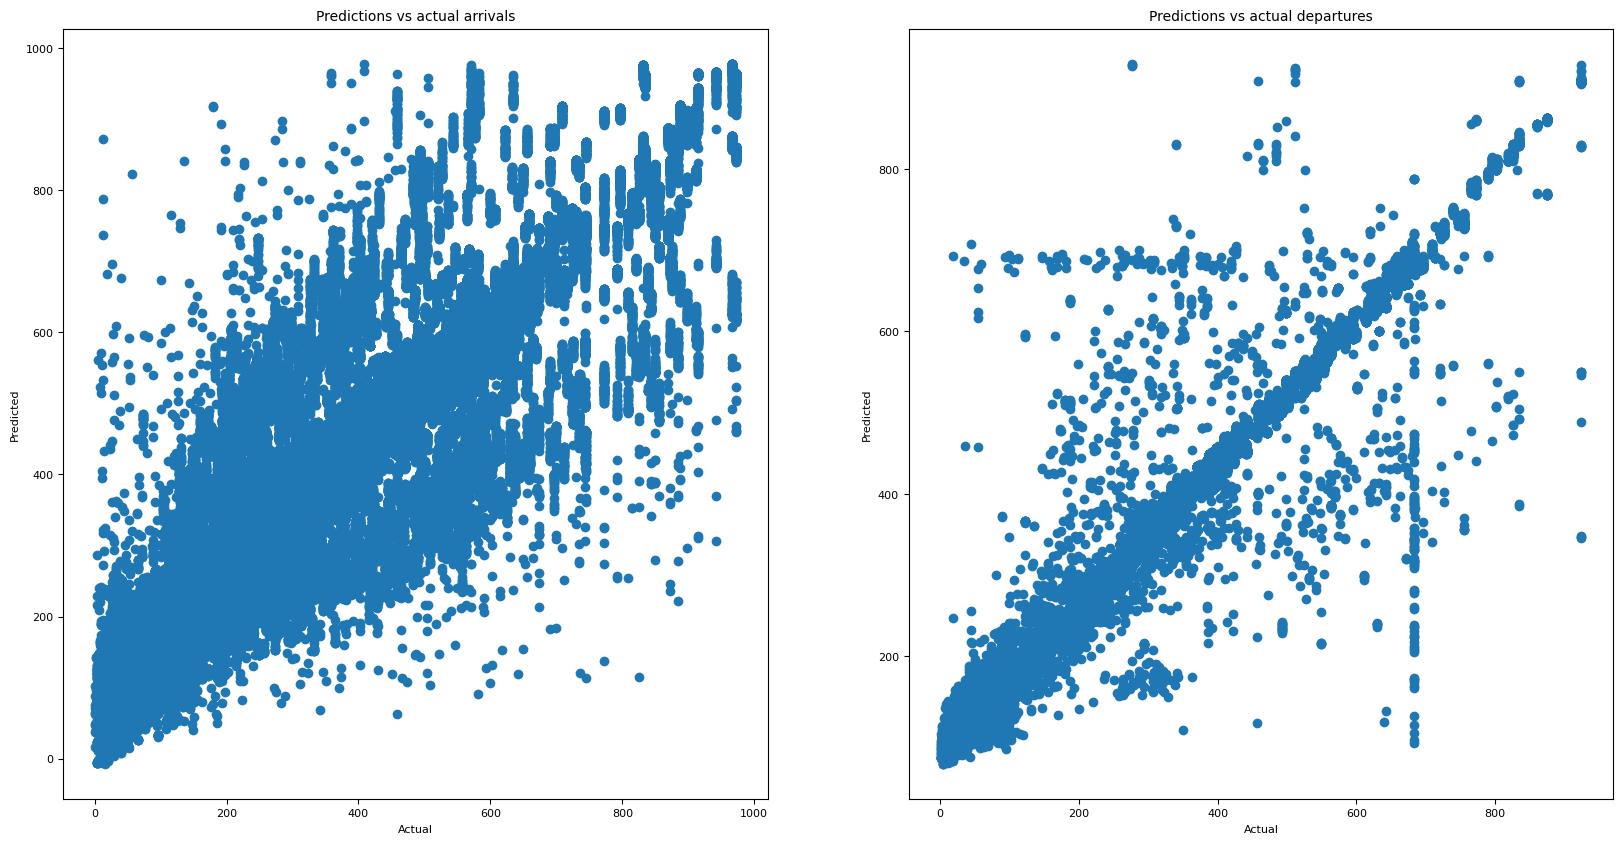

In [86]:
# r^2 and visualise predictions
from sklearn.metrics import r2_score

print('r^2 score for arrivals: {}'.format(r2_score(y_arrivals_test, ridge_arrivals.predict(x_arrivals_test_std))))
print('r^2 score for departures: {}'.format(r2_score(y_departures_test, ridge_departures.predict(x_departures_test_std))))

# plot predictions vs actual
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(y_arrivals_test, ridge_arrivals.predict(x_arrivals_test_std))
plt.title('Predictions vs actual arrivals')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.subplot(1, 2, 2)
plt.scatter(y_departures_test, ridge_departures.predict(x_departures_test_std))
plt.title('Predictions vs actual departures')
plt.xlabel('Actual')
plt.ylabel('Predicted')

r^2 score for arrivals: 0.8224189857842699
r^2 score for departures: 0.6441564507043339


Text(0, 0.5, 'Predicted')

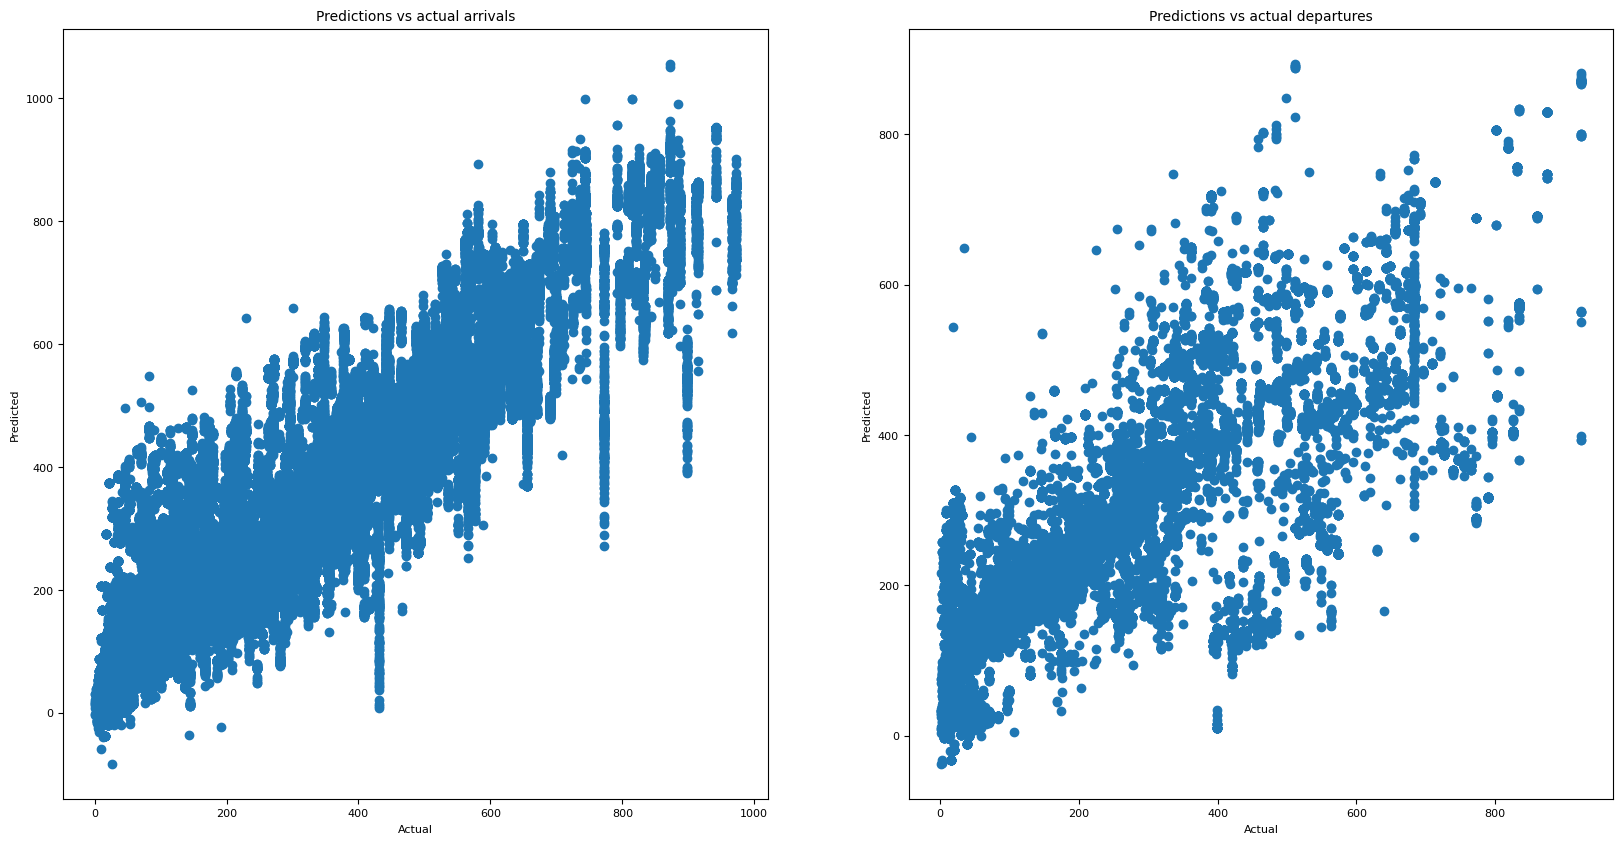

In [87]:
# XGBRegressor
from xgboost import XGBRegressor

xgb_arrivals = XGBRegressor()
xgb_departures = XGBRegressor()

# train/fit model
xgb_arrivals.fit(x_arrivals_train_std, y_arrivals_train)
xgb_departures.fit(x_departures_train_std, y_departures_train)

# r^2 and visualise predictions
print('r^2 score for arrivals: {}'.format(r2_score(y_arrivals_test, xgb_arrivals.predict(x_arrivals_test_std))))
print('r^2 score for departures: {}'.format(r2_score(y_departures_test, xgb_departures.predict(x_departures_test_std))))

# plot predictions vs actual
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(y_arrivals_test, xgb_arrivals.predict(x_arrivals_test_std))
plt.title('Predictions vs actual arrivals')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.subplot(1, 2, 2)
plt.scatter(y_departures_test, xgb_departures.predict(x_departures_test_std))
plt.title('Predictions vs actual departures')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [88]:
# use grid search to get better xgb model
from sklearn.model_selection import GridSearchCV

# define parameters
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

# define model
xgb_arrivals = XGBRegressor()
xgb_departures = XGBRegressor()

# define grid search
grid_search_arrivals = GridSearchCV(estimator=xgb_arrivals, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_departures = GridSearchCV(estimator=xgb_departures, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# train/fit model
grid_search_arrivals.fit(x_arrivals_train_std, y_arrivals_train)
grid_search_departures.fit(x_departures_train_std, y_departures_train)

# r^2 and visualise predictions
print('r^2 score for arrivals: {}'.format(r2_score(y_arrivals_test, grid_search_arrivals.predict(x_arrivals_test_std))))
print('r^2 score for departures: {}'.format(r2_score(y_departures_test, grid_search_departures.predict(x_departures_test_std))))

# plot predictions vs actual
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(y_arrivals_test, grid_search_arrivals.predict(x_arrivals_test_std))
plt.title('Predictions vs actual arrivals')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.subplot(1, 2, 2)
plt.scatter(y_departures_test, grid_search_departures.predict(x_departures_test_std))
plt.title('Predictions vs actual departures')
plt.xlabel('Actual')
plt.ylabel('Predicted')


Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

In [ ]:
# get params from grid search
print(grid_search_arrivals.best_params_)
print(grid_search_departures.best_params_)

# Conclusion
From the R^2 scores of the ridge and XGBoost regression models it can be concluded that the ridge model generally has a good performance for both arrivals and departures while the XGB model has even better performance for arrivals but poor performance for departures. Also that weather data could be used to predict the demand of bikes.

It was observed that by introducing many new features the model was not improved according to the R^2 metric. This is an example of phenomena called the curse of dimensionality which says that with the fixed number of training sets, the performance of the mo
del is expected to increase with the increasing number of features/dimensions used until a certain number of dimensions after which the performance of the model is not increased anymore.

=======================================================================================================================================================================================================
=======================================================================================================================================================================================================

# Appendix A

This appendix contains intuitive explanations for the choices made in the report. 

- **Appendix A1:** The weekday and weekend split has been made due to the observation of morning and evening rushes on weekdays, which were absent in the weekends. Hence predictions would be better when the data is split up, and a separate model tailored to the presence/absence of rushes would be beneficial. 

- **Appendix A2:** This is because the absence of departures data caused errors in the parametric code. This could be fixed by making separate code for this cluster specifically, however, since it was already not required to do it for all clusters and the data available for this cluster was very sparse (hence the model would not perform too well), we decided to neglect this cluster in the prediction challenges of part 2 & 3.

- **Appendix A3:** Since each data entry has 2 temporal variables, aggregating the data entries by hour would yield aggregation based on only one of the two hours present, aggregation on the departure times only for example. Hence, splitting up the dataset into departures and arrivals allows us to aggregate the data entries per cluster, hour, and date while keeping all information necessary for prediction of the departures and arrivals later on in pt. 3

- **Appendix A4:** They either yielded poor prediction quality if included, or are simply not necessary information anymore for prediction

- **Appendix A5:** The amount of missing datapoints within each cluster varies significantly between clusters and can be a good explanation for the poor performance of other models in the future. This is because the more missing datapoints, the more nonexistent lagged information the model will use (see further), hence the poorer the information the model can use for prediction, hence the poorer prediction performance.

- **Appendix A6:** Since we will be including lagged departures/arrivals counts in our input data, we have to evaluate the implications of this. 
- At any moment in time, when predicting for the following hour, you will have all lagged data available to you, so there is no problem. 
- If one desires to predict further than one hour in advance, a problem occurs. Say one desires to predict 2 hours into the future. This prediction requires knowledge of the departures/arrivals count at 1 hour in the future, which, unless you can predict the future yourself (in that case please contact us), the data is unavailable for. Hence, as soon as one desires to predict further into the future than 1 hour, the inclusion of the lagged counts in the input dataset will become an issue. This problem is especially prevalent in pt. 3 of the assignment. We will fix this issue by recursively adding the prediction to the input dataset and predicting again, which is the only solution to acquire the lagged counts of future values necessary to predict further into the future with the model trained on this input data.

- **Appendix A7:** Avg_tripduration and lags have been left out since the prediction model predicting this variable performed very poorly. We need a prediction model for this variable due to the issue stated above. And since the model performed so poorly, the variable could not be included as it would yield increasingly bad predictions the further we went into the future for pt.3. Hence, only the lags on departures/arrivals counts have been included. This has proven to yield a very similar and slightly better accuracy as the model with avg_tripduration and lags included, hence leaving it out of the input highly benefitted pt.3, while keeping performance on pt.2 satisfactory. Avg_gender, month and date all yielded poor prediction quality. The "day of week" (Mon, Tue, ...) will be added instead. 

- **Appendix A8:** For the first day entry, we don't have any previous datapoints, so we cannot add lagged features for the first datapoint. For the second entry, we only have one lagged datapoint, etc. There aren't sufficient previous datapoints to make lagged data for the first 30 data entries, hence they will be dropped by the BuildLaggedFeatures function. Our explanation can be proven by looking at the date and hour of the first entry in the lagged dataset visible above, remember the dates and hours have been sorted. 

- **Appendix A9:** 1 column of ones, 1 column of the "day of week" as a continuous variable (0-6), 7 columns of dummy variables for the "day of week", 1 column for the hour, and 24 columns of lagged departures/arrivals counts.

- **Appendix A10:** 1 column for the ones, 1 column for the "day of week" as continuous number 0-6, 7 columns for the "day of week" dummies, 1 column for the hour, n_lag cols of lagged departures/arrivals counts. This leaves us with (10 + n_lag) columns. Then we add polynomial features to the hour and departures/arrivals counts lags, and concatenate the resulting columns. 

- **Appendix A11:** 1 column for the ones, 1 column for the "day of week" as continuous number 0-6, 7 columns for the "day of week" dummies, 1 column for the hour, 1 column for sin(hour), n_lag columns of lagged departures/arrivals counts. This leaves us with (10 + n_lag) columns. Then we add polynomial features to the hour and departures/arrivals counts lags, and concatenate the resulting columns.

- **Appendix A12:** 1 column for the ones, 1 column for the "day of week" as continuous number 0-6, 7 columns for the "day of week" dummies, 1 column for the hour, 1 column for sin(hour), 1 column for cos(hour), n_lag columns of lagged departures/arrivals counts. This leaves us with (10 + n_lag) columns. Then we add polynomial features to the hour and departures/arrivals counts lags, and concatenate the resulting columns.

- **Appendix A13:** This is because, for weekdays, morning and evening rush hours have been observed which were absent on the weekends. Hence, by splitting up the dataset, the model could make more accurate predictions, which is what was observed when comparing the non-split-up and split-up prediction performances.  

- **Appendix A14:** We desire the model to predict the number of departures/arrivals happening one hour after the lagged counts input data for each cluster, for weekdays or weekends. That is, using departures/arrivals counts occurring in that cluster for the past 24 hours, predict the number of departures/arrivals happening the next hour. Thus, the target data is simply the number of departures/arrivals happening at that hour after the past 24-hour lagged data. This data will be extracted in the cell below. Additionally, we again split the target data into weekdays and weekends to provide the models with the correct target data. 

- **Appendix A15:** For the input datasets: Note that the first column in all input datasets only consists of ones, hence the standard deviation of all the data in this column will be 0 and standardizing the input data with this column included will yield a division by zero error. To avoid this, we will neglect the first column in the standardisation process and then add the column of ones back in. Additionally, the "day of week" categorical columns stored in columns 2-8 will also be excluded from the standardization process, as standardising these dummy variables is nonsensical. For the target variable datasets: we can safely standardise the entirety of the dataset. 

- **Appendix A16:** Due to the standardization process, we will not use Lasso, since a lot of the data is on a small scale. This means that the coefficients will be small as well. Lasso would drag these still relevant coefficients to 0 and caused very poor performance. Ridge yielded more accurate results than LinearRegression.

- **Appendix A17:** The decreasing prediction performance trend is most likely because we ordered the clusters by the largest to the smallest amount of datapoints (previously visible in the shape checks). This means that the clusters to the right have fewer datapoints to use for prediction. Additionally, the missing datapoints are dispersed in time rather than showing a regular trend (*), making the lack of data even more detrimental. Why? This dispersed lack of data will cause frequent occurrences of the situation where you don't have a lagged departures/arrivals count datapoint at the correct hour at your disposal. This means that you will use a lagged departures/arrivals counts datapoint from a previous hour. Hence, to predict in the future, you will use lagged data, not from the previous 30 hours, but from the previous 36 (if 6 hours are missing), making predictions worse.

- **Appendix A18:** For pt. 3 we will predict 24 hours into the future. However, as explained previously, to predict one hour into the future, our model requires data on the previous 24 hours. This data, since we predict the future, is not always available. In order to solve this issue, we apply a step approach where we implement the model prediction for the previous future hour timestamp as input to the model such that it can predict the following future hour timestamp. The current issue is that our model uses lags on both departures/arrivals counts, and departures/arrivals counts². We already have a model which can predict the departures/arrivals counts for the next hour, however, the question is how we will obtain a value for the departures/arrivals counts². 

    An intuitive solution would be to simply square the prediction output for the departures/arrivals counts. However, there is a vital mistake with this approach. Our departures/arrivals count predictor model namely returns the standardised departures/arrivals counts value, a consequence of supplying the model with both input and output standardised data. One could ask themselves why the target variable was standardised in the first place, this was because this yielded better prediction accuracy (if no standardisation was present, some R^2 were even negative). Thus, the prediction output cannot simply be squared, since the square of a standard deviation is not equal to the standard deviation of the squares, and thus our prediction would be wrong. 

    Unstanderdizing the predicted departures/arrivals counts, squaring and standardizing would also not be an option. An important remark for this method is that one has to use the training dataset distribution (mean and std) for this method. Usage of the test set is not allowed, since in pt.3 we use a snippet from the test set to make the future prediction. While in real life we would predict further than the scope of the test set, currently we do not have information on this future data. For this reason, we should not use the distribution of the test set, since acquiring the means and std from the entire test set means using data which goes beyond our snippet, and which is thus future data we would normally have no information on. The same reason holds for why we cannot use the mean and std from the full data (train + test). We have attempted to perform this step with the distribution from the training set only, however, this yielded poor results. 

    The final remaining option is to then create a model for predicting the standardised departures/arrivals counts² values, which is the approach we chose. Note that the creation of the input dataset should be exactly the same as before. If we were to use another dataset, we would have to check whether all elements used in the input were available in the future as well. Luckily, the same input dataset yielded acceptable results. The reason why we recomputed the exact same dataset was to see if for the prediction at hand a different combination of poly degree, lag, and added sine or cosine features would be more beneficial. To our surprise, using the exact same combination as before yielded the best results. Luckily recomputation of the input dataset takes very little time, so we left it here for you to play around with ;). 

- **Appendix A19:** A question one might ask is why we make use of a snippet from the test set for this part. We chose a snippet from the test set rather than the training set since this allows us to use the distribution (mean, std) from the training set (as this data is "in the past" for the test set and thus safe to use). Furthermore, we chose a snippet from the test set rather than creating random data, since random data does not have the underlying distribution one would normally encounter for the counts of the bikes. This would make the lagged features quite useless in predicting the next hour. 

- **Appendix A20:** The reason for degree = 2 is that we only have prediction models for departures/arrivals counts and counts², a higher degree would require prediction models for higher degrees. While we could perfectly create these models and make them available such that one can use models taking into account higher degree features for the current future prediction, degree 2 has proven to yield the highest prediction accuracy, so no higher degree is made available for this step. Then, we could also perfectly add the possibility to change the features taken into account to "poly", "poly + sine" or "poly + sine + cosine", however again, "poly + sine + cosine" has proven to yield the highest prediction accuracy, so instead of making the other options available (which would have required a number of if statements since a different amount of features jumbles up the order of the columns), for brevity's and accuracy's sake, we only made the "poly + sine + cosine" option available.

- **Appendix A21:** Note that a snippet has to end at 11 PM due to the determination of the "day of week" dummy variable. Also note that we need to input the standardised value for each version of an hour (standard, sine, cosine). We can find these in the snippet of data we took from the test set. Since the last data entry in the snippet corresponds to 11 PM, the value in the standard hour column is the standardised value for 11 PM, the value in the cos(hour) column will be the standardized value for cos(11 PM), same for sine. 


# Appendix B
There are entries with T and M in our weather data. What do these mean?
- T - This means that only a trace of precipitation has fallen.  Trace is defined as less than the smallest measurable amount.  That threshold is below for the different precipitation measurements:
    - Liquid precipitation (rain, showers) - Less than 0.005 inches
    - Snowfall - Less than 0.05 inches
    - Snow depth on the ground - Less than 0.5 inches
- M - Means that the data is missing.  This can happen for a variety of reasons including the data did not make a quality check, there was an equipment outage, or even the observer was not available at a manual station